In [1]:
import sys

print(sys.version)

3.10.9 | packaged by Anaconda, Inc. | (main, Mar  8 2023, 10:42:25) [MSC v.1916 64 bit (AMD64)]


# 0. Introduction

Home Credit is an international non-bank financial institution founded in 1997 in the Czech Republic. The company operates in 14 countries and focuses on lending primarily to people with little or no credit history.

Home Credit strives to broaden financial inclusion for the unbanked population by providing a positive and safe borrowing experience. In order to make sure this underserved population has a positive loan experience, Home Credit makes use of a variety of alternative data--including telco and transactional information--to predict their clients' repayment abilities.

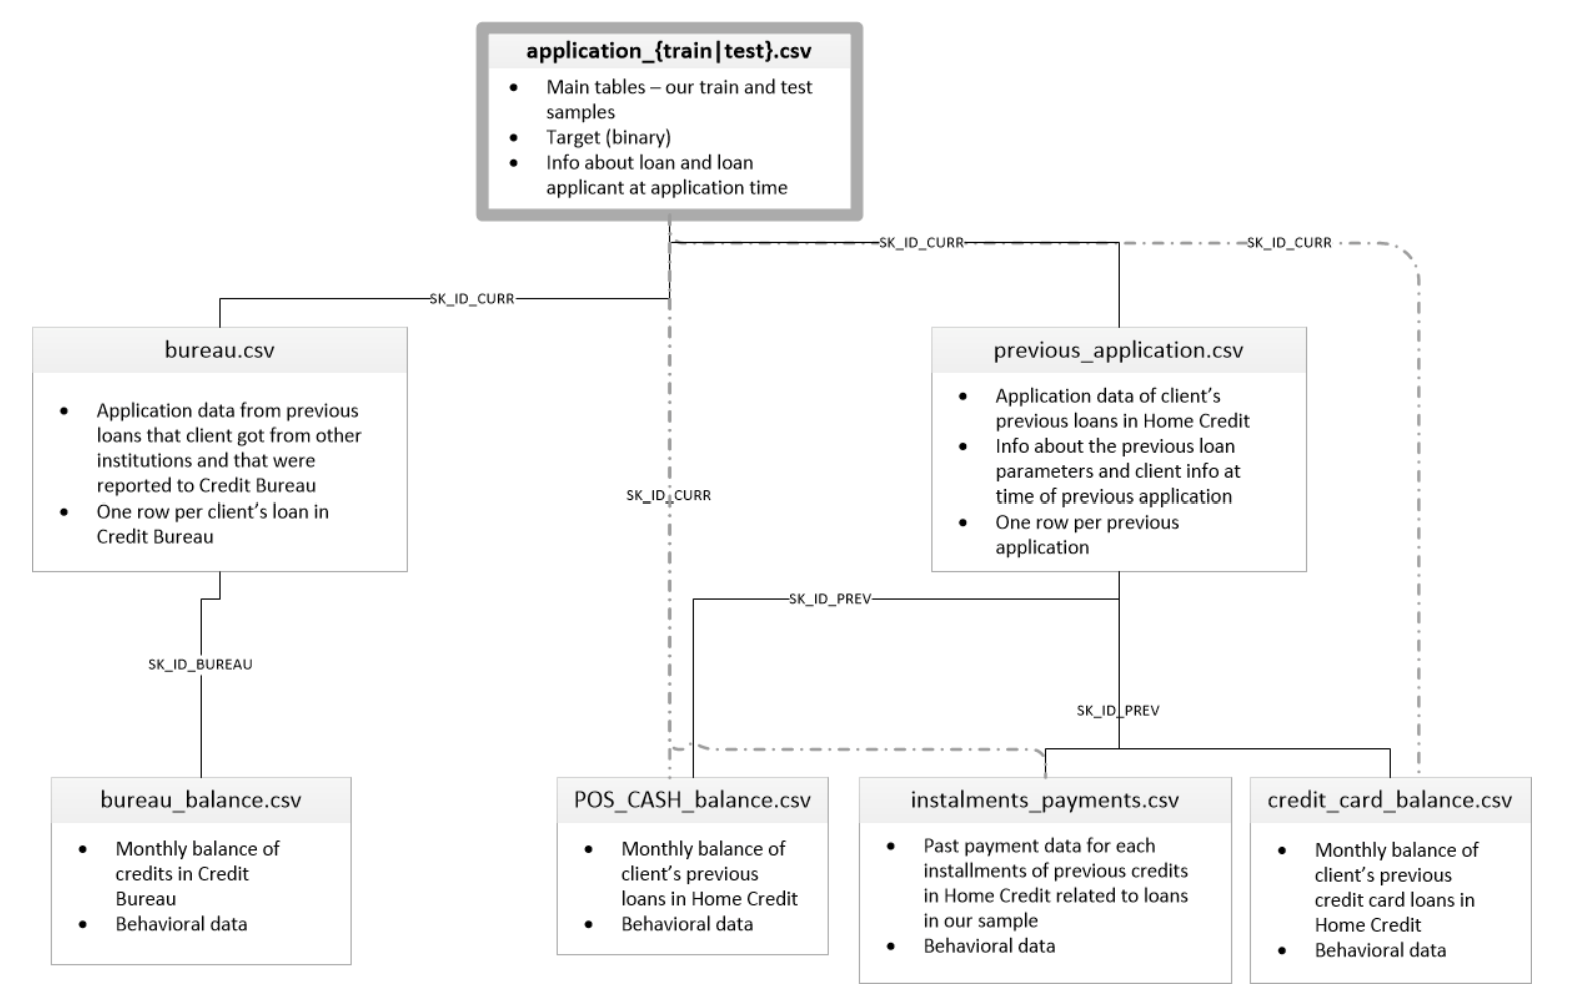

In [2]:
# Operative system
import os, shutil

# Warnings 
import warnings

# time
import time, datetime

# Math
import numpy as np

# Data
import pandas as pd

# Regex
import re

# Casting
import ast

# CSV (comma separated values)
import csv

# Garbage collector
import gc

# Graphics
import matplotlib.pyplot as plt
import seaborn as sns

# Model selection
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, StratifiedKFold

# Preprocessing
from sklearn.preprocessing import LabelEncoder, StandardScaler, PolynomialFeatures

# Imputation
from sklearn.impute import SimpleImputer

# Metrics
from sklearn.metrics import accuracy_score, roc_curve, auc, roc_auc_score, confusion_matrix, make_scorer

# Models
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from imblearn.ensemble import BalancedRandomForestClassifier
from lightgbm import LGBMClassifier

# Pipeline
from sklearn.pipeline import Pipeline

import mlflow
from mlflow.models.signature import infer_signature
import mlflow.sklearn

# URL handling modules
from urllib.parse import urlparse

# Object serializer
import pickle

# Dimensions reduction
from sklearn.decomposition import PCA

# Feature importance
import shap

# Evidently (data drift)
#from evidently import ColumnMapping
from evidently.report import Report

from evidently.metric_preset import DataDriftPreset #, TargetDriftPreset, DataQualityPreset, RegressionPreset

C:\Users\alexa\anaconda3\envs\envmlflow2\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Warnings suppression
warnings.filterwarnings('ignore')
# warnings.simplefilter(action='ignore', category=FutureWarning)

Basic function

In [4]:
from contextlib import contextmanager

# Set starting time of a given process (time to be used in calc_time, print_time and script_exec_time functions; see below)
def set_start():
    return time.time()

# Timer function from https://www.kaggle.com/code/jsaguiar/lightgbm-with-simple-features/script
@contextmanager
def timer(title):
    t0 = time.time()
    yield
    print("{} - done in {:.0f}s".format(title, time.time() - t0))
    
# Visualize the description of a given column
def get_col_desc(col, table='application_{train|test}.csv', ret=False):
    df_temp = df_HomeCredit_columns_description.loc[df_HomeCredit_columns_description['Row'] == col]
    if(df_temp.shape[0]<1):
        desc = f"{col}: not in the original dataset(s)."
    else:
        if(table!=None):
            df_temp = df_temp.loc[df_temp['Table'] == table]
        desc = df_temp['Description'].values[0]
        desc = f"{col} [{table}]: {desc}"
    if(ret):
        return desc
    else:
        print(desc)
        
# Prints (or returns) he result of a process, including its duration (needs either a duration time calculated by calc_time funtion, or a starting time set by set_start function; see above)
def print_time(text, start_time=None, ela_time=None, r=0, label='[ela_time]', print_res=True):
    if(ela_time==None):
        ela_time = calc_time(start_time, r)
    ela_time_str = str(ela_time)
    res = text.replace(label, ela_time_str)
    if(print_res):
        print(res)
    else:
        return res
    
# Raturns a calculated time interval (needs a starting time set by set_start function; see above)
def calc_time(start_time, r=0):
    end_time = time.time()
    ela_time = round(end_time - start_time, r)
    return ela_time

# Returns the current date + time in a customizable format (default: 00/00/0000 00:00:00)
def get_date_time(dt_format="%d/%m/%Y %H:%M:%S"):
    dt = datetime.datetime.now()
    dt_str = dt.strftime(dt_format)
    return dt_str

# Makes a folder empty (if it is not)
def empty_folder(folder):
    for filename in os.listdir(folder):
        file_path = os.path.join(folder, filename)
        try:
            if os.path.isfile(file_path) or os.path.islink(file_path):
                os.unlink(file_path)
            elif os.path.isdir(file_path):
                shutil.rmtree(file_path)
        except Exception as e:
            print('Failed to delete %s. Reason: %s' % (file_path, e))

In [5]:
# Script execution start time
script_start_time = set_start()

In [6]:
# Paths definition
data_path = './data/'
source_data_path = data_path + 'source/'
cleaned_data_path = data_path + 'cleaned/'
calc_path = './calc/' # Stored GridSearchCV results and predictions
model_path = './models'

## 0.1 Import data

Kaggle competition : https://www.kaggle.com/c/home-credit-default-risk/data

In [7]:
# Datasets import
def create_df(filename, path=source_data_path):
    path = path + filename
    with open(path, newline='') as csvfile:
        reader = csv.reader(csvfile, delimiter=',', quotechar='"')
        header = True
        i = 0
        for row in reader:
            if(header):
                df = pd.DataFrame(columns=row)
                header = False
            else:
                df.loc[-1] = row
                df.index = df.index + 1
            i += 1
        idx = np.arange(i-1)
        df.index = idx
        df = df.iloc[:,1:]
    csvfile.close()
    return df

In [8]:
# Datasets load
skip = [5]
dir_list = os.listdir(source_data_path)
df_name_list = []
n_files = len(dir_list)
print(f"{n_files} datasets have been loaded:\n")
for n in range(0,n_files):
    dyn_var_name = dir_list[n]
    dyn_var_name = 'df_' + dyn_var_name[:-4]
    if(n not in skip):
        globals()[dyn_var_name] = pd.read_csv(source_data_path + dir_list[n])
    else:
        globals()[dyn_var_name] = create_df(dir_list[n], source_data_path)
    shape = globals()[dyn_var_name].shape
    df_name_list.append(dyn_var_name)
    print(f" {n+1}) {dyn_var_name} {shape}")

10 datasets have been loaded:

 1) df_application_test (48744, 121)
 2) df_application_train (307511, 122)
 3) df_bureau (1716428, 17)
 4) df_bureau_balance (27299925, 3)
 5) df_credit_card_balance (3840312, 23)
 6) df_HomeCredit_columns_description (219, 4)
 7) df_installments_payments (13605401, 8)
 8) df_POS_CASH_balance (10001358, 8)
 9) df_previous_application (1670214, 37)
 10) df_sample_submission (48744, 2)


# 1. General Overview

In [9]:
for df_name in df_name_list:
    print(df_name)
    print(globals()[df_name].head())

df_application_test
   SK_ID_CURR NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR FLAG_OWN_REALTY  \
0      100001         Cash loans           F            N               Y   
1      100005         Cash loans           M            N               Y   
2      100013         Cash loans           M            Y               Y   
3      100028         Cash loans           F            N               Y   
4      100038         Cash loans           M            Y               N   

   CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0             0          135000.0    568800.0      20560.5         450000.0   
1             0           99000.0    222768.0      17370.0         180000.0   
2             0          202500.0    663264.0      69777.0         630000.0   
3             2          315000.0   1575000.0      49018.5        1575000.0   
4             1          180000.0    625500.0      32067.0         625500.0   

   ... FLAG_DOCUMENT_18 FLAG_DOCUMENT_19 F

In [10]:
# Setting target label
target = 'TARGET'

# 2. EDA

For the EDA steps we will get inspired by the following 2 kernels:

https://www.kaggle.com/code/willkoehrsen/start-here-a-gentle-introduction/notebook: This notebook is intended for those who are new to machine learning competitions or want a gentle introduction to the problem.

https://www.kaggle.com/code/jsaguiar/lightgbm-with-simple-features/script: A simple aprroach with data cleaning, aggregations and merging.

## 2.1 Cleaning & Preprocessing & Merging

In [11]:
# One-hot encoding for categorical columns with get_dummies
def one_hot_encoder(df, nan_as_category = True):
    original_columns = list(df.columns)
    categorical_columns = [col for col in df.columns if df[col].dtype=='object']
    df = pd.get_dummies(df, columns= categorical_columns, dummy_na=nan_as_category)
    new_columns = [c for c in df.columns if c not in original_columns]
    return df, new_columns

# Preprocess application_train.csv and application_test.csv
def application_train_test(n_rows=None, nan_as_category=False):
    # Read data and merge
    df = df_application_train.iloc[:n_rows,:]
    test_df = df_application_test.iloc[:n_rows,:]
    print("Train samples: {}, test samples: {}".format(len(df), len(test_df)))
    df = df._append(test_df).reset_index()
    # Optional: Remove 4 applications with XNA CODE_GENDER (train set)
    df = df[df['CODE_GENDER'] != 'XNA']
    
    # Categorical features with Binary encode (0 or 1; two categories)
    for bin_feature in ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY']:
        df[bin_feature], uniques = pd.factorize(df[bin_feature])
    # Categorical features with One-Hot encode
    df, cat_cols = one_hot_encoder(df, nan_as_category)
    
    # "DAYS" variable conversion to positive
    days_cols = ['DAYS_BIRTH', 
                 'DAYS_EMPLOYED', 
                 'DAYS_REGISTRATION', 
                 'DAYS_ID_PUBLISH',
                 'DAYS_LAST_PHONE_CHANGE']
    for col in days_cols:
        df[col] = abs(df[col])
    
    # NaN values for DAYS_EMPLOYED: 365.243 -> nan
    df['DAYS_EMPLOYED'].replace(365243, np.nan, inplace= True)
    # Some simple new features (percentages)
    df['DAYS_EMPLOYED_PERC'] = df['DAYS_EMPLOYED'] / df['DAYS_BIRTH']
    df['INCOME_CREDIT_PERC'] = df['AMT_INCOME_TOTAL'] / df['AMT_CREDIT']
    df['INCOME_PER_PERSON'] = df['AMT_INCOME_TOTAL'] / df['CNT_FAM_MEMBERS']
    df['ANNUITY_INCOME_PERC'] = df['AMT_ANNUITY'] / df['AMT_INCOME_TOTAL']
    df['PAYMENT_RATE'] = df['AMT_ANNUITY'] / df['AMT_CREDIT']
    del test_df
    gc.collect()
    return df

# Preprocess bureau.csv and bureau_balance.csv
def bureau_and_balance(n_rows=None, nan_as_category=True):
    bureau = df_bureau.iloc[:n_rows,:]
    bb = df_bureau_balance.iloc[:n_rows,:]
    bb, bb_cat = one_hot_encoder(bb, nan_as_category)
    bureau, bureau_cat = one_hot_encoder(bureau, nan_as_category)
    
    # Bureau balance: Perform aggregations and merge with bureau.csv
    bb_aggregations = {'MONTHS_BALANCE': ['min', 'max', 'size']}
    for col in bb_cat:
        bb_aggregations[col] = ['mean']
    bb_agg = bb.groupby('SK_ID_BUREAU').agg(bb_aggregations)
    bb_agg.columns = pd.Index([e[0] + "_" + e[1].upper() for e in bb_agg.columns.tolist()])
    bureau = bureau.join(bb_agg, how='left', on='SK_ID_BUREAU')
    bureau.drop(['SK_ID_BUREAU'], axis=1, inplace= True)
    del bb, bb_agg
    gc.collect()
    
    # Bureau and bureau_balance numeric features
    num_aggregations = {
        'DAYS_CREDIT': ['min', 'max', 'mean', 'var'],
        'DAYS_CREDIT_ENDDATE': ['min', 'max', 'mean'],
        'DAYS_CREDIT_UPDATE': ['mean'],
        'CREDIT_DAY_OVERDUE': ['max', 'mean'],
        'AMT_CREDIT_MAX_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_DEBT': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM_LIMIT': ['mean', 'sum'],
        'AMT_ANNUITY': ['max', 'mean'],
        'CNT_CREDIT_PROLONG': ['sum'],
        'MONTHS_BALANCE_MIN': ['min'],
        'MONTHS_BALANCE_MAX': ['max'],
        'MONTHS_BALANCE_SIZE': ['mean', 'sum']
    }
    
    # Bureau and bureau_balance categorical features
    cat_aggregations = {}
    for cat in bureau_cat: cat_aggregations[cat] = ['mean']
    for cat in bb_cat: cat_aggregations[cat + "_MEAN"] = ['mean']
    
    bureau_agg = bureau.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
    bureau_agg.columns = pd.Index(['BURO_' + e[0] + "_" + e[1].upper() for e in bureau_agg.columns.tolist()])
    # Bureau: Active credits - using only numerical aggregations
    active = bureau[bureau['CREDIT_ACTIVE_Active'] == 1]
    active_agg = active.groupby('SK_ID_CURR').agg(num_aggregations)
    active_agg.columns = pd.Index(['ACTIVE_' + e[0] + "_" + e[1].upper() for e in active_agg.columns.tolist()])
    bureau_agg = bureau_agg.join(active_agg, how='left', on='SK_ID_CURR')
    del active, active_agg
    gc.collect()
    # Bureau: Closed credits - using only numerical aggregations
    closed = bureau[bureau['CREDIT_ACTIVE_Closed'] == 1]
    closed_agg = closed.groupby('SK_ID_CURR').agg(num_aggregations)
    closed_agg.columns = pd.Index(['CLOSED_' + e[0] + "_" + e[1].upper() for e in closed_agg.columns.tolist()])
    bureau_agg = bureau_agg.join(closed_agg, how='left', on='SK_ID_CURR')
    del closed, closed_agg, bureau
    gc.collect()
    return bureau_agg

# Preprocess previous_applications.csv
def previous_applications(n_rows=None, nan_as_category=True):
    prev = df_previous_application.iloc[:n_rows,:]
    prev, cat_cols = one_hot_encoder(prev, nan_as_category= True)
    # Days 365.243 values -> nan
    prev['DAYS_FIRST_DRAWING'].replace(365243, np.nan, inplace= True)
    prev['DAYS_FIRST_DUE'].replace(365243, np.nan, inplace= True)
    prev['DAYS_LAST_DUE_1ST_VERSION'].replace(365243, np.nan, inplace= True)
    prev['DAYS_LAST_DUE'].replace(365243, np.nan, inplace= True)
    prev['DAYS_TERMINATION'].replace(365243, np.nan, inplace= True)
    # Add feature: value ask / value received percentage
    prev['APP_CREDIT_PERC'] = prev['AMT_APPLICATION'] / prev['AMT_CREDIT']
    # Previous applications numeric features
    num_aggregations = {
        'AMT_ANNUITY': ['min', 'max', 'mean'],
        'AMT_APPLICATION': ['min', 'max', 'mean'],
        'AMT_CREDIT': ['min', 'max', 'mean'],
        'APP_CREDIT_PERC': ['min', 'max', 'mean', 'var'],
        'AMT_DOWN_PAYMENT': ['min', 'max', 'mean'],
        'AMT_GOODS_PRICE': ['min', 'max', 'mean'],
        'HOUR_APPR_PROCESS_START': ['min', 'max', 'mean'],
        'RATE_DOWN_PAYMENT': ['min', 'max', 'mean'],
        'DAYS_DECISION': ['min', 'max', 'mean'],
        'CNT_PAYMENT': ['mean', 'sum'],
    }
    # Previous applications categorical features
    cat_aggregations = {}
    for cat in cat_cols:
        cat_aggregations[cat] = ['mean']
    
    prev_agg = prev.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
    prev_agg.columns = pd.Index(['PREV_' + e[0] + "_" + e[1].upper() for e in prev_agg.columns.tolist()])
    # Previous Applications: Approved Applications - only numerical features
    approved = prev[prev['NAME_CONTRACT_STATUS_Approved'] == 1]
    approved_agg = approved.groupby('SK_ID_CURR').agg(num_aggregations)
    approved_agg.columns = pd.Index(['APPROVED_' + e[0] + "_" + e[1].upper() for e in approved_agg.columns.tolist()])
    prev_agg = prev_agg.join(approved_agg, how='left', on='SK_ID_CURR')
    # Previous Applications: Refused Applications - only numerical features
    refused = prev[prev['NAME_CONTRACT_STATUS_Refused'] == 1]
    refused_agg = refused.groupby('SK_ID_CURR').agg(num_aggregations)
    refused_agg.columns = pd.Index(['REFUSED_' + e[0] + "_" + e[1].upper() for e in refused_agg.columns.tolist()])
    prev_agg = prev_agg.join(refused_agg, how='left', on='SK_ID_CURR')
    del refused, refused_agg, approved, approved_agg, prev
    gc.collect()
    return prev_agg

# Preprocess POS_CASH_balance.csv
def pos_cash(n_rows=None, nan_as_category=True):
    pos = df_POS_CASH_balance.iloc[:n_rows,:]
    pos, cat_cols = one_hot_encoder(pos, nan_as_category=True)
    # Features
    aggregations = {
        'MONTHS_BALANCE': ['max', 'mean', 'size'],
        'SK_DPD': ['max', 'mean'],
        'SK_DPD_DEF': ['max', 'mean']
    }
    for cat in cat_cols:
        aggregations[cat] = ['mean']
    
    pos_agg = pos.groupby('SK_ID_CURR').agg(aggregations)
    pos_agg.columns = pd.Index(['POS_' + e[0] + "_" + e[1].upper() for e in pos_agg.columns.tolist()])
    # Count pos cash accounts
    pos_agg['POS_COUNT'] = pos.groupby('SK_ID_CURR').size()
    del pos
    gc.collect()
    return pos_agg
    
# Preprocess installments_payments.csv
def installments_payments(n_rows=None, nan_as_category=True):
    ins = df_installments_payments.iloc[:n_rows,:]
    ins, cat_cols = one_hot_encoder(ins, nan_as_category=True)
    # Percentage and difference paid in each installment (amount paid and installment value)
    ins['PAYMENT_PERC'] = ins['AMT_PAYMENT'] / ins['AMT_INSTALMENT']
    ins['PAYMENT_DIFF'] = ins['AMT_INSTALMENT'] - ins['AMT_PAYMENT']
    # Days past due and days before due (no negative values)
    ins['DPD'] = ins['DAYS_ENTRY_PAYMENT'] - ins['DAYS_INSTALMENT']
    ins['DBD'] = ins['DAYS_INSTALMENT'] - ins['DAYS_ENTRY_PAYMENT']
    ins['DPD'] = ins['DPD'].apply(lambda x: x if x > 0 else 0)
    ins['DBD'] = ins['DBD'].apply(lambda x: x if x > 0 else 0)
    # Features: Perform aggregations
    aggregations = {
        'NUM_INSTALMENT_VERSION': ['nunique'],
        'DPD': ['max', 'mean', 'sum'],
        'DBD': ['max', 'mean', 'sum'],
        'PAYMENT_PERC': ['max', 'mean', 'sum', 'var'],
        'PAYMENT_DIFF': ['max', 'mean', 'sum', 'var'],
        'AMT_INSTALMENT': ['max', 'mean', 'sum'],
        'AMT_PAYMENT': ['min', 'max', 'mean', 'sum'],
        'DAYS_ENTRY_PAYMENT': ['max', 'mean', 'sum']
    }
    for cat in cat_cols:
        aggregations[cat] = ['mean']
    ins_agg = ins.groupby('SK_ID_CURR').agg(aggregations)
    ins_agg.columns = pd.Index(['INSTAL_' + e[0] + "_" + e[1].upper() for e in ins_agg.columns.tolist()])
    # Count installments accounts
    ins_agg['INSTAL_COUNT'] = ins.groupby('SK_ID_CURR').size()
    del ins
    gc.collect()
    return ins_agg

# Preprocess credit_card_balance.csv
def credit_card_balance(n_rows=None, nan_as_category=True):
    cc = df_credit_card_balance.iloc[:n_rows,:]
    cc, cat_cols = one_hot_encoder(cc, nan_as_category= True)
    # General aggregations
    cc.drop(['SK_ID_PREV'], axis= 1, inplace = True)
    cc_agg = cc.groupby('SK_ID_CURR').agg(['min', 'max', 'mean', 'sum', 'var'])
    cc_agg.columns = pd.Index(['CC_' + e[0] + "_" + e[1].upper() for e in cc_agg.columns.tolist()])
    # Count credit card lines
    cc_agg['CC_COUNT'] = cc.groupby('SK_ID_CURR').size()
    del cc
    gc.collect()
    return cc_agg

In [12]:
def merge_and_preprocess(debug=False):

    if(debug):
        n_rows = 1000
    else: n_rows = None

    df = application_train_test(n_rows)

    with timer("Process bureau and bureau_balance"):
        bureau = bureau_and_balance(n_rows)
        print("Bureau df shape:", bureau.shape)
        df = df.join(bureau, how='left', on='SK_ID_CURR')
        del bureau
        gc.collect()
    with timer("Process previous_applications"):
        prev = previous_applications(n_rows)
        print("Previous applications df shape:", prev.shape)
        df = df.join(prev, how='left', on='SK_ID_CURR')
        del prev
        gc.collect()
    with timer("Process POS-CASH balance"):
        pos = pos_cash(n_rows)
        print("Pos-cash balance df shape:", pos.shape)
        df = df.join(pos, how='left', on='SK_ID_CURR')
        del pos
        gc.collect()
    with timer("Process installments payments"):
        ins = installments_payments(n_rows)
        print("Installments payments df shape:", ins.shape)
        df = df.join(ins, how='left', on='SK_ID_CURR')
        del ins
        gc.collect()
    with timer("Process credit card balance"):
        cc = credit_card_balance(n_rows)
        print("Credit card balance df shape:", cc.shape)
        df = df.join(cc, how='left', on='SK_ID_CURR')
        del cc
        gc.collect()
    
    df.drop(columns='index', inplace=True)
    
    return df

In [13]:
# Getting a preprocessed and merged dataset
df = merge_and_preprocess()

Train samples: 307511, test samples: 48744
Bureau df shape: (305811, 116)
Process bureau and bureau_balance - done in 16s
Previous applications df shape: (338857, 249)
Process previous_applications - done in 18s
Pos-cash balance df shape: (337252, 18)
Process POS-CASH balance - done in 7s
Installments payments df shape: (339587, 26)
Process installments payments - done in 16s
Credit card balance df shape: (103558, 141)
Process credit card balance - done in 13s


In [14]:
# Dataframe shape after merging
print(df.shape)

(356251, 797)


## 2.2 Missing values

In [15]:
# Calculate missing values, in terms of absolute values and percentage
def missing_value(df, print_res=True, ret=True, include_0_mv=False):
        
    df_temp   = df.isna().sum()
    n_rows    = df.shape[0]
    n_col     = df.shape[1]
    df_n_null = df.isna().sum().sum()
    cols = ['column', 'n_miss', '%_miss']
    df_null = pd.DataFrame(columns=cols)
    df_null['column'] = df_temp.index
    df_null['n_miss'] = df_temp.values
    df_null['%_miss'] = round(df_null['n_miss'] / n_rows, 1) * 100
    df_null = df_null.loc[df_null['n_miss'] > 0].sort_values('n_miss', ascending=False)
    n_col_miss = df_null.shape[0]
    
    if(include_0_mv==False):
        df_null = df_null.loc[df_null['%_miss'] > 0]
        
    if(print_res):
        res  = f"The dataframe contains {df_n_null} missing values. "
        res += f"{n_col_miss} of {n_col} columns contain missing values."
        print(res)
    
    if(ret):
        return df_null

In [16]:
# Missing values in the training set
df_miss = missing_value(df)
df_miss

The dataframe contains 72099941 missing values. 617 of 797 columns contain missing values.


column  n_miss  %_miss
605   REFUSED_RATE_DOWN_PAYMENT_MAX  303648    90.0
604   REFUSED_RATE_DOWN_PAYMENT_MIN  303648    90.0
606  REFUSED_RATE_DOWN_PAYMENT_MEAN  303648    90.0
595    REFUSED_AMT_DOWN_PAYMENT_MIN  303648    90.0
596    REFUSED_AMT_DOWN_PAYMENT_MAX  303648    90.0
..                              ...     ...     ...
379        PREV_AMT_GOODS_PRICE_MIN   18462    10.0
363            PREV_AMT_ANNUITY_MIN   17878    10.0
364            PREV_AMT_ANNUITY_MAX   17878    10.0
365           PREV_AMT_ANNUITY_MEAN   17878    10.0
391           PREV_CNT_PAYMENT_MEAN   17876    10.0

[404 rows x 3 columns]

In [17]:
# plot missing values percentage
def plot_miss(df, treshold=0.3, height=120):
    
    plt.figure(figsize=(12,height))
    sns.barplot(data=df.sort_values('%_miss', ascending=False), x='%_miss', y='column', palette='ch:s=.25,rot=-.25')
    plt.title(f"Missing values (%) for each column")
    plt.xlabel("Missing values (%)")
    plt.ylabel("Column")
    plt.axvline(x=100*treshold, linewidth=2, color = 'r')
    plt.show()

As sugjested in the given notebooks, we will take a treshold of 0.75

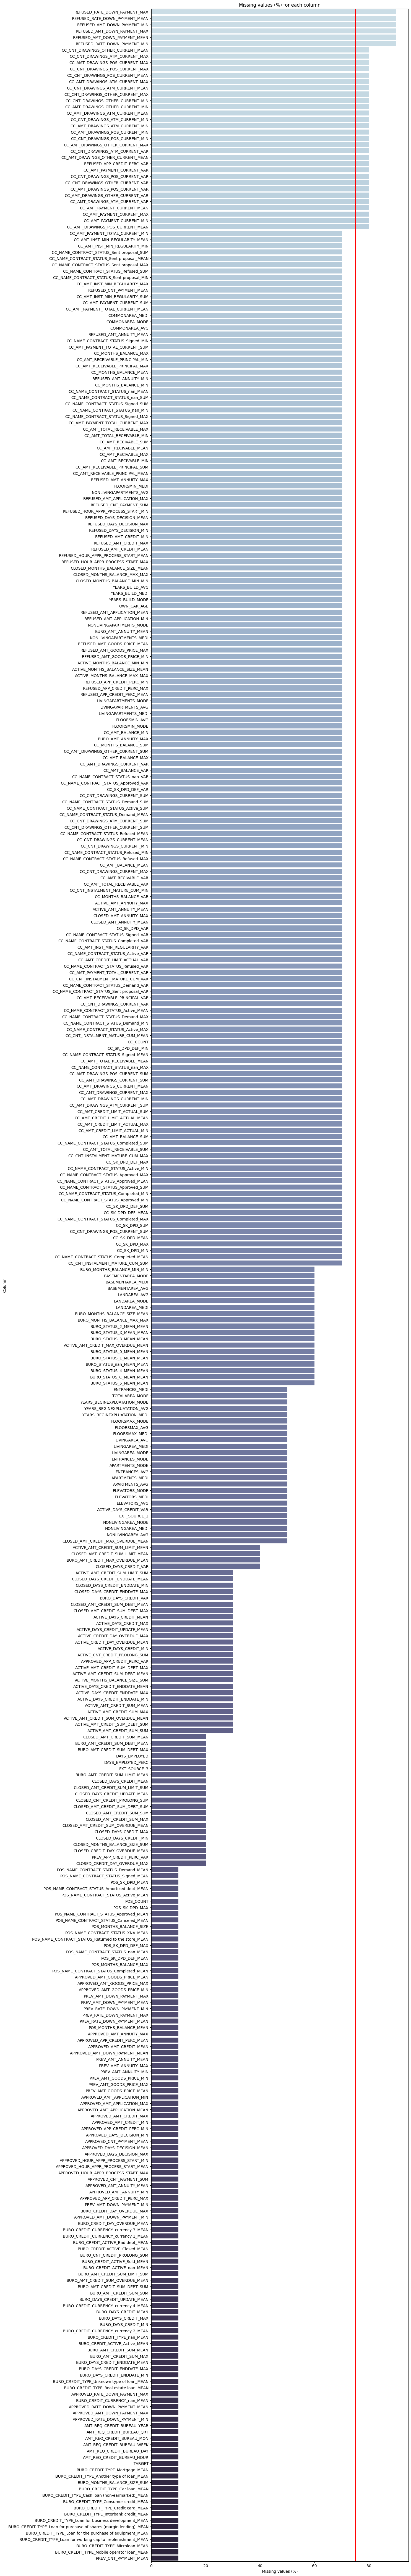

In [18]:
treshold = 0.75

# Plot missing values in the training set
plot_miss(df_miss, treshold)

In [19]:
cols_to_drop = df_miss.loc[df_miss['%_miss'] > treshold * 100, 'column']
df = df.drop(columns=cols_to_drop)
print(df.shape)

(356251, 762)


### 2.1.1 Missing values: imputation

In [20]:
df[target].unique()

array([ 1.,  0., nan])

In [21]:
# Target imputation (testing set: target = 2)(2 is simply used as a marker to identify rows from testing set)
df[target] = df[target].fillna(2)
df[target] = df[target].astype(int)

Now we can start imputing depending on our variables types

In [22]:
df.dtypes.value_counts()

float64    570
bool       133
int64       42
object      16
int32        1
Name: count, dtype: int64

In [23]:
# Getting name list of quantitative and qualitative variables
quanti_cols = df.select_dtypes(['float64']).columns
quali_cols = df.select_dtypes(df.dtypes.value_counts().iloc[1:].index.tolist()).columns

In [24]:
# Aggregation columns imputing
cols_agg = df.columns[df.columns.str.contains('_MIN|_MAX|_MEAN|_VAR|_SUM|_SIZE')]
df[cols_agg] = df[cols_agg].fillna(0.0)

In [25]:
# Impute missing values of a given dataset
def impute(df, cols, var_type):
    
    if(var_type=='qualitative'):
        strat = 'most_frequent'
    else:
        strat = 'median'
        
    cols = df[cols].isna().sum().loc[df[cols].isna().sum() > 0].index.tolist()
    n_cols = len(cols)
    if(n_cols>0):
        imputer = SimpleImputer(strategy=strat)
        imputed_values = imputer.fit_transform(df[cols])
        df[cols] = pd.DataFrame(imputed_values)
        res = f"Empty values of {n_cols} columns ({var_type} variables) have been imputed (strategy: {strat})."
    else:
        res = f"There were no empty values to impute ({var_type} variables)."
        
    print(res)
    return df

In [26]:
# Missing values imputation
df = impute(df, quanti_cols, var_type='quantitative')
df = impute(df, quali_cols, var_type='qualitative')

missing_value(df, print_res=True, ret=False)

Empty values of 70 columns (quantitative variables) have been imputed (strategy: median).
There were no empty values to impute (qualitative variables).
The dataframe contains 280 missing values. 70 of 762 columns contain missing values.


## 2.3 Outliers

In [27]:
df.describe()

SK_ID_CURR         TARGET    CODE_GENDER   FLAG_OWN_CAR  \
count  356251.000000  356251.000000  356251.000000  356251.000000   
mean   278128.870078       0.343334       0.660001       0.339699   
std    102842.068890       0.706475       0.473709       0.473608   
min    100001.000000       0.000000       0.000000       0.000000   
25%    189065.500000       0.000000       0.000000       0.000000   
50%    278129.000000       0.000000       1.000000       0.000000   
75%    367192.500000       0.000000       1.000000       1.000000   
max    456255.000000       2.000000       1.000000       1.000000   

       FLAG_OWN_REALTY   CNT_CHILDREN  AMT_INCOME_TOTAL    AMT_CREDIT  \
count    356251.000000  356251.000000      3.562510e+05  3.562510e+05   
mean          0.306764       0.414312      1.701159e+05  5.877695e+05   
std           0.461151       0.720376      2.235080e+05  3.986253e+05   
min           0.000000       0.000000      2.565000e+04  4.500000e+04   
25%           0.000000       0.000000      1.125000e+05  2.700000e+05   
50%           0.000000       0.000000      1.530000e+05  5.002110e+05   
75%           1.000000       1.000000      2.025000e+05  7.975575e+05   
max           1.000000      20.000000      1.170000e+08  4.050000e+06   

         AMT_ANNUITY  AMT_GOODS_PRICE  ...  \
count  356247.000000     3.562470e+05  ...   
mean    27425.411831     5.279580e+05  ...   
std     14732.201739     3.659299e+05  ...   
min      1615.500000     4.050000e+04  ...   
25%     16731.000000     2.340000e+05  ...   
50%     25078.500000     4.500000e+05  ...   
75%     34960.500000     6.750000e+05  ...   
max    258025.500000     4.050000e+06  ...   

       CC_NAME_CONTRACT_STATUS_Sent proposal_MEAN  \
count                               356251.000000   
mean                                     0.000017   
std                                      0.000457   
min                                      0.000000   
25%                                      0.000000   
50%                                      0.000000   
75%                                      0.000000   
max                                      0.024390   

       CC_NAME_CONTRACT_STATUS_Sent proposal_SUM  \
count                               356251.00000   
mean                                     0.00144   
std                                      0.03792   
min                                      0.00000   
25%                                      0.00000   
50%                                      0.00000   
75%                                      0.00000   
max                                      1.00000   

       CC_NAME_CONTRACT_STATUS_Sent proposal_VAR  \
count                              356251.000000   
mean                                    0.000017   
std                                     0.000457   
min                                     0.000000   
25%                                     0.000000   
50%                                     0.000000   
75%                                     0.000000   
max                                     0.024390   

       CC_NAME_CONTRACT_STATUS_Signed_MEAN  \
count                        356251.000000   
mean                              0.001042   
std                               0.016801   
min                               0.000000   
25%                               0.000000   
50%                               0.000000   
75%                               0.000000   
max                               1.000000   

       CC_NAME_CONTRACT_STATUS_Signed_SUM  CC_NAME_CONTRACT_STATUS_Signed_VAR  \
count                       356251.000000                       356251.000000   
mean                             0.031040                            0.000853   
std                              0.687796                            0.010797   
min                              0.000000                            0.000000   
25%                              0.000000                            0.000000  

### 2.3.1. Negative values

In [28]:
# Check columns with negative values in a given dataframe
def check_neg(df, print_res=True, ret=True):
    df_neg = df.select_dtypes(include=np.number)
    neg_cols = []
    for col in df_neg.columns:
        if(df_neg[col].min() < 0):
            neg_cols.append(col)
    df_neg = df_neg[neg_cols]
    n_neg_cols = len(neg_cols)
    if(print_res):
        sep = ', '
        res  = f"In the dataset set there are {n_neg_cols} columns with negative values: "
        res += sep.join(neg_cols) + '.'
        print(res)
    if(ret):
        return df_neg

In [29]:
# Check negative values in training set
df_neg = check_neg(df)

In the dataset set there are 87 columns with negative values: REGION_RATING_CLIENT_W_CITY, BURO_DAYS_CREDIT_MIN, BURO_DAYS_CREDIT_MAX, BURO_DAYS_CREDIT_MEAN, BURO_DAYS_CREDIT_ENDDATE_MIN, BURO_DAYS_CREDIT_ENDDATE_MAX, BURO_DAYS_CREDIT_ENDDATE_MEAN, BURO_DAYS_CREDIT_UPDATE_MEAN, BURO_AMT_CREDIT_SUM_DEBT_MAX, BURO_AMT_CREDIT_SUM_DEBT_MEAN, BURO_AMT_CREDIT_SUM_DEBT_SUM, BURO_AMT_CREDIT_SUM_LIMIT_MEAN, BURO_AMT_CREDIT_SUM_LIMIT_SUM, BURO_MONTHS_BALANCE_MIN_MIN, BURO_MONTHS_BALANCE_MAX_MAX, ACTIVE_DAYS_CREDIT_MIN, ACTIVE_DAYS_CREDIT_MAX, ACTIVE_DAYS_CREDIT_MEAN, ACTIVE_DAYS_CREDIT_ENDDATE_MIN, ACTIVE_DAYS_CREDIT_ENDDATE_MAX, ACTIVE_DAYS_CREDIT_ENDDATE_MEAN, ACTIVE_DAYS_CREDIT_UPDATE_MEAN, ACTIVE_AMT_CREDIT_SUM_DEBT_MAX, ACTIVE_AMT_CREDIT_SUM_DEBT_MEAN, ACTIVE_AMT_CREDIT_SUM_DEBT_SUM, ACTIVE_AMT_CREDIT_SUM_LIMIT_MEAN, ACTIVE_AMT_CREDIT_SUM_LIMIT_SUM, ACTIVE_MONTHS_BALANCE_MIN_MIN, ACTIVE_MONTHS_BALANCE_MAX_MAX, CLOSED_DAYS_CREDIT_MIN, CLOSED_DAYS_CREDIT_MAX, CLOSED_DAYS_CREDIT_MEAN, CLOSED_D

In [30]:
# Description of columns with negative values (training set)
for col in df_neg.columns:
    get_col_desc(col, ret=False)

REGION_RATING_CLIENT_W_CITY [application_{train|test}.csv]: Our rating of the region where client lives with taking city into account (1,2,3)
BURO_DAYS_CREDIT_MIN: not in the original dataset(s).
BURO_DAYS_CREDIT_MAX: not in the original dataset(s).
BURO_DAYS_CREDIT_MEAN: not in the original dataset(s).
BURO_DAYS_CREDIT_ENDDATE_MIN: not in the original dataset(s).
BURO_DAYS_CREDIT_ENDDATE_MAX: not in the original dataset(s).
BURO_DAYS_CREDIT_ENDDATE_MEAN: not in the original dataset(s).
BURO_DAYS_CREDIT_UPDATE_MEAN: not in the original dataset(s).
BURO_AMT_CREDIT_SUM_DEBT_MAX: not in the original dataset(s).
BURO_AMT_CREDIT_SUM_DEBT_MEAN: not in the original dataset(s).
BURO_AMT_CREDIT_SUM_DEBT_SUM: not in the original dataset(s).
BURO_AMT_CREDIT_SUM_LIMIT_MEAN: not in the original dataset(s).
BURO_AMT_CREDIT_SUM_LIMIT_SUM: not in the original dataset(s).
BURO_MONTHS_BALANCE_MIN_MIN: not in the original dataset(s).
BURO_MONTHS_BALANCE_MAX_MAX: not in the original dataset(s).
ACTIVE_DAY

The only column with negative values, which was in the original files, is REGION_RATING_CLIENT_W_CITY, whose negative values have to be considered as errors (see the column description).

In [31]:
df.loc[df['REGION_RATING_CLIENT_W_CITY'] < 0, 'REGION_RATING_CLIENT_W_CITY']

324688   -1
Name: REGION_RATING_CLIENT_W_CITY, dtype: int64

As clearly explained in the column description, REGION_RATING_CLIENT_W_CITY is supposed to have, as value, 1, 2 or 3. Therefore, we will just take the absolute value of this outlier.

In [32]:
df.loc[df['REGION_RATING_CLIENT_W_CITY'] < 0, 
          'REGION_RATING_CLIENT_W_CITY'] = abs(df['REGION_RATING_CLIENT_W_CITY'])

### 2.3.2 Infite value

In [33]:
# Create a dataframe with the rows containing columns with values = (-)infinite
col = 'n_inf_values'
df_inf = pd.DataFrame(df.isin([np.inf, -np.inf]).sum(), columns=[col])
df_inf = df_inf.loc[df_inf[col] != 0]
df_inf

n_inf_values
PREV_APP_CREDIT_PERC_MAX                 1
PREV_APP_CREDIT_PERC_MEAN                1
REFUSED_APP_CREDIT_PERC_MAX              1
REFUSED_APP_CREDIT_PERC_MEAN             1
INSTAL_PAYMENT_PERC_MAX                 19
INSTAL_PAYMENT_PERC_MEAN                19
INSTAL_PAYMENT_PERC_SUM                 19

In [34]:
# Deleting rows with values = (-)infinite
n_inf_values = df_inf[col].sum()
cols = df_inf.index

for col in cols:
    df = df.loc[(df[col] != np.inf) & (df[col] != -np.inf)]

res = f"{n_inf_values} rows containing infinite values have been deleted (columns: {cols[0]})."
print(res)

61 rows containing infinite values have been deleted (columns: PREV_APP_CREDIT_PERC_MAX).


### 2.3.3 Days and date features

In [35]:
# Dispaly age of oldest and youngest clients in a dataset
def check_age(df, train=True):
    year = 365
    age_max = df['DAYS_BIRTH'].min() / year
    age_min = df['DAYS_BIRTH'].max() / year
    age_max = round(age_max)
    age_min = round(age_min)
    print(f"The oldest client in the dataset is {age_max} years old.")
    print(f"The youngest client in the dataset is {age_min} years old.")

In [36]:
# Display ages (training and testing set)
check_age(df)

The oldest client in the dataset is 20 years old.
The youngest client in the dataset is 69 years old.


In [37]:
# Check date anomalies 
def check_days_feat(df, print_res=True, ret=False):
    cols = [col for col in df.columns.tolist() if col[0:4] == 'DAYS']
    cols.remove('DAYS_BIRTH')
    date_anomalies = dict()
    for col in cols:
            
        df['date_anomaly'] = False
        df.loc[df[col] > df['DAYS_BIRTH'], 'date_anomaly'] = True
        n_anomalies = df.loc[df['date_anomaly'] == True].shape[0]
        date_anomalies[col] = n_anomalies
    
    date_anomalies = {k: v for k, v in date_anomalies.items() if v > 0}
    
    df.drop(columns='date_anomaly', inplace=True)
    
    if(print_res):
        print(f"Number of anomalies for each variable: {date_anomalies}")
            
    if(ret):
        return date_anomalies

In [38]:
# Display dates anomalies (training and testing set)
check_days_feat(df)

Number of anomalies for each variable: {'DAYS_EMPLOYED': 1107, 'DAYS_REGISTRATION': 1}


In [39]:
df.loc[df['DAYS_EMPLOYED'] > df['DAYS_BIRTH'], ['DAYS_EMPLOYED', 'DAYS_BIRTH']]

DAYS_EMPLOYED  DAYS_BIRTH
35823         12536.0       11173
36854         13381.0       11645
37010         12260.0       11225
37274         14102.0       10668
37776         12111.0        9677
...               ...         ...
354409        13645.0       12638
354504        17124.0       15395
354635        10602.0        8847
355147        10150.0        8907
355156        14544.0       12375

[1107 rows x 2 columns]

Being impossible to recover the right values, they will be set DAYS_EMPLOYED wrong values as equal to DAYS_BIRTH corresponding ones.
Let's consider, now, DAYS_REGISTRATION

In [40]:
df = df.loc[df['DAYS_EMPLOYED'] < df['DAYS_BIRTH'], :]

In [41]:
df.loc[df['DAYS_REGISTRATION'] > df['DAYS_BIRTH'], ['DAYS_REGISTRATION', 'DAYS_BIRTH']]

DAYS_REGISTRATION  DAYS_BIRTH
266366       10116.041667       10116

In [42]:
df.loc[df['DAYS_REGISTRATION'] > df['DAYS_BIRTH'], 'DAYS_REGISTRATION'] = df['DAYS_BIRTH']

## 2.4 Data storage

In [43]:
# Data storage in .csv file
def store_data(df,
               df_type, 
               path=cleaned_data_path,
               ext='.csv',
               sep='\t', 
               index=None,
               print_res=True):
    
    filename = path + 'data_' + df_type + ext
    df.to_csv(filename, sep=sep, index=index)
    if(print_res):
        res = f"Data storage ({filename}): ok."
        print(res)

In [44]:
# Split merged dataset into training and testing set (uses a test marker as value for the target column)
def split_train_test(df, tar=target, test_marker=2, drop_tar=True):
    df_1 = df.loc[df[tar] != test_marker, :] # Training test
    df_2 = df.loc[df[tar] == test_marker, :] # Testing set
    if(drop_tar):
        df_2.drop(columns=tar, inplace=True)
    return df_1, df_2

In [45]:
# Merge training and testing set in a whole dataset.
def merge_train_test(df_train, df_test, tar=target, test_marker=2):
    df_1 = df_train.copy()
    df_2 = df_test.copy()
    if(df_1.columns[-1] != tar):
        target_values = df_1.pop(target)
        df_1.insert(df_1.shape[1], tar, target_values)
    df_2[tar] = test_marker
    df_merge = pd.concat([df_1, df_2])
    return df_merge

In [46]:
df_train_enc, df_test_enc = split_train_test(df)

In [47]:
# Export data to files (.csv)
store_data(df_train_enc, 'train_enc')
store_data(df_test_enc, 'test_enc')

Data storage (./data/cleaned/data_train_enc.csv): ok.
Data storage (./data/cleaned/data_test_enc.csv): ok.


# 3. Exploration and data analysis

## 3.1 Class proportion

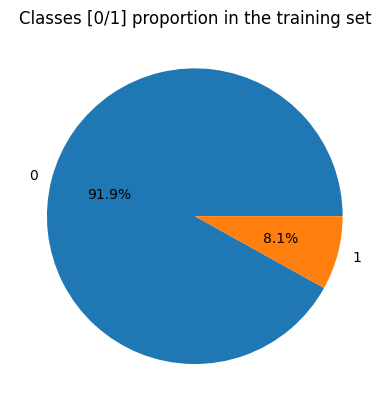

In [47]:
# Proportions of the two classesplt.figure(figsize=(8,8))
df_application_train[target].value_counts()
plt.pie(labels=df_application_train[target].value_counts().index, 
        x=df_application_train[target].value_counts().values, 
        autopct='%1.1f%%')

plt.title("Classes [0/1] proportion in the training set")
plt.show()

## 3.2 Target & variables correlation

In [48]:
# Statistics
from scipy import stats

# Coefficients list
coef_pearson=[]
coef_spearman=[]

# Simplified labels list
label_pearson=[]
label_spearman=[]

# Colors list
colorp=[]
colors=[]
blu="#9fb4ff"
red="#ffae9f"

# Treshold (under this value, the correlation is not shown)
treshold = 0.05

cols = df_train_enc.columns.tolist()
cols.remove(target)

# Getting information
for col in cols:
    cp=stats.pearsonr(df_train_enc[target].values, df_train_enc[col])[0]
    cs=stats.spearmanr(df_train_enc[target].values, df_train_enc[col])[0]

    # For Pearson correlation coefficient
    if (abs(cp) >= treshold):
        coef_pearson.append(cp)
        label_pearson.append(col)
        if (cp > 0):
            colorp.append(blu)
        else:
            colorp.append(red)
    
    # For Spearman correlation coefficient                       
    if (abs(cs) >= treshold):
        coef_spearman.append(cs)
        label_spearman.append(col)
        if (cs > 0):
            colors.append(blu)
        else:
            colors.append(red)

# Variables correlation with target barplot
def plot_corr(subpl, coef_type, coef_list, label_list):
    
    if(subpl==1):
        fig=plt.figure(1,figsize=[20,5])
        fig.patch.set_facecolor('#E0E0E0')
        fig.patch.set_alpha(0.7)
        plt.suptitle("Main (anti)correlation of variables with target",size=16)
    
    x_len = np.arange(len(label_list)) + 1
    y_len = len(label_list) + 0.5
    plt.subplot(1, 2, subpl)
    plt.title(f"{coef_type} correlation coefficient")
    plt.bar(x_len, coef_list, color=colorp, edgecolor='black')
    plt.xticks(x_len, label_list, rotation=90)
    plt.hlines(0, 0.5, y_len, color='black')
    plt.ylabel("coefficient value")
    plt.ylim(-1, 1)
    plt.grid(True)

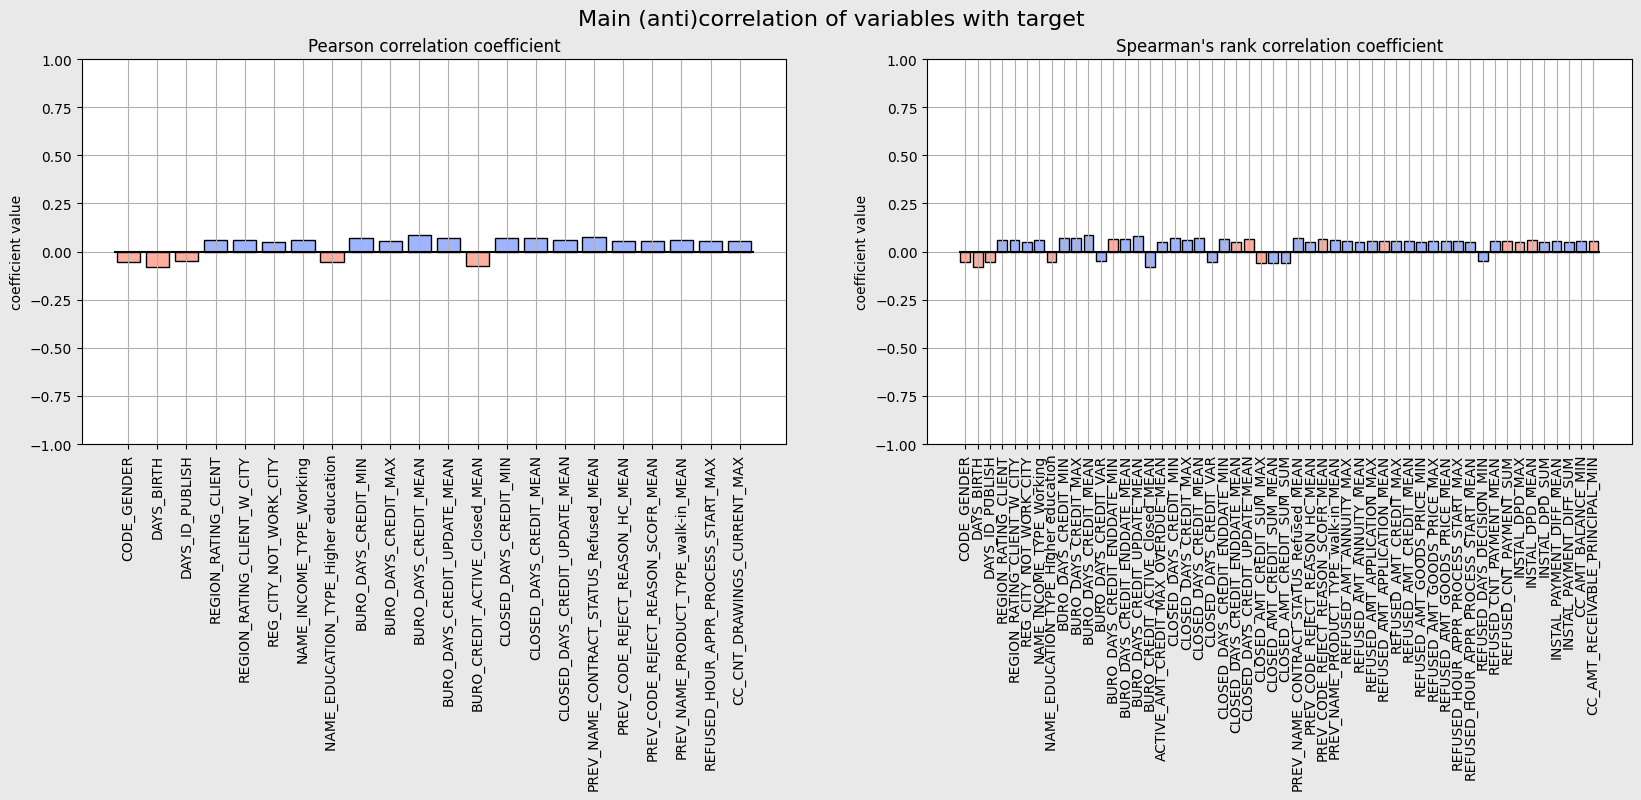

In [49]:
# 1st barplot: Pearson correlation coefficients
plot_corr(1, "Pearson", coef_pearson, label_pearson)

# 2nd barplot: Spearman correlation coefficients
plot_corr(2, "Spearman's rank", coef_spearman, label_spearman)

## 3.3 Age

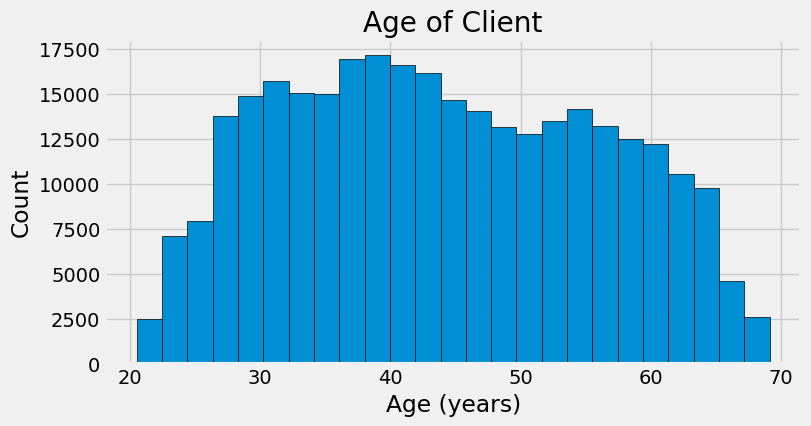

In [50]:
# Plot the distribution of ages in years
plt.style.use('fivethirtyeight')
plt.figure(figsize=(8,4))
plt.hist(df_train_enc['DAYS_BIRTH'] / 365, edgecolor = 'k', bins = 25)
plt.title('Age of Client'); plt.xlabel('Age (years)'); plt.ylabel('Count');

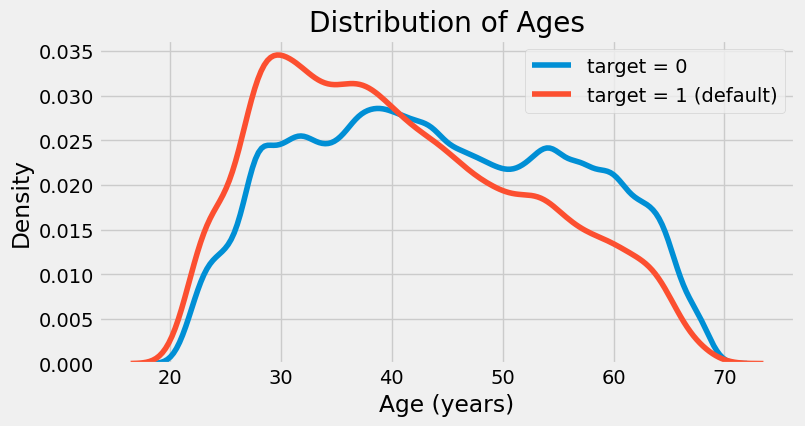

In [51]:
plt.figure(figsize = (8, 4))

# KDE plot of loans that were repaid on time
sns.kdeplot(df_train_enc.loc[df_train_enc[target] == 0, 'DAYS_BIRTH'] / 365, label='target = 0')

# KDE plot of loans which were not repaid on time
sns.kdeplot(df_train_enc.loc[df_train_enc[target] == 1, 'DAYS_BIRTH'] / 365, label='target = 1 (default)')

# Labeling of plot
plt.xlabel('Age (years)')
plt.ylabel('Density')
plt.title('Distribution of Ages')
plt.legend()
plt.show()

We can observe a light correlation between the target and age, younger tend to not repay their loan.

In [52]:
# Age information into a separate dataframe
df_age = df_train_enc[[target, 'DAYS_BIRTH']]
df_age['YEARS_BIRTH'] = df_age['DAYS_BIRTH'] / 365

# Bin the age data
df_age['YEARS_BINNED'] = pd.cut(df_age['YEARS_BIRTH'], bins = np.linspace(20, 70, num = 11))
df_age.head(10)

TARGET  DAYS_BIRTH  YEARS_BIRTH  YEARS_BINNED
0       1        9461    25.920548  (25.0, 30.0]
1       0       16765    45.931507  (45.0, 50.0]
2       0       19046    52.180822  (50.0, 55.0]
3       0       19005    52.068493  (50.0, 55.0]
4       0       19932    54.608219  (50.0, 55.0]
5       0       16941    46.413699  (45.0, 50.0]
6       0       13778    37.747945  (35.0, 40.0]
7       0       18850    51.643836  (50.0, 55.0]
8       0       20099    55.065753  (55.0, 60.0]
9       0       14469    39.641096  (35.0, 40.0]

In [53]:
# Group by the bin and calculate averages
df_age_groups  = df_age.groupby('YEARS_BINNED').mean()
df_age_groups

TARGET    DAYS_BIRTH  YEARS_BIRTH
YEARS_BINNED                                     
(20.0, 25.0]  0.122887   8533.616620    23.379772
(25.0, 30.0]  0.111313  10156.797789    27.826843
(30.0, 35.0]  0.102797  11855.465849    32.480728
(35.0, 40.0]  0.089431  13708.214232    37.556751
(40.0, 45.0]  0.078501  15497.731106    42.459537
(45.0, 50.0]  0.074184  17323.936150    47.462839
(50.0, 55.0]  0.066976  19196.528307    52.593228
(55.0, 60.0]  0.055317  20984.301135    57.491236
(60.0, 65.0]  0.052745  22780.544409    62.412450
(65.0, 70.0]  0.037270  24292.614340    66.555108

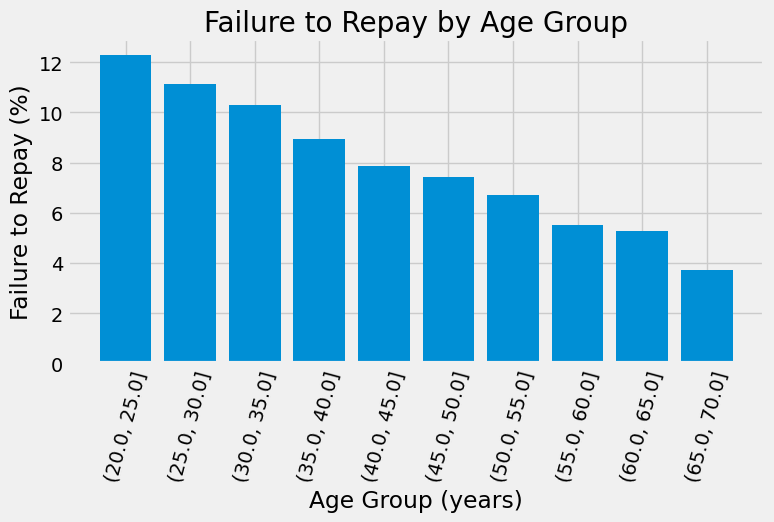

In [54]:
plt.figure(figsize = (8, 4))

# Graph the age bins and the average of the target as a bar plot
plt.bar(df_age_groups.index.astype(str), 100 * df_age_groups[target])

# Plot labeling
plt.xticks(rotation = 75); plt.xlabel('Age Group (years)'); plt.ylabel('Failure to Repay (%)')
plt.title('Failure to Repay by Age Group');

It confirm that younger tend to not pay their loan. As ennounce in provided notebook. This parameter should not be an argument to not give loan to younger but instead improve the communication, create tool to help the youngest regarding that matter.

## 3.4 External sources

In the following table and heatmap, we will outline the correlations between EXT_SOURCE_1, EXT_SOURCE_2, EXT_SOURCE_3 and the target. "According to the documentation, these features represent a "normalized score from external data source" (quote from Will Koehrsen's notebook). Therefore, they could be quite interesting for our work, since they are the results of prior data manipulations.

In [55]:
# Extract the EXT_SOURCE variables and show correlations
df_ext_data = df_train_enc[[target, 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH']]
ext_data_corr = df_ext_data.corr()
for i in range(ext_data_corr.shape[0]):
    ext_data_corr.iloc[i,i] = np.nan
ext_data_corr

TARGET  EXT_SOURCE_1  EXT_SOURCE_2  EXT_SOURCE_3  DAYS_BIRTH
TARGET             NaN     -0.012549     -0.022840     -0.017949   -0.078021
EXT_SOURCE_1 -0.012549           NaN      0.135020      0.109394    0.043919
EXT_SOURCE_2 -0.022840      0.135020           NaN      0.094141    0.013200
EXT_SOURCE_3 -0.017949      0.109394      0.094141           NaN    0.023706
DAYS_BIRTH   -0.078021      0.043919      0.013200      0.023706         NaN

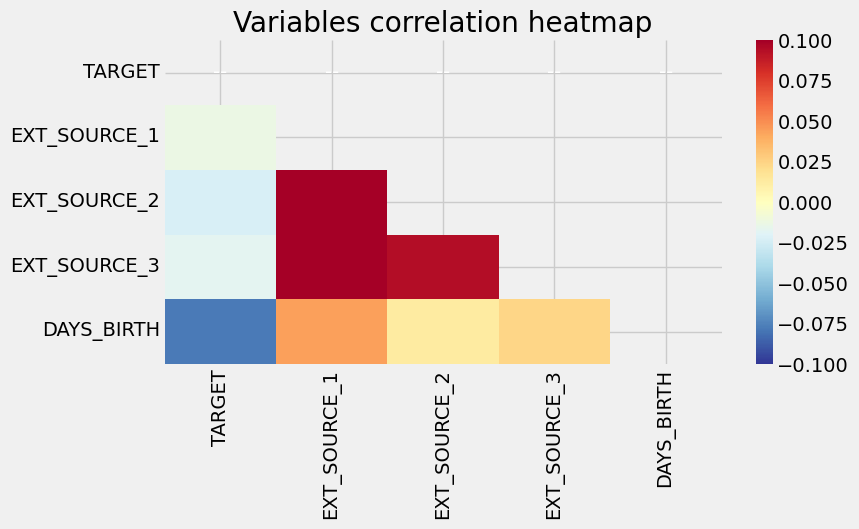

In [56]:
# Correlations heatmap
plt.figure(figsize = (8, 4))

r = 1
vmin = round(ext_data_corr.min().min(), r)
vmax = round(ext_data_corr.max().max(), r)

mask = np.zeros_like(ext_data_corr)
mask[np.triu_indices_from(mask)] = True

sns.heatmap(ext_data_corr, cmap=plt.cm.RdYlBu_r, vmin=vmin, annot=True, vmax=vmax, mask=mask)
plt.title('Variables correlation heatmap');

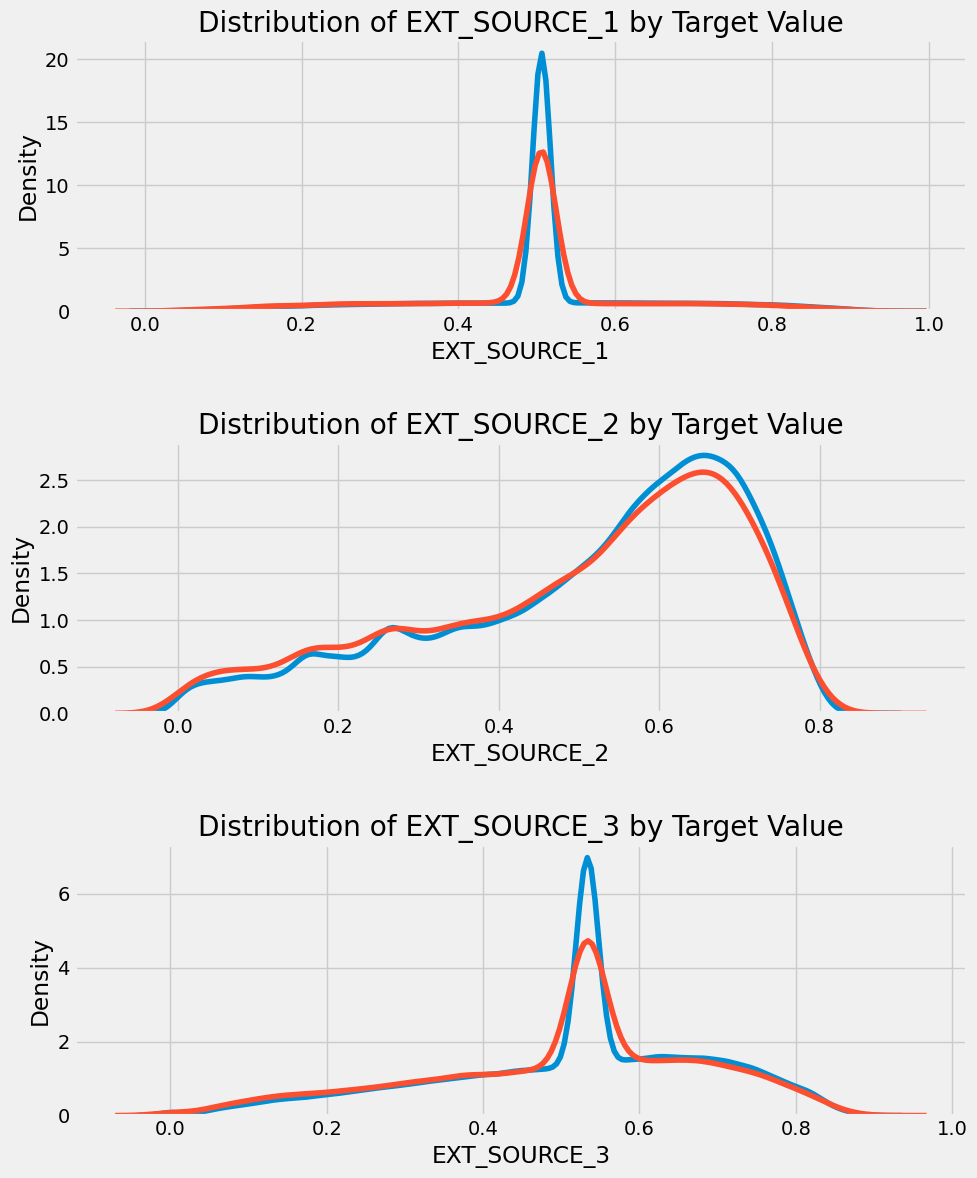

In [57]:
plt.figure(figsize = (10, 12))

# iterate through the sources
for i, source in enumerate(['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']):
    
    # create a new subplot for each source
    plt.subplot(3, 1, i + 1)
    # plot repaid loans
    sns.kdeplot(df_train_enc.loc[df_train_enc[target] == 0, source], label = 'target == 0')
    # plot loans that were not repaid
    sns.kdeplot(df_train_enc.loc[df_train_enc[target] == 1, source], label = 'target == 1')
    
    # Label the plots
    plt.title('Distribution of %s by Target Value' % source)
    plt.xlabel('%s' % source); plt.ylabel('Density');
    
plt.tight_layout(h_pad = 2.5)

## 3.5 Feature engineering

In [58]:
# Make a new dataframe for polynomial features
poly_features = df_train_enc[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH', target]]
poly_features_test = df_test_enc[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH']]

In [59]:
df_merge = merge_train_test(df_train_enc, df_test_enc)
cols = ['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH', target]
df_poly_feat = df_merge[cols]

poly_target = df_poly_feat[target]
poly_features = df_poly_feat.drop(columns = [target])
                                  
# Create the polynomial object with specified degree
poly_transformer = PolynomialFeatures(degree = 3)

In [60]:
# Train the polynomial features
poly_transformer.fit(poly_features)

# Transform the features
poly_features = poly_transformer.transform(poly_features)
#poly_features_test = poly_transformer.transform(poly_features_test)
print('Polynomial Features shape: ', poly_features.shape)

Polynomial Features shape:  (355120, 35)


In [61]:
poly_transformer.get_feature_names_out(input_features = ['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH'])

array(['1', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH',
       'EXT_SOURCE_1^2', 'EXT_SOURCE_1 EXT_SOURCE_2',
       'EXT_SOURCE_1 EXT_SOURCE_3', 'EXT_SOURCE_1 DAYS_BIRTH',
       'EXT_SOURCE_2^2', 'EXT_SOURCE_2 EXT_SOURCE_3',
       'EXT_SOURCE_2 DAYS_BIRTH', 'EXT_SOURCE_3^2',
       'EXT_SOURCE_3 DAYS_BIRTH', 'DAYS_BIRTH^2', 'EXT_SOURCE_1^3',
       'EXT_SOURCE_1^2 EXT_SOURCE_2', 'EXT_SOURCE_1^2 EXT_SOURCE_3',
       'EXT_SOURCE_1^2 DAYS_BIRTH', 'EXT_SOURCE_1 EXT_SOURCE_2^2',
       'EXT_SOURCE_1 EXT_SOURCE_2 EXT_SOURCE_3',
       'EXT_SOURCE_1 EXT_SOURCE_2 DAYS_BIRTH',
       'EXT_SOURCE_1 EXT_SOURCE_3^2',
       'EXT_SOURCE_1 EXT_SOURCE_3 DAYS_BIRTH',
       'EXT_SOURCE_1 DAYS_BIRTH^2', 'EXT_SOURCE_2^3',
       'EXT_SOURCE_2^2 EXT_SOURCE_3', 'EXT_SOURCE_2^2 DAYS_BIRTH',
       'EXT_SOURCE_2 EXT_SOURCE_3^2',
       'EXT_SOURCE_2 EXT_SOURCE_3 DAYS_BIRTH',
       'EXT_SOURCE_2 DAYS_BIRTH^2', 'EXT_SOURCE_3^3',
       'EXT_SOURCE_3^2 DAYS_BIRTH', 'EXT_SOURCE_3 DAYS_BIR

In [62]:
# Create a dataframe of the features 
poly_features = pd.DataFrame(poly_features, 
                             columns = poly_transformer.get_feature_names_out(['EXT_SOURCE_1', 'EXT_SOURCE_2', 
                                                                           'EXT_SOURCE_3', 'DAYS_BIRTH']))
# Add in the target
poly_features[target] = poly_target.values

# Find the correlations with the target
poly_corrs = poly_features.corr()[target].sort_values()

# Display most negative and most positive
print(poly_corrs.head(10))
print(poly_corrs.tail(5))

EXT_SOURCE_3^2 DAYS_BIRTH              -0.034312
EXT_SOURCE_3 DAYS_BIRTH^2              -0.034109
EXT_SOURCE_3 DAYS_BIRTH                -0.034081
EXT_SOURCE_1 EXT_SOURCE_3 DAYS_BIRTH   -0.032016
EXT_SOURCE_1 DAYS_BIRTH^2              -0.026216
EXT_SOURCE_2 EXT_SOURCE_3 DAYS_BIRTH   -0.026189
EXT_SOURCE_3^3                         -0.025362
EXT_SOURCE_3^2                         -0.025113
DAYS_BIRTH^2                           -0.023873
DAYS_BIRTH^3                           -0.023745
Name: TARGET, dtype: float64
EXT_SOURCE_1^2 EXT_SOURCE_2    0.004447
EXT_SOURCE_1^2                 0.004721
EXT_SOURCE_1^3                 0.012071
TARGET                         1.000000
1                                   NaN
Name: TARGET, dtype: float64


In [63]:
# Merge polynomial features into training dataframe
poly_features['SK_ID_CURR'] = df_merge['SK_ID_CURR'].values
df_merge = df_merge.merge(poly_features, on = ['SK_ID_CURR', target], how = 'left')

df_train_poly, df_test_poly = split_train_test(df_merge)

# Print out the new shapes
print(df_train_poly.shape, 'training data with polynomial features')
print(df_test_poly.shape, 'testing data with polynomial features')

(306540, 797) training data with polynomial features
(48580, 796) testing data with polynomial features


In [65]:
# Export data to files (.csv)
store_data(df_train_poly, 'train_poly')
store_data(df_test_poly, 'test_poly')

Data storage (./data/cleaned/data_train_poly.csv): ok.
Data storage (./data/cleaned/data_test_poly.csv): ok.


### 3.5.1. Domain knowledge features

In [64]:
df_merge = merge_train_test(df_train_enc, df_test_enc)

df_merge['CREDIT_INCOME_PERCENT'] = df_merge['AMT_CREDIT'] / df_merge['AMT_INCOME_TOTAL']
df_merge['ANNUITY_INCOME_PERCENT'] = df_merge['AMT_ANNUITY'] / df_merge['AMT_INCOME_TOTAL']
df_merge['CREDIT_TERM'] = df_merge['AMT_ANNUITY'] / df_merge['AMT_CREDIT']
df_merge['DAYS_EMPLOYED_PERCENT'] = df_merge['DAYS_EMPLOYED'] / df_merge['DAYS_BIRTH']

df_train_domain, df_test_domain = split_train_test(df_merge)

# Print out the new shapes
print(df_train_domain.shape, 'training data with domain features')
print(df_test_domain.shape, 'testing data with domain features')

(306540, 766) training data with domain features
(48580, 765) testing data with domain features


In [67]:
# Export data to files (.csv)
store_data(df_train_domain, 'train_domain')
store_data(df_test_domain, 'test_domain')

Data storage (./data/cleaned/data_train_domain.csv): ok.
Data storage (./data/cleaned/data_test_domain.csv): ok.


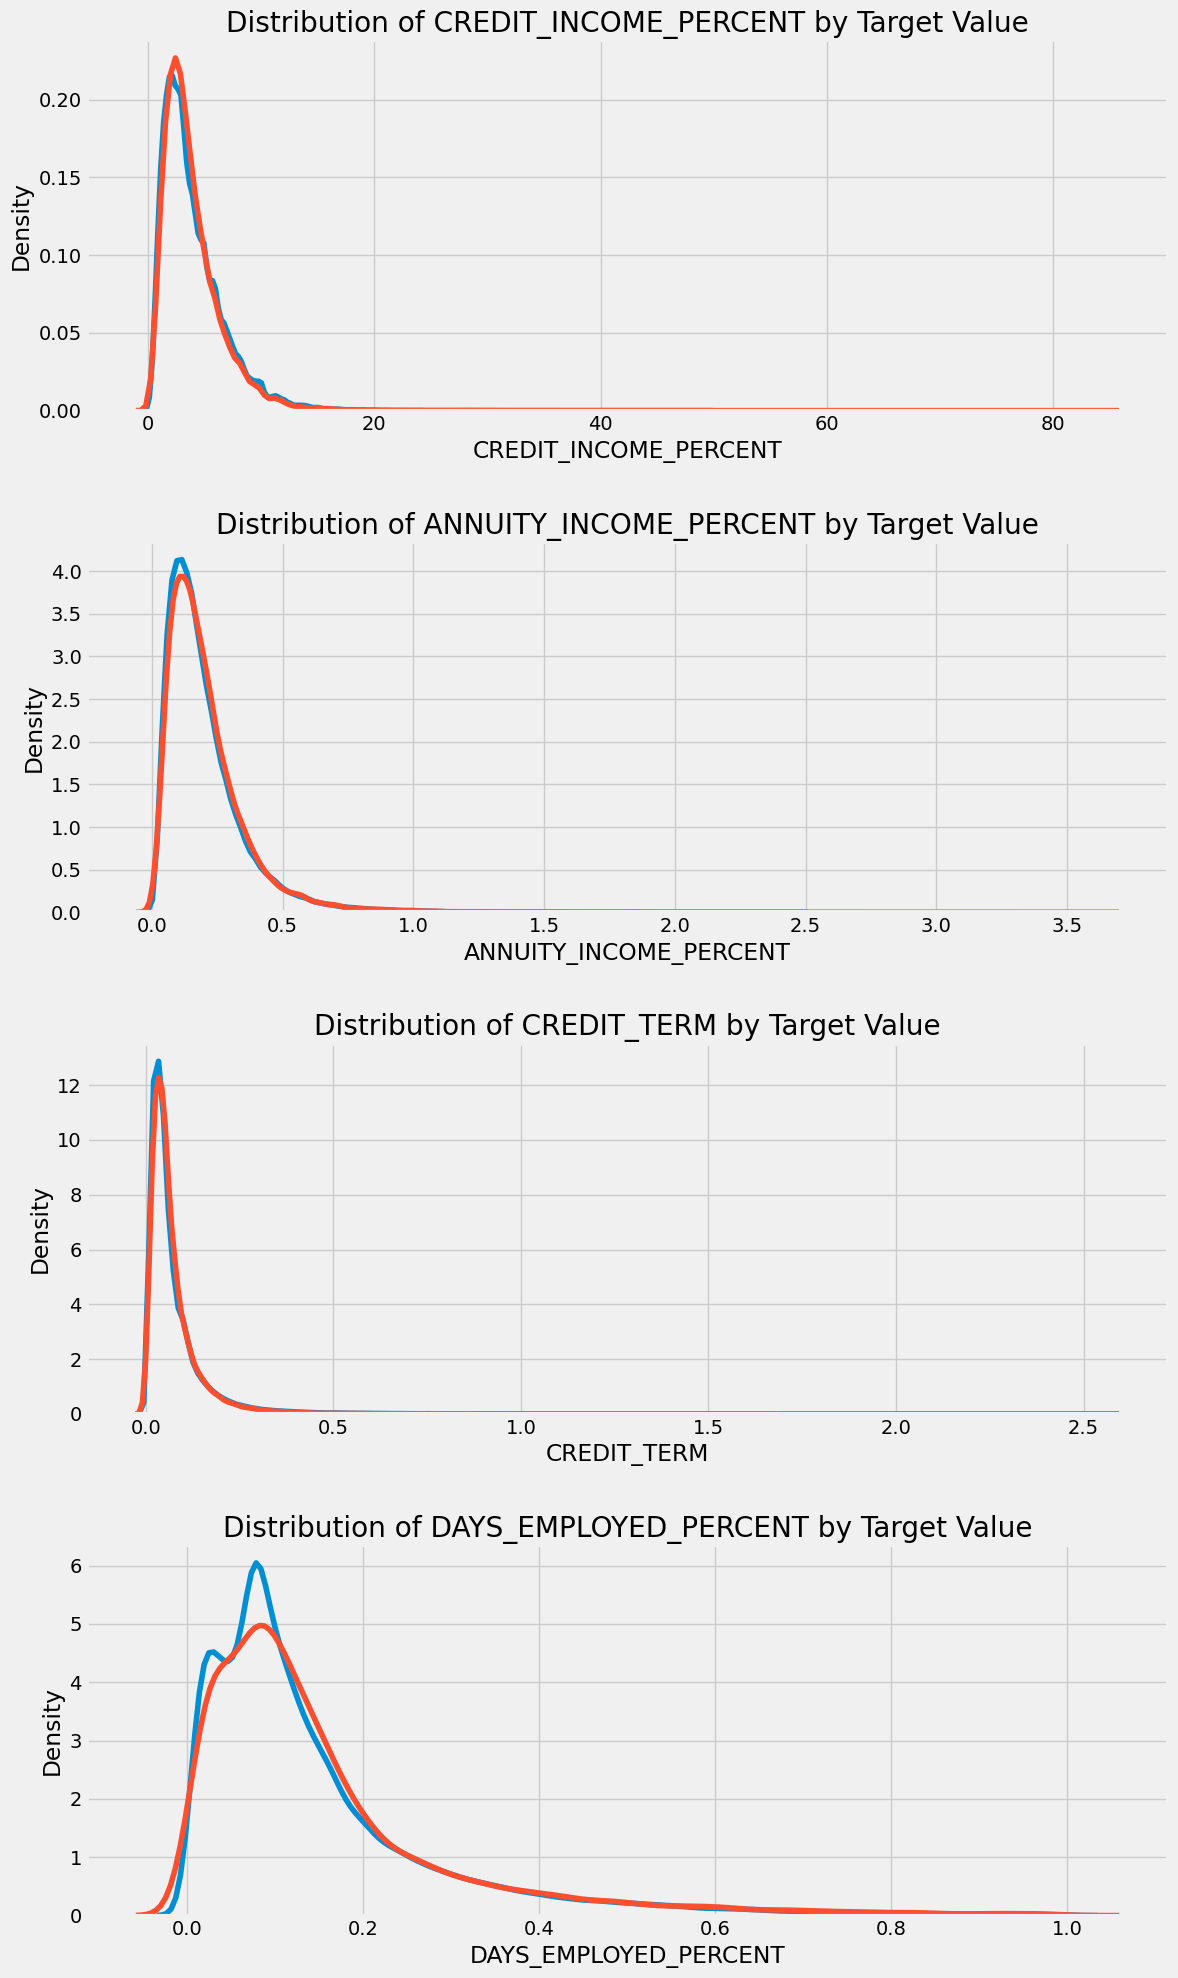

In [65]:
plt.figure(figsize = (12, 20))
# iterate through the new features
for i, feature in enumerate(['CREDIT_INCOME_PERCENT', 'ANNUITY_INCOME_PERCENT', 'CREDIT_TERM', 'DAYS_EMPLOYED_PERCENT']):
    
    # create a new subplot for each source
    plt.subplot(4, 1, i + 1)
    # plot repaid loans
    sns.kdeplot(df_train_domain.loc[df_train_domain[target] == 0, feature], label = 'target == 0')
    # plot loans that were not repaid
    sns.kdeplot(df_train_domain.loc[df_train_domain[target] == 1, feature], label = 'target == 1')
    
    # Label the plots
    plt.title('Distribution of %s by Target Value' % feature)
    plt.xlabel('%s' % feature); plt.ylabel('Density');
    
plt.tight_layout(h_pad = 2.5)

# 4. Modeling

In [66]:
# Applies PC to given training and testing sets
def train_test_pca(X_train, X_test, X_pca=None, n_comp_pca=0.99, print_res=True):
    
    start_time = set_start()
        
    n_feat = X_train.shape[1]
    len_X_train = len(X_train)
    
    if(X_pca==None):
        
        if(print_res):
            print(f">>> PCA ({n_comp_pca}) in progress...\n")
        
        X_merge = np.concatenate((X_train, X_test))
        pca = PCA(n_components=n_comp_pca)
        X_merge = pca.fit_transform(X_merge)
        X_train_red = X_merge[:len_X_train]
        X_test_red = X_merge[len_X_train:]
    
    else:
        
        X_train_red, X_test_red = X_pca
        
    n_feat_pca = X_train_red.shape[1]
    feat_diff = n_feat - n_feat_pca
    
    if(print_res==True):
        text = f"PCA ({n_comp_pca}): OK ({feat_diff} features less). Time: [ela_time] sec.\n"
        print_time(text=text, start_time=start_time)
                
    return X_train_red, X_test_red

In [67]:
# Creating training and testing sets
def create_train_test_set(df, scaler=None, ts=0.3, rs=69, calc_pca=True, n_comp_pca=0.99, print_res=True):
    X = df.copy()
    y = X[target]
    cols_to_drop = [target]
    if('SK_ID_CURR' in X.columns):
        cols_to_drop.append('SK_ID_CURR')
    X.drop(columns=cols_to_drop, inplace=True)
    if(scaler!=None):
        X = scaler.fit_transform(X)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=ts, random_state=rs)
    train_test_set = [X_train, X_test, y_train, y_test]
    if(calc_pca):
        X_train_red, X_test_red = train_test_pca(X_train, X_test, n_comp_pca=n_comp_pca, print_res=print_res)
        train_test_set.append(X_train_red)
        train_test_set.append(X_test_red)
    return train_test_set

In [68]:
# Data scaling
scaler = StandardScaler()

In [21]:
#df_train_enc = pd.read_csv(r"C:\Data_science\Project_7_bis\data\cleaned\data_train_enc.csv", sep='\t')
#df_train_poly = pd.read_csv(r"C:\Data_science\Project_7_bis\data\cleaned\data_train_poly.csv", sep='\t')
#df_train_domain = pd.read_csv(r"C:\Data_science\Project_7_bis\data\cleaned\data_train_domain.csv", sep='\t')

In [69]:
# Sample a fraction of the data (e.g., 10%), for testing
df_train_enc_sample = df_train_enc.sample(frac=0.1, random_state=42)
df_train_poly_sample = df_train_poly.sample(frac=0.1, random_state=42)
df_train_domain_sample = df_train_domain.sample(frac=0.1, random_state=42)

In [70]:
print(df_train_enc_sample.columns)

Index(['SK_ID_CURR', 'TARGET', 'CODE_GENDER', 'FLAG_OWN_CAR',
       'FLAG_OWN_REALTY', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT',
       'AMT_ANNUITY', 'AMT_GOODS_PRICE',
       ...
       'CC_NAME_CONTRACT_STATUS_Signed_MAX',
       'CC_NAME_CONTRACT_STATUS_Signed_MEAN',
       'CC_NAME_CONTRACT_STATUS_Signed_SUM',
       'CC_NAME_CONTRACT_STATUS_Signed_VAR', 'CC_NAME_CONTRACT_STATUS_nan_MIN',
       'CC_NAME_CONTRACT_STATUS_nan_MAX', 'CC_NAME_CONTRACT_STATUS_nan_MEAN',
       'CC_NAME_CONTRACT_STATUS_nan_SUM', 'CC_NAME_CONTRACT_STATUS_nan_VAR',
       'CC_COUNT'],
      dtype='object', length=762)


In [71]:
# Creation of the train sets
train_test_set_std = create_train_test_set(df_train_enc_sample, scaler, n_comp_pca=0.80)
train_test_set_poly = create_train_test_set(df_train_poly_sample, scaler, n_comp_pca=0.80)
train_test_set_domain = create_train_test_set(df_train_domain_sample, scaler, n_comp_pca=0.80)

>>> PCA (0.8) in progress...

PCA (0.8): OK (515 features less). Time: 3.0 sec.

>>> PCA (0.8) in progress...

PCA (0.8): OK (554 features less). Time: 3.0 sec.

>>> PCA (0.8) in progress...

PCA (0.8): OK (519 features less). Time: 3.0 sec.



In [72]:
# If set to False, this boolean will tell the algorithm, instead to perform calculations, to get the previous results,
# which are stored in ./calc/.
calc_pred = True

In [73]:
# Returns a string with the model name (from a model class)
def get_model_name(model, sep='('):
    model_name = str(model).split(sep)[0]
    return model_name

In [74]:
# Returns the name (with path) of a storage file (for GridSearchCV or predictions result)
def get_filename(model_name, obj, loc=calc_path, dataset="standard", app_pca=False, ext='.csv'):
    filename = loc + model_name + obj + dataset.capitalize() 
    if(app_pca):
        filename += 'PCA'
    filename += ext
    return filename

In [75]:
# Stores GridSearchCV or predictions result in a file
def store_val(values, obj, cols, filename, sep="\t", index=None, print_res=True):
    df = pd.DataFrame(columns=cols)
    df.loc[0] = values
    df.to_csv(filename, sep=sep, index=index)
    if(print_res):
        print(f"{obj} storage: OK ({filename}).\n")

In [76]:
# Stores treshold optimization tests in a file
def store_treshold_opt(treshold_list, score_list, filename, sep="\t", index=None, print_res=True):
    cols = ['treshold', 'score']
    df = pd.DataFrame(columns=cols)
    n_rows = len(treshold_list)
    for i in range(n_rows):
        df.loc[i] = [treshold_list[i], score_list[i]]
    df.to_csv(filename, sep=sep, index=index)
    if(print_res):
        print(f"{n_rows} treshold list optimization tests succesfully stored ({filename}).\n")

In [77]:
# Recovers a confusion matrix array from a storage file (where it is stored as a string)
def get_cm(cm_string, sep_a=']\n [', sep_b=" "):
    cm_string = re.sub(' +', ' ', cm_string)
    cm_string = cm_string[2:-2]
    cm_string_split = cm_string.split(sep_a)
    for i in range(len(cm_string_split)):
        cm_string_split[i] = cm_string_split[i].lstrip(' ')
    cm_string_split_1 = cm_string_split[0].split(sep_b)
    cm_string_split_2 = cm_string_split[1].split(sep_b)
    
    def to_int(cm_str_split):
        for i in range(len(cm_str_split)):
            cm_str_split[i] = int(cm_str_split[i])
        return cm_str_split
    
    cm_string_split_1 = to_int(cm_string_split_1)
    cm_string_split_2 = to_int(cm_string_split_2)
    
    cm_list = []
    cm_list.append(cm_string_split_1)
    cm_list.append(cm_string_split_2)
    cm = np.array(cm_list)
    
    return cm

In [78]:
# Recovers a predictions array from a storage file (where it is stored as a string) 
def get_y(y_string, sep=' '):
    y_string = y_string[1:-1]
    y = y_string.split(sep)
    y = np.array(list((map(int, y))))
    return y

In [79]:
# Convert a list to string
def list_to_string(l):
    l_str = '['
    for i, n in enumerate(l):
        l_str += str(n) + ' '
    l_str = l_str[:-1] + ']'
    return l_str

In [80]:
# Recovers an array from a string
def string_to_array(string, sep=' ', typ=np.float64):
    arr = np.array(string.split(sep))
    float_list = []
    for elt in arr:
        elt = typ(elt)
        float_list.append(elt)
    return np.array(float_list)

In [81]:
# Recovers (false/true) prediction rate array from string
def get_pr(df, col, limits='[]', sep=' ', typ=np.float64):
    limit_1, limit_2 = limits
    string = df[col].iloc[0]
    string = string.split(limit_1)[1]
    string = string.split(limit_2)[0]
    pr_arr = string_to_array(string, sep=sep, typ=typ)
    return pr_arr

In [82]:
# Specific score function
def spec_score_func(y_true, y_pred, w_fp=1, w_fn=10):
    
    n_pred = len(y_true)
    
    cm = confusion_matrix(y_true, y_pred)
    
    if(len(cm)==2):
        tn, fp, fn, tp = cm.ravel()
    else:
        fp = 0
        fn = 0
    
    wfp = fp * w_fp
    wfn = fn * w_fn
    
    max_cost_coef = max(w_fn, w_fp)
    
    max_cost = n_pred * max_cost_coef
    
    score = (max_cost - (wfp + wfn)) / max_cost
    
    return score

spec_score_name = 'business_score'
spec_score_data = [spec_score_name, spec_score_func]

In [83]:
# Returns, for a given model test, a name and a description
def get_test_info(model_name, dataset_type, app_pca):
    
    name = f"{model_name}/{dataset_type} dataset"
    description = f"{model_name} on {dataset_type} dataset"
    if(app_pca):
        name += "/PCA"
        description += " with PCA"
    dt_str = get_date_time()
    description += f" [{dt_str}]"
     
    return name, description

In [84]:
# Plots CM heatmap
def plot_cm(cm, test_name, figsize=(6,4)):
    
    plt.figure(figsize = (6,4))
    
    sns.heatmap(cm, annot=True, cmap="Blues")
    
    plt.title(f'Confusion matrix [{test_name}]')
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    
    plt.show()

In [85]:
# Plots ROC curve chart
def plot_roc_auc(roc_auc, fpr, tpr, test_name, figsize=(6,4)):
    
    plt.figure(figsize = figsize)
    
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    
    plt.title(f'ROC curve [{test_name}]')
    plt.legend(loc = 'lower right')
    plt.ylabel('True positive rate')
    plt.xlabel('False positive rate')
    
    plt.show()

In [86]:
# Cross validate a given classifier on a given parameters grid on a given dataset. Returns the best parameters
# PCA is optional (app_pca=True; default: False)
def cross_validate(model,
                   train_test_set, 
                   param_grid,
                   dataset="standard",
                   score_spec=spec_score_data,
                   cv=10, 
                   print_res=True,
                   calc=calc_pred,
                   store=True,
                   loc=calc_path,
                   sep='(',
                   ext='.csv',
                   r=4,
                   app_pca=False,
                   n_comp_pca=0.99):
    
    # Execution start time
    start_time = set_start()
    
    # Object (cross validation) and model names (for result printing and storing)
    obj = "CV"
    model_name = get_model_name(model)
    
    # Score name and function
    score_name = score_spec[0]
    score_tool = make_scorer(score_spec[1], greater_is_better=True)
    
    # Name of the file storing cv
    filename = get_filename(model_name=model_name, obj=obj, loc=loc, dataset=dataset)
    
    # Name and description of the model test
    test_name, test_description = get_test_info(model_name, dataset, app_pca)
    
    # Getting training set
    
    # If PCA is demanded (app_pca=True), either an X train, on which PCA has been already performed is selected, or PCA
    # is performed on X train
    if(app_pca):
            
        if(len(train_test_set)==6):
            X_pca = train_test_set[4:]
        else:
            X_pca = None
        
        X_train, X_test = train_test_set[0:2]
        X_train, X_test = train_test_pca(X_train, X_test, X_pca=X_pca, n_comp_pca=n_comp_pca, print_res=False)
        X = X_train
    
    else:
        
        X = train_test_set[0]
        
    y = train_test_set[2]
        
    # Print CV in progress
    if(print_res):
        
        text = f">>> Cross validation [{test_name}] in progress...\n"
        print(text)
    
    # Parameters optimization
    if(calc):
        
        grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=cv, scoring=score_tool)
        grid.fit(X, y)
        best_params = grid.best_params_
        best_score = grid.best_score_
        ela_time = calc_time(start_time)
    
    # Results of a former parameters optimization are loaded
    else:
        
        df = pd.read_csv(filename, sep="\t")
        best_params = df['best_params'].iloc[0]
        best_params = ast.literal_eval(best_params)
        best_score = df['best_score'].iloc[0]
        ela_time = df['elapsed_time'].iloc[0]
    
    # Print result
    if(print_res):
        
        text = f"[{test_name}] Best hyperparameters: {best_params}; "
        text += f"best score ({score_name}): {round(best_score, r)}; time: [ela_time] sec.\n"
        print_time(text=text, ela_time=ela_time)
        
    # Export result to file (.csv)
    if(calc & store):
        
        values = [model, model_name, best_params, best_score, ela_time]
        cols = ['model', 'model_name', 'best_params', 'best_score', 'elapsed_time']
        obj = "Cross validation result"
        store_val(values, obj, cols, filename)
    
    # Return result (optimized parameters)
    return best_params

In [87]:
# Assigns classes accoording to a given treshold (default: 0.5)
def assign_class(y_proba, treshold=0.5):
    
    y_pred = np.where(y_proba > treshold, 1, 0)
            
    #y_pred = y_pred.astype(int)
    
    return y_pred

In [88]:
# Loads parameters on MLFlow
def mlflow_log_params(params):
    for k,v in params.items():
        mlflow.log_param(k, v)

In [89]:
# Trains and tests a given classifier. Returns prediction results, accuracy and elapsed times
# Options: perform PCA (default: False)
#          plot confusion matrix heatmap and ROC curve chart (default: True)
#          track test on MLFlow (default: True)
def test(   model, 
            params, 
            train_test_set,
            dataset="standard",
            score_spec=spec_score_data,
            print_res=True,
            calc=calc_pred,
            store=True, 
            loc=calc_path, 
            r=4,
            treshold=0.5,
            app_pca=False,
            n_comp_pca=0.99,
            plot=True,
            track_test=True,
            test_description=None):
    
    # Object (cross validation) and model names (for result printing and storing)
    obj = "Prediction"
    model_name = get_model_name(model)
    
    # Score name and function
    score_name = score_spec[0]
    score_tool = score_spec[1]
    
    # Name and description of the model test
    test_name, td = get_test_info(model_name, dataset, app_pca)
    
    # If no description is passed as argument, a test description is automatically defined
    if(test_description==None):
        test_description = td
    
    # Name of the file storing result
    filename = get_filename(model_name=model_name, obj=obj, loc=loc, dataset=dataset, app_pca=app_pca)
    
    if(print_res):
        pred_in_prog = f">>> Prediction [{test_name}] in progress...\n"
    
    # Train and test performing
    if(calc):

        # Getting training and testing set
        X_train, X_test, y_train, y_test = train_test_set[0:4]
        
        # If PCA is demanded (app_pca=True), either an X train, on which PCA has been already performed is selected, 
        # or PCA is performed on X train
        if(app_pca):

            if(len(train_test_set)==6):
                X_pca = train_test_set[4:]
            else:
                X_pca = None

            X_train, X_test = train_test_pca(X_train, X_test, X_pca=X_pca, n_comp_pca=n_comp_pca, print_res=print_res)
        
        with mlflow.start_run(run_name=test_name, description=test_description):
            
            # Execution start time
            start_time = set_start()

            # Setting classifier hyperparameters
            model.set_params(**params)

            # Training
            model.fit(X_train, y_train)

            # Prediction
            
            # Print CV in progress
            if(print_res):
                print(pred_in_prog)
            
            # Classes (0/1) probability
            y_proba = model.predict_proba(X_test)[:, 1]
            
            # Class prediction
            y_pred = assign_class(y_proba, treshold)

            # Evaluation (confusion matrix, custom score, accuracy, roc auc, time)
            cm = confusion_matrix(y_test, y_pred)
            score_spec = score_tool(y_test, y_pred)
            acc = accuracy_score(y_test, y_pred)
            fpr, tpr, threshold = roc_curve(y_test, y_proba)
            roc_auc = auc(fpr, tpr)
            roc_auc_sc = roc_auc_score(y_test, y_pred)
            ela_time = calc_time(start_time)
            
            # MLFlow tracking
            mlflow.log_metric(f"{score_name} score", score_spec)
            mlflow.log_metric("accuracy", acc)
            mlflow.log_metric("ROC AUC score", roc_auc_sc)
            mlflow.log_metric("elapsed seconds", ela_time)
            mlflow_log_params(params)

            predictions = model.predict(X_train)
            signature = infer_signature(X_train, predictions)

            tracking_url_type_store = urlparse(mlflow.get_tracking_uri()).scheme

            # Model registry does not work with file store
            if tracking_url_type_store != "file":
                # Register the model
                # There are other ways to use the Model Registry, which depends on the use case,
                # please refer to the doc for more information:
                # https://mlflow.org/docs/latest/model-registry.html#api-workflow
                mlflow.sklearn.log_model(
                    model, "model", registered_model_name=model_name, signature=signature
                )
            else:
                mlflow.sklearn.log_model(model, "model", signature=signature)
    
    # Test result is loaded from storage file
    else:
        
        start_time = set_start()

        if(print_res):
            if(app_pca):
                print(f"PCA ({n_comp_pca}): OK.\n")
            print(pred_in_prog)

        df = pd.read_csv(filename, sep="\t")
        y_pred = df['y_pred'].iloc[0]
        cm = df['confusion_matrix'].iloc[0]
        cm = get_cm(cm)
        score_spec = df['score_spec'].iloc[0]
        acc = df['accuracy'].iloc[0]
        fpr = get_pr(df, 'fpr')
        tpr = get_pr(df, 'tpr')
        roc_auc = df['roc_auc'].iloc[0]
        roc_auc_sc = df['roc_auc_score'].iloc[0]
        ela_time = df['elapsed_time'].iloc[0]
    
    # Print result
    if(print_res):
        
        text  = f"[{test_name}] {score_name.capitalize()} score: {round(score_spec, r)}"
        text += f"\n[{test_name}] Accuracy score: {round(acc, r)}"
        text += f"\n[{test_name}] ROC AUC score: {round(roc_auc_sc, r)}"
        text += f"\n[{test_name}] Time: [ela_time] sec.\n"
        
        print_time(text=text, ela_time=ela_time)
        
    # Store result in list
    cols = ['model',
            'dataset_type', 
            'pca',
            'y_pred', 
            'score_spec', 
            'accuracy',
            'fpr',
            'tpr',
            'roc_auc',
            'roc_auc_score', 
            'confusion_matrix', 
            'elapsed_time']
    
    values = [model, dataset, app_pca, y_pred, score_spec, acc, fpr, tpr, roc_auc, roc_auc_sc, cm, ela_time]
    
    # Export result to file (.csv)
    if(calc & store):
        
        y_pred_str = list_to_string(list(y_pred))
        fpr_str = list_to_string(fpr)
        tpr_str = list_to_string(tpr)
        values_to_store = [model, dataset, app_pca, y_pred_str, score_spec, acc, fpr_str, tpr_str, roc_auc, roc_auc_sc, cm, ela_time]
        store_val(values_to_store, obj, cols, filename)
    
    # Plot confusion matrix heatmap and ROC AUC curve chart
    if(plot):
        figsize = (10,6)
        plot_cm(cm, test_name, figsize)
        plot_roc_auc(roc_auc, fpr, tpr, test_name, figsize)
    
    # Return result
    return zip(cols, values)

In [90]:
# Returns a parameters dictionary from a parameters grid (in the grid, multiple parameter values are stored in lists)
def get_params_from_grid(grid):
    params = dict()
    for key in grid:
        if(isinstance(grid[key], list)):
            params[key] = grid[key][0]
        else:
            params[key] = grid[key]
    return params

In [91]:
# For a given mode, this function performs three operations:
# 1) parameters optimization (optional; default: True)
# 2) train
# 3) test
# Other options: perform PCA (default: False)
#                plot confusion matrix heatmap and ROC curve chart (default: True)
#                track test on MLFlow (default: True) 
def apply_model(model,
                train_test_set, 
                param_grid,
                validate=True,
                dataset="standard",
                score_spec=spec_score_data, 
                cv=10, 
                print_res=True,
                store=True,
                loc=calc_path,
                sep='(',
                ext='.csv',
                calc=calc_pred,
                r=4,
                ret=False,
                treshold=0.5,
                app_pca=False,
                n_comp_pca=0.99,
                plot=True,
                track_test=True,
                test_description=None,
                get_params=False):
        
        # Cross validation
        if(validate):
            params =  cross_validate(  model, 
                                       train_test_set, 
                                       param_grid,
                                       dataset=dataset,
                                       score_spec=score_spec, 
                                       cv=cv, 
                                       print_res=print_res,
                                       calc=calc,
                                       store=store,
                                       loc=loc,
                                       sep=sep,
                                       ext=ext,
                                       r=r,
                                       app_pca=app_pca,
                                       n_comp_pca=n_comp_pca)
            
        else:
            params = get_params_from_grid(param_grid)
        
        # Prediction
        values = test(   model, 
                         params, 
                         train_test_set, 
                         dataset=dataset,
                         score_spec=score_spec,
                         print_res=print_res, 
                         calc=calc,
                         store=store, 
                         loc=loc, 
                         r=r,
                         treshold=treshold,
                         app_pca=app_pca,
                         n_comp_pca=n_comp_pca,
                         plot=plot,
                         track_test=track_test,
                         test_description=test_description)
        
        res = dict(values)
        
        if(ret):
            if(get_params):
                return res, params
            else:
                return res
        else:
            res_list.append(res)
            if(get_params):
                param_list.append(params)

In [92]:
# Tests results storage list
res_list = []
param_list = []

# 5 Dummy

Before testing out models, we implement a dummy classifier, in order to establish a baseline. The default estimation strategy, named prior, is defined as follows on the class documentation page: «the predict method always returns the most frequent class label in the observed y argument passed to fit (like “most_frequent”). predict_proba always returns the empirical class distribution of y also known as the empirical class prior distribution».
Instead of keeping it, we will test all avaliable strategies (most_frequent, prior, stratified, uniform, constant; constant value = 1), and choose the one giving the best results.
Class assignment treshold is fixed at 0.5.

>>> Cross validation [DummyClassifier/standard dataset] in progress...

[DummyClassifier/standard dataset] Best hyperparameters: {'constant': 1, 'random_state': 69, 'strategy': 'most_frequent'}; best score (business_score): 0.9205; time: 3.0 sec.

Cross validation result storage: OK (./calc/DummyClassifierCVStandard.csv).

>>> Prediction [DummyClassifier/standard dataset] in progress...

[DummyClassifier/standard dataset] Business_score score: 0.9196
[DummyClassifier/standard dataset] Accuracy score: 0.9196
[DummyClassifier/standard dataset] ROC AUC score: 0.5
[DummyClassifier/standard dataset] Time: 0.0 sec.

Prediction storage: OK (./calc/DummyClassifierPredictionStandard.csv).



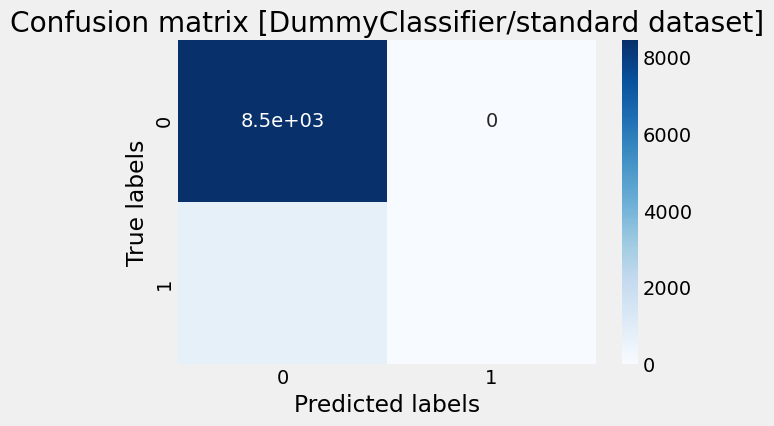

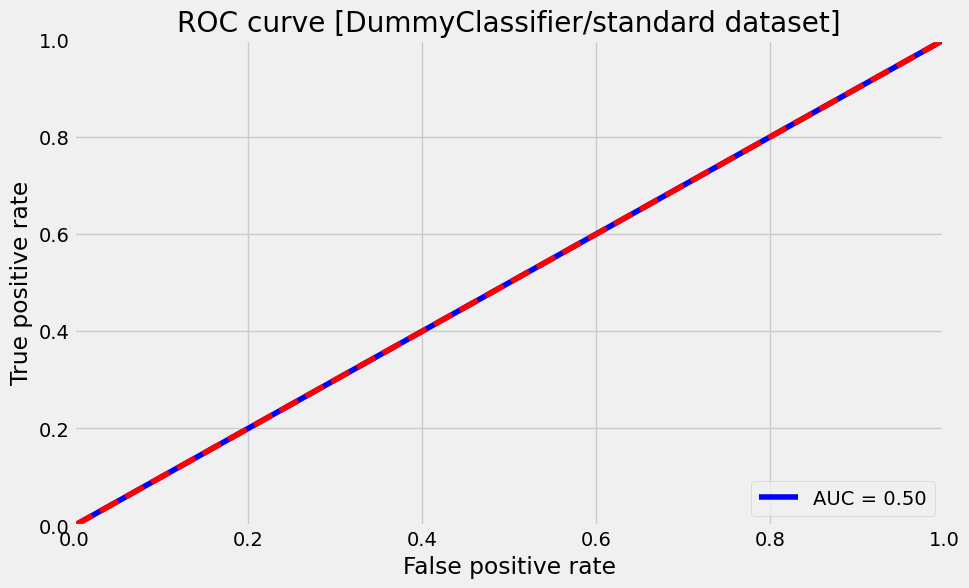

In [93]:
# Model definition
dummy = DummyClassifier(strategy='prior')

# Grid definition
strat_list = ['most_frequent', 'prior', 'stratified', 'uniform', 'constant'] # Best: most_frequent
dummy_grid = {'strategy': strat_list, 'random_state': [69], 'constant': [1]}

# Model optimization, train and test
apply_model(dummy, 
            train_test_set_std,
            dummy_grid,
            dataset='standard',
            app_pca=False,
            validate=True,
            plot=True,
            get_params=True)

Once our baseline defined, we will we will optimize some of our model's parameters (via GridSearchCV) on the standard dataset without PCA (as for the dummy classifier).
Then, we will test them on the other all dataset versions (with/without polynomial/domain features; with/without PCA), in order to choose the best one.

## 5.1 Logistic regression

>>> Cross validation [LogisticRegression/standard dataset] in progress...

[LogisticRegression/standard dataset] Best hyperparameters: {'C': 0.001, 'class_weight': 'balanced'}; best score (business_score): 0.9413; time: 14.0 sec.

Cross validation result storage: OK (./calc/LogisticRegressionCVStandard.csv).

>>> Prediction [LogisticRegression/standard dataset] in progress...

[LogisticRegression/standard dataset] Business_score score: 0.9391
[LogisticRegression/standard dataset] Accuracy score: 0.6866
[LogisticRegression/standard dataset] ROC AUC score: 0.6432
[LogisticRegression/standard dataset] Time: 0.0 sec.

Prediction storage: OK (./calc/LogisticRegressionPredictionStandard.csv).



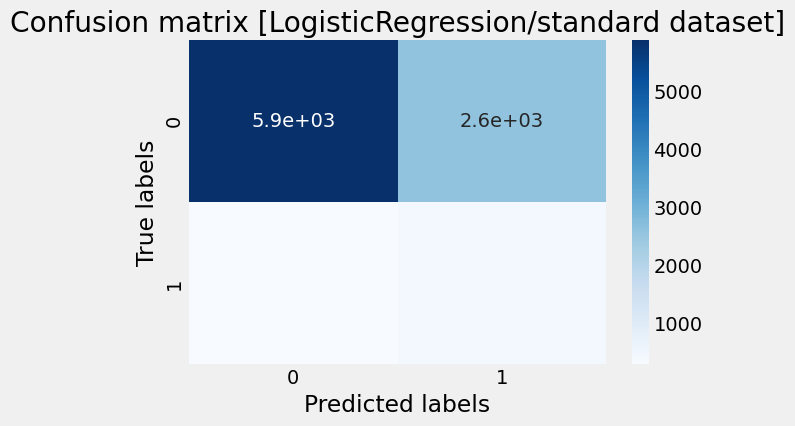

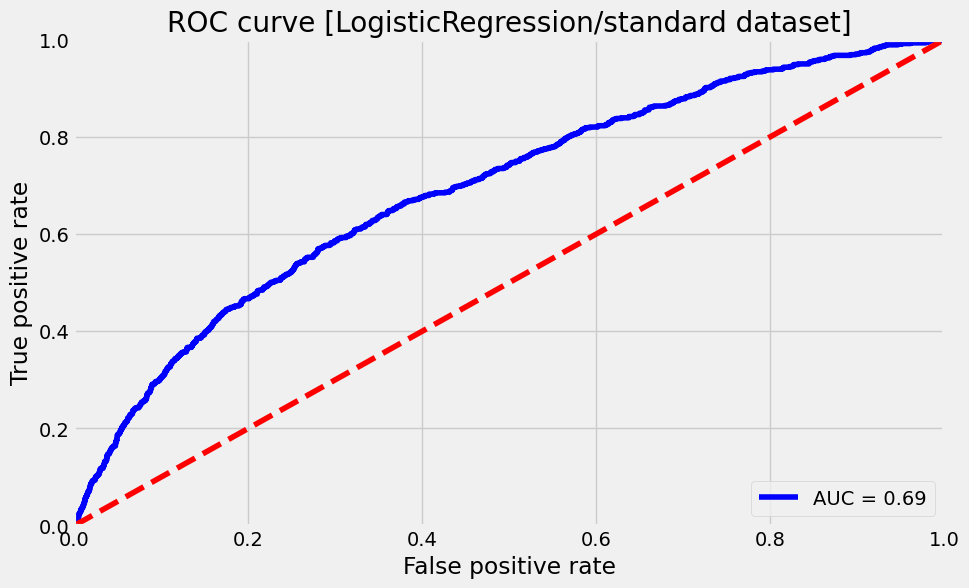

In [94]:
# Model definition
lr = LogisticRegression()

# Grid definition
C_list = [0.01, 0.001, 0.0001, 0.00001] # Best: 0.001
lr_grid = {'C': C_list, 'class_weight': ['balanced']}

# Model optimization, train and test
apply_model(lr, 
            train_test_set_std,
            lr_grid,
            dataset='standard',
            app_pca=False,
            validate=True,
            plot=True,
            get_params=True)

## 5.2 Random Forest

>>> Cross validation [BalancedRandomForestClassifier/standard dataset] in progress...

[BalancedRandomForestClassifier/standard dataset] Best hyperparameters: {'n_estimators': 300}; best score (business_score): 0.9386; time: 169.0 sec.

Cross validation result storage: OK (./calc/BalancedRandomForestClassifierCVStandard.csv).

>>> Prediction [BalancedRandomForestClassifier/standard dataset] in progress...

[BalancedRandomForestClassifier/standard dataset] Business_score score: 0.9373
[BalancedRandomForestClassifier/standard dataset] Accuracy score: 0.6502
[BalancedRandomForestClassifier/standard dataset] ROC AUC score: 0.6351
[BalancedRandomForestClassifier/standard dataset] Time: 9.0 sec.

Prediction storage: OK (./calc/BalancedRandomForestClassifierPredictionStandard.csv).



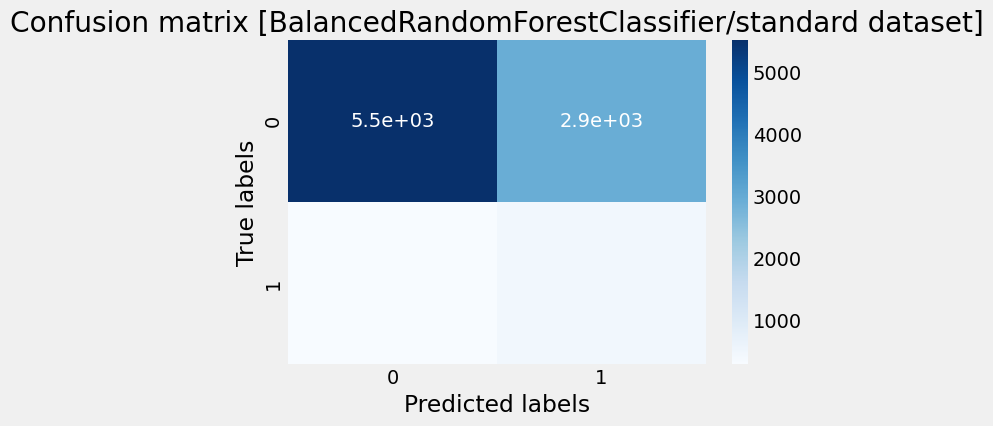

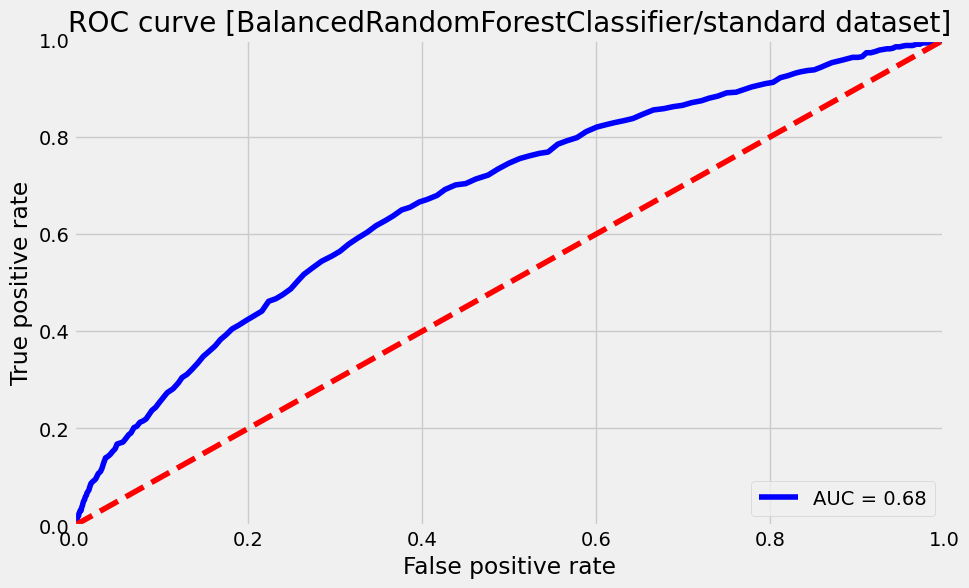

In [95]:
# Model definition
brf = BalancedRandomForestClassifier()

# Grid definition
n_estimator_list_brf = [100, 200, 300] # Best: 300
brf_grid = {'n_estimators': n_estimator_list_brf}

# Model optimization, train and test
apply_model(brf, 
            train_test_set_std, 
            brf_grid,
            dataset='standard',
            validate=True,
            app_pca=False,
            plot=True,
            get_params=True)

## 5.3 Light Gradient-Boosting Machine (LGB)

LGB being too computationally heavy for my ressources, we will simply exclude it.

>>> Cross validation [LGBMClassifier/standard dataset] in progress...

[LightGBM] [Info] Number of positive: 1536, number of negative: 17775
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.046805 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 79447
[LightGBM] [Info] Number of data points in the train set: 19311, number of used features: 660
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Info] Number of positive: 1535, number of negative: 17776
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.043456 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 79286
[LightGBM] [Info] Number of data points in the train set: 19311, number of used features: 661
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.0

[LightGBM] [Info] Number of positive: 1536, number of negative: 17776
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.053778 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 79383
[LightGBM] [Info] Number of data points in the train set: 19312, number of used features: 657
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Info] Number of positive: 1536, number of negative: 17776
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.084126 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 79352
[LightGBM] [Info] Number of data points in the train set: 19312, number of used features: 657
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [In

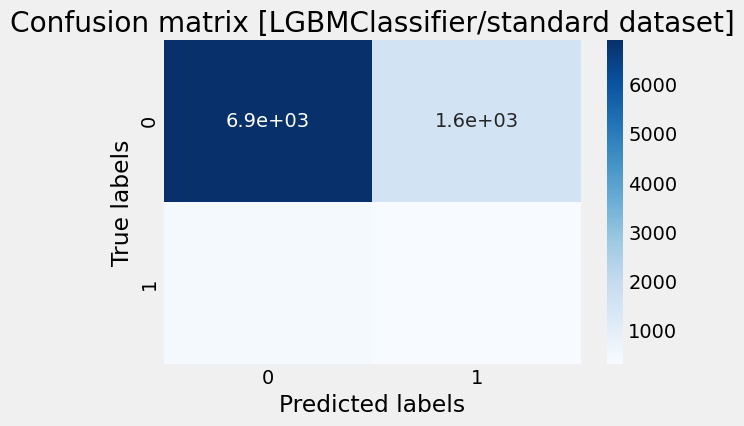

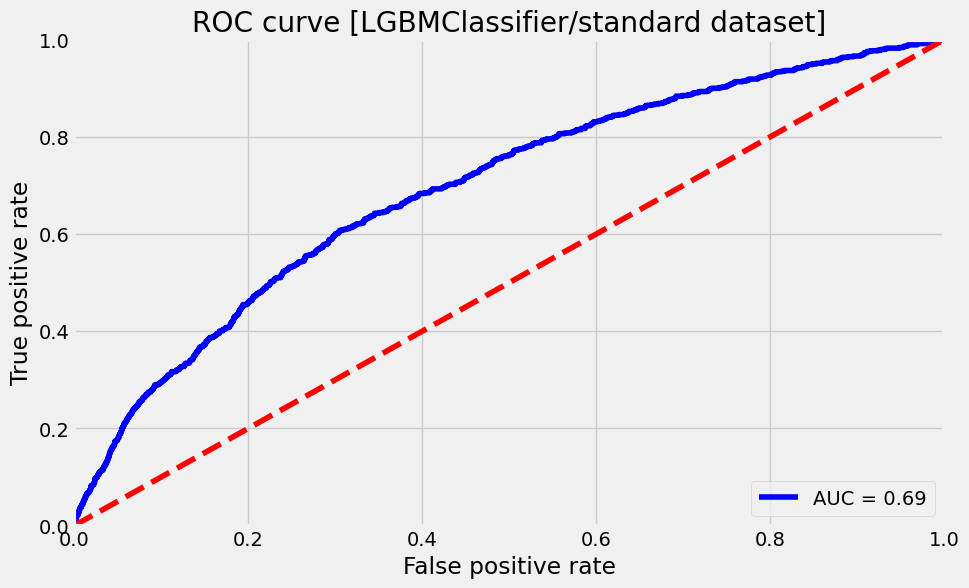

In [96]:
# Model definition
gb = LGBMClassifier()

# Grid definition
n_estimator_list_gb = [100, 200] # Best: 100
gb_grid = {'n_estimators': n_estimator_list_gb, 
           'objective': ['binary'],            
           'class_weight': ['balanced'], 
           'learning_rate': [0.05], 
           'reg_alpha': [0.1],
           'reg_lambda': [0.1],
           'subsample': [0.8],
           'n_jobs': [-1],
           'random_state': [69]}

# Model optimization, train and test
apply_model(gb, 
            train_test_set_std, 
            gb_grid,
            dataset='standard',
            validate=True,
            app_pca=False,
            plot=True,
            get_params=True)

## 5.4 Test & compare all df

PCA (0.99): OK (515 features less). Time: 0.0 sec.

>>> Prediction [DummyClassifier/standard dataset/PCA] in progress...

[DummyClassifier/standard dataset/PCA] Business_score score: 0.9196
[DummyClassifier/standard dataset/PCA] Accuracy score: 0.9196
[DummyClassifier/standard dataset/PCA] ROC AUC score: 0.5
[DummyClassifier/standard dataset/PCA] Time: 0.0 sec.

Prediction storage: OK (./calc/DummyClassifierPredictionStandardPCA.csv).



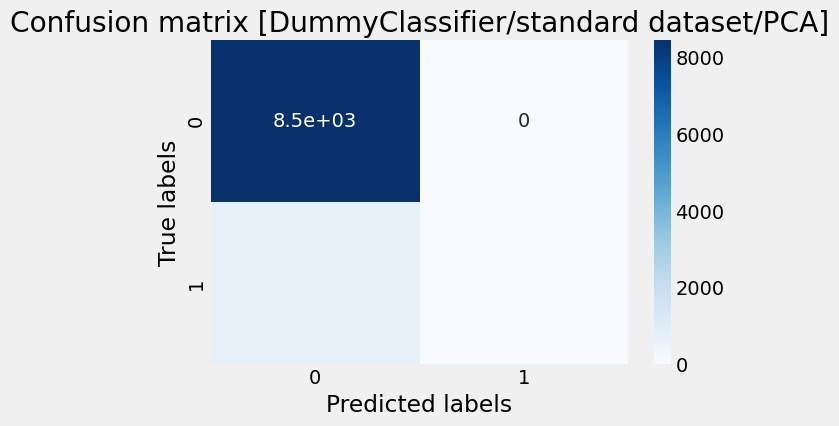

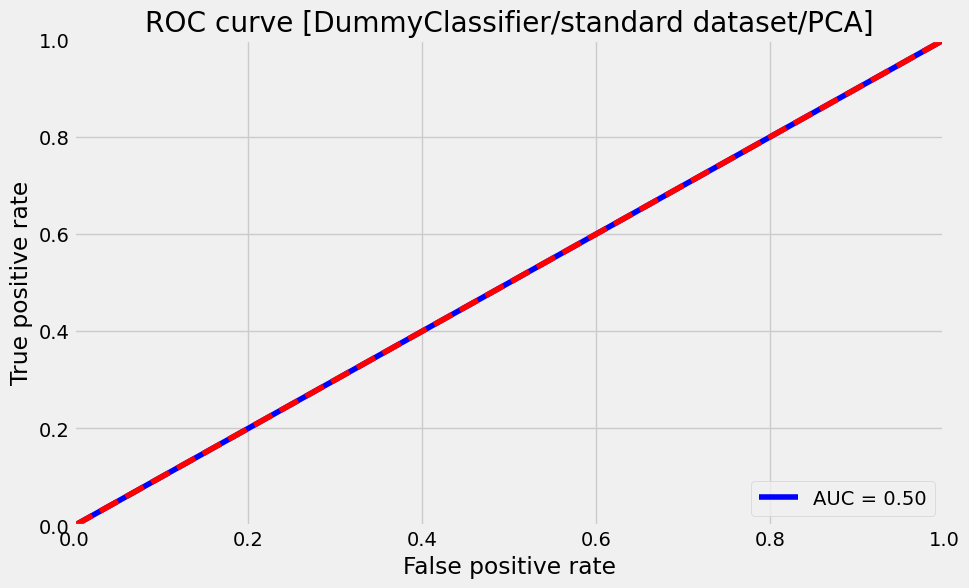

PCA (0.99): OK (554 features less). Time: 0.0 sec.

>>> Prediction [DummyClassifier/polynomial dataset/PCA] in progress...

[DummyClassifier/polynomial dataset/PCA] Business_score score: 0.9196
[DummyClassifier/polynomial dataset/PCA] Accuracy score: 0.9196
[DummyClassifier/polynomial dataset/PCA] ROC AUC score: 0.5
[DummyClassifier/polynomial dataset/PCA] Time: 0.0 sec.

Prediction storage: OK (./calc/DummyClassifierPredictionPolynomialPCA.csv).



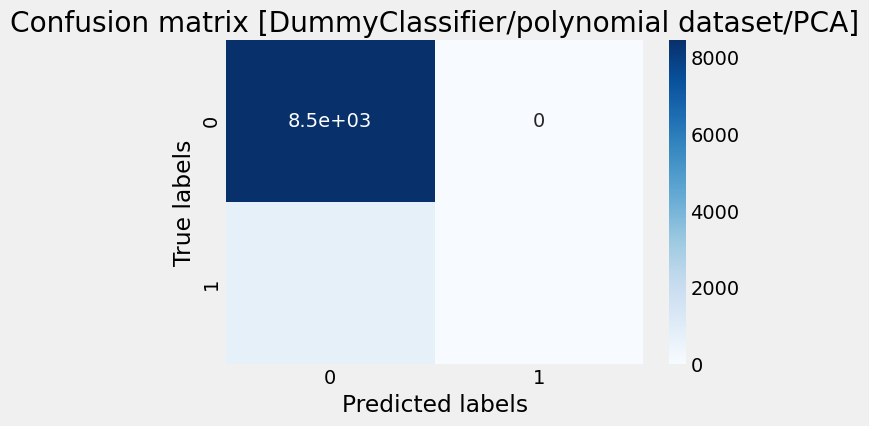

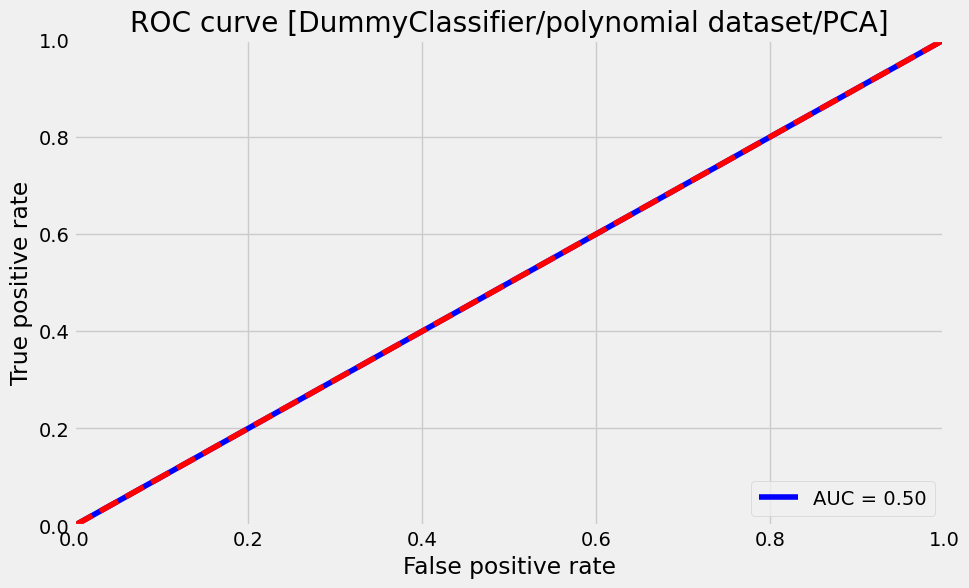

>>> Prediction [DummyClassifier/polynomial dataset] in progress...

[DummyClassifier/polynomial dataset] Business_score score: 0.9196
[DummyClassifier/polynomial dataset] Accuracy score: 0.9196
[DummyClassifier/polynomial dataset] ROC AUC score: 0.5
[DummyClassifier/polynomial dataset] Time: 0.0 sec.

Prediction storage: OK (./calc/DummyClassifierPredictionPolynomial.csv).



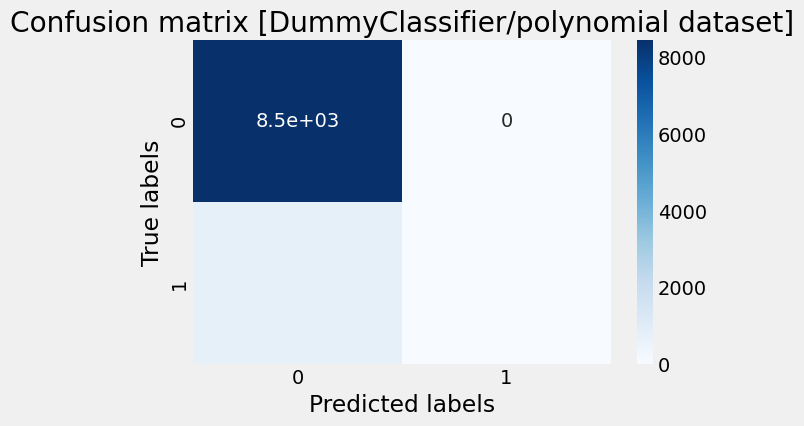

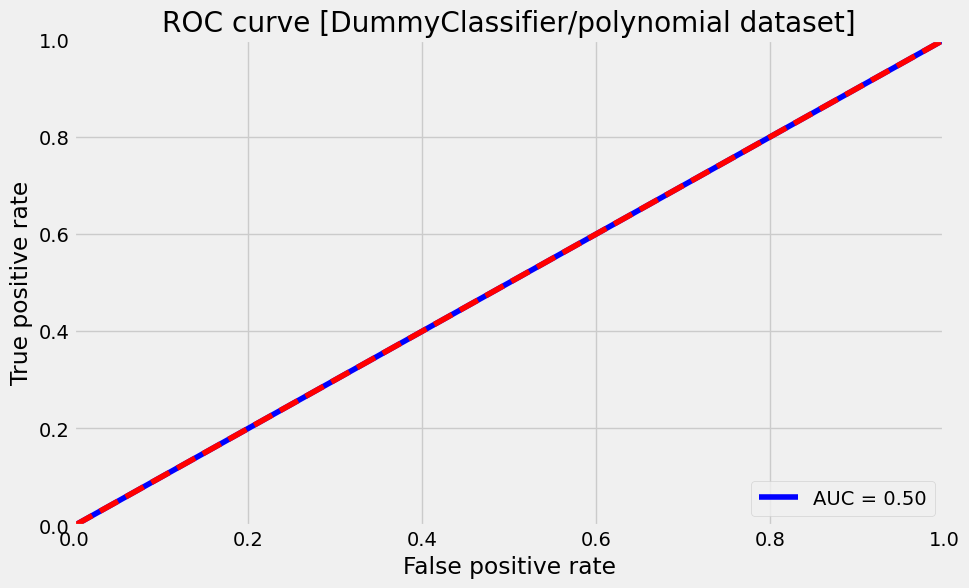

PCA (0.99): OK (519 features less). Time: 0.0 sec.

>>> Prediction [DummyClassifier/domain dataset/PCA] in progress...

[DummyClassifier/domain dataset/PCA] Business_score score: 0.9196
[DummyClassifier/domain dataset/PCA] Accuracy score: 0.9196
[DummyClassifier/domain dataset/PCA] ROC AUC score: 0.5
[DummyClassifier/domain dataset/PCA] Time: 0.0 sec.

Prediction storage: OK (./calc/DummyClassifierPredictionDomainPCA.csv).



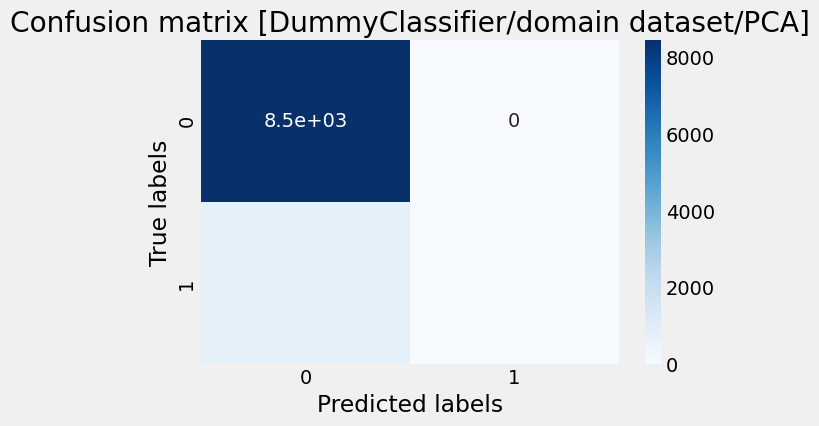

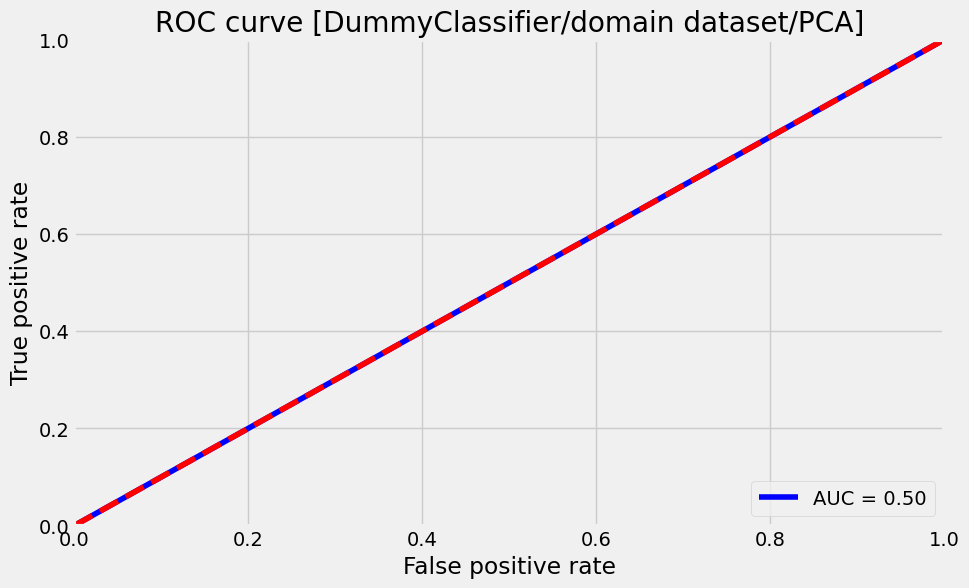

>>> Prediction [DummyClassifier/domain dataset] in progress...

[DummyClassifier/domain dataset] Business_score score: 0.9196
[DummyClassifier/domain dataset] Accuracy score: 0.9196
[DummyClassifier/domain dataset] ROC AUC score: 0.5
[DummyClassifier/domain dataset] Time: 0.0 sec.

Prediction storage: OK (./calc/DummyClassifierPredictionDomain.csv).



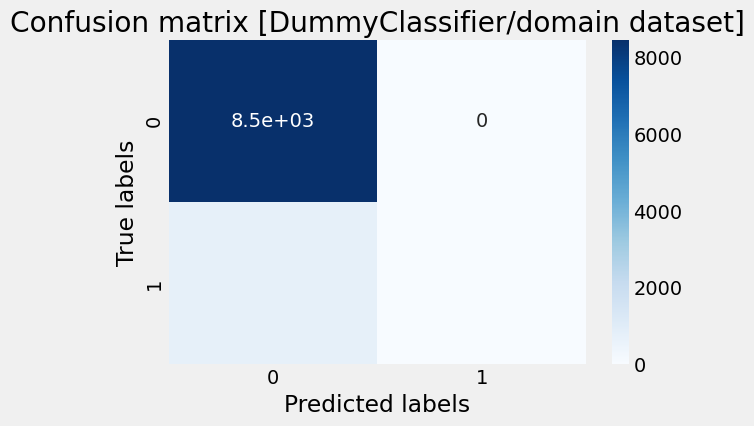

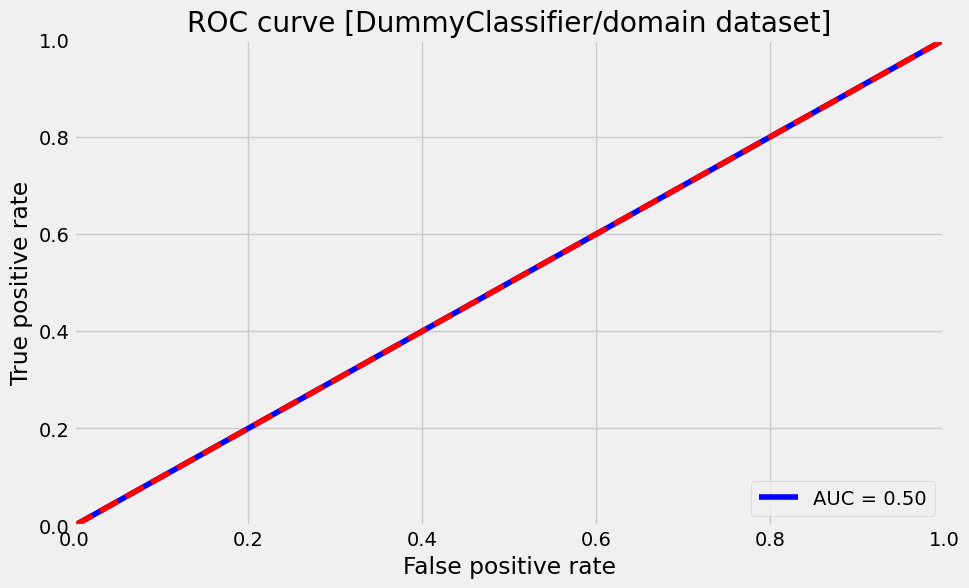

PCA (0.99): OK (515 features less). Time: 0.0 sec.

>>> Prediction [LogisticRegression/standard dataset/PCA] in progress...

[LogisticRegression/standard dataset/PCA] Business_score score: 0.9389
[LogisticRegression/standard dataset/PCA] Accuracy score: 0.672
[LogisticRegression/standard dataset/PCA] ROC AUC score: 0.6432
[LogisticRegression/standard dataset/PCA] Time: 0.0 sec.

Prediction storage: OK (./calc/LogisticRegressionPredictionStandardPCA.csv).



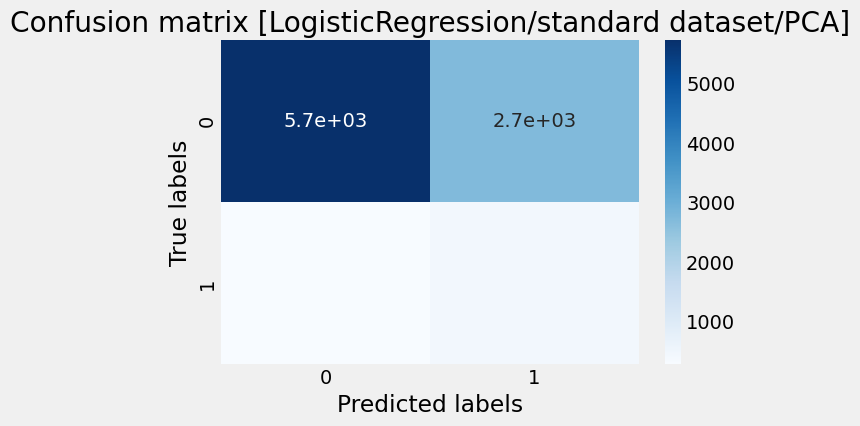

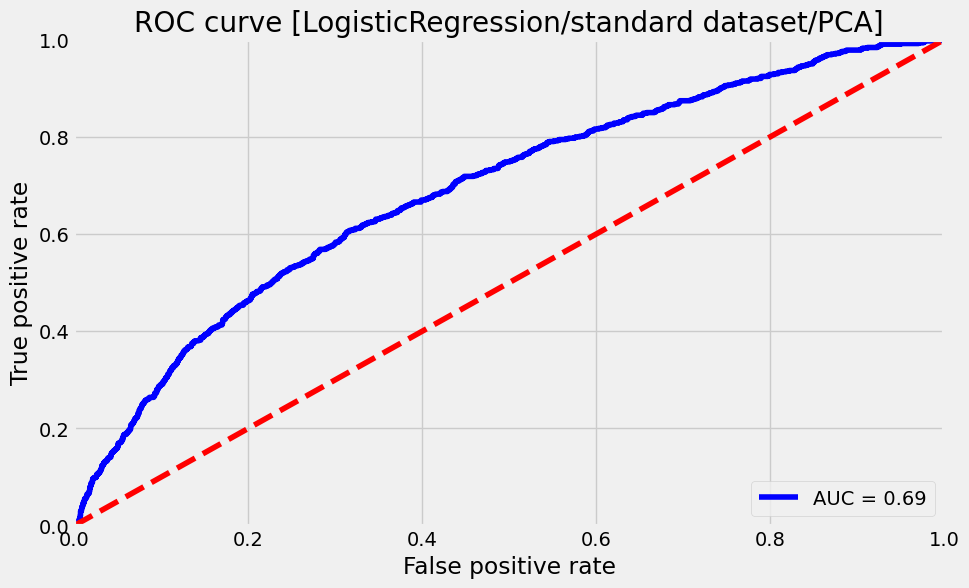

PCA (0.99): OK (554 features less). Time: 0.0 sec.

>>> Prediction [LogisticRegression/polynomial dataset/PCA] in progress...

[LogisticRegression/polynomial dataset/PCA] Business_score score: 0.9377
[LogisticRegression/polynomial dataset/PCA] Accuracy score: 0.669
[LogisticRegression/polynomial dataset/PCA] ROC AUC score: 0.636
[LogisticRegression/polynomial dataset/PCA] Time: 0.0 sec.

Prediction storage: OK (./calc/LogisticRegressionPredictionPolynomialPCA.csv).



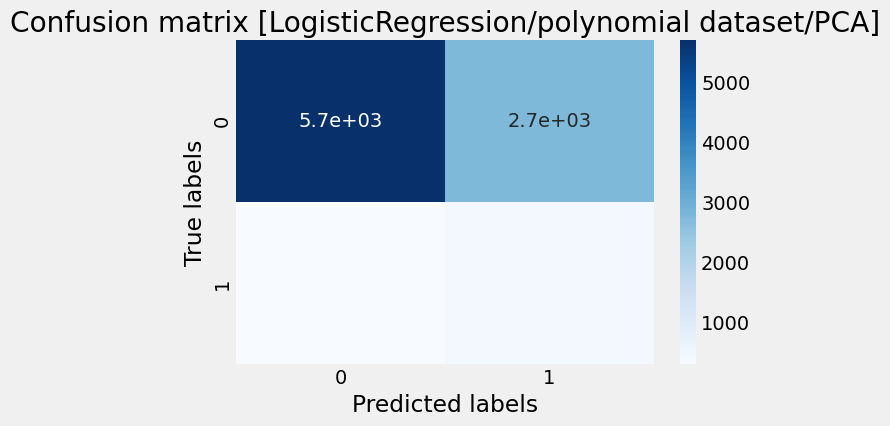

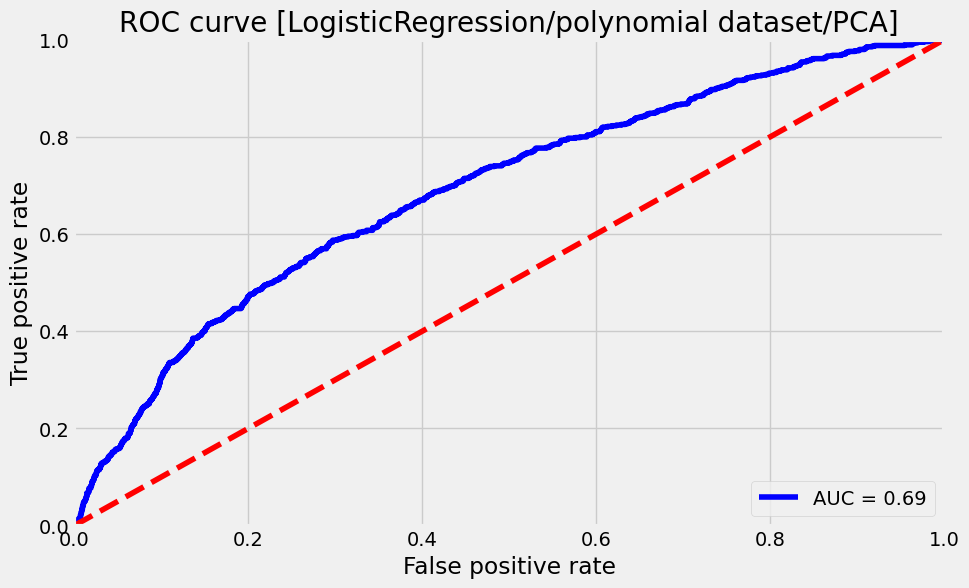

>>> Prediction [LogisticRegression/polynomial dataset] in progress...

[LogisticRegression/polynomial dataset] Business_score score: 0.9387
[LogisticRegression/polynomial dataset] Accuracy score: 0.6855
[LogisticRegression/polynomial dataset] ROC AUC score: 0.6407
[LogisticRegression/polynomial dataset] Time: 0.0 sec.

Prediction storage: OK (./calc/LogisticRegressionPredictionPolynomial.csv).



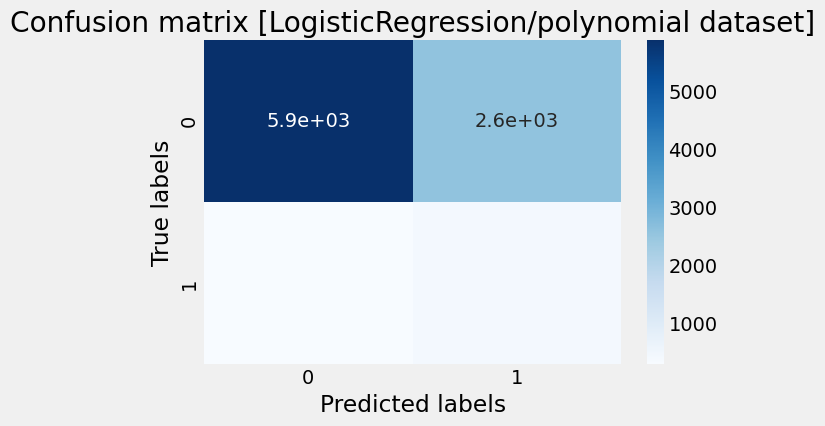

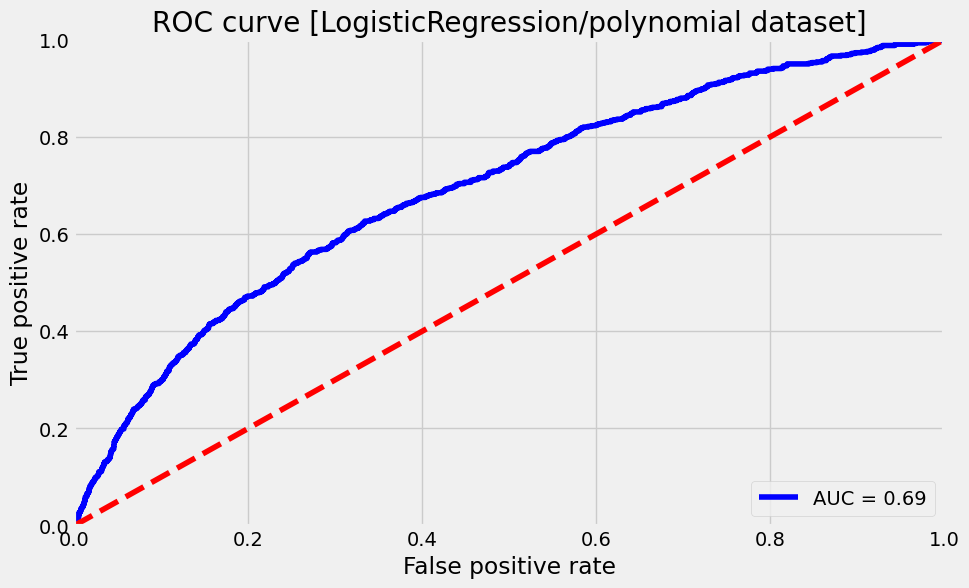

PCA (0.99): OK (519 features less). Time: 0.0 sec.

>>> Prediction [LogisticRegression/domain dataset/PCA] in progress...

[LogisticRegression/domain dataset/PCA] Business_score score: 0.939
[LogisticRegression/domain dataset/PCA] Accuracy score: 0.673
[LogisticRegression/domain dataset/PCA] ROC AUC score: 0.6438
[LogisticRegression/domain dataset/PCA] Time: 0.0 sec.

Prediction storage: OK (./calc/LogisticRegressionPredictionDomainPCA.csv).



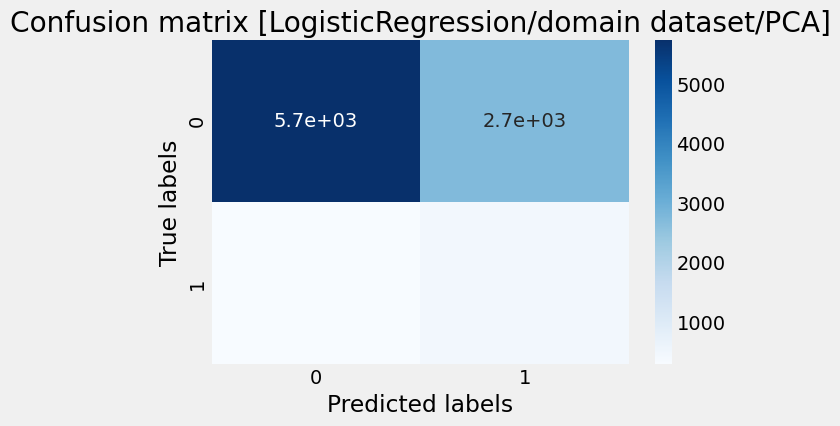

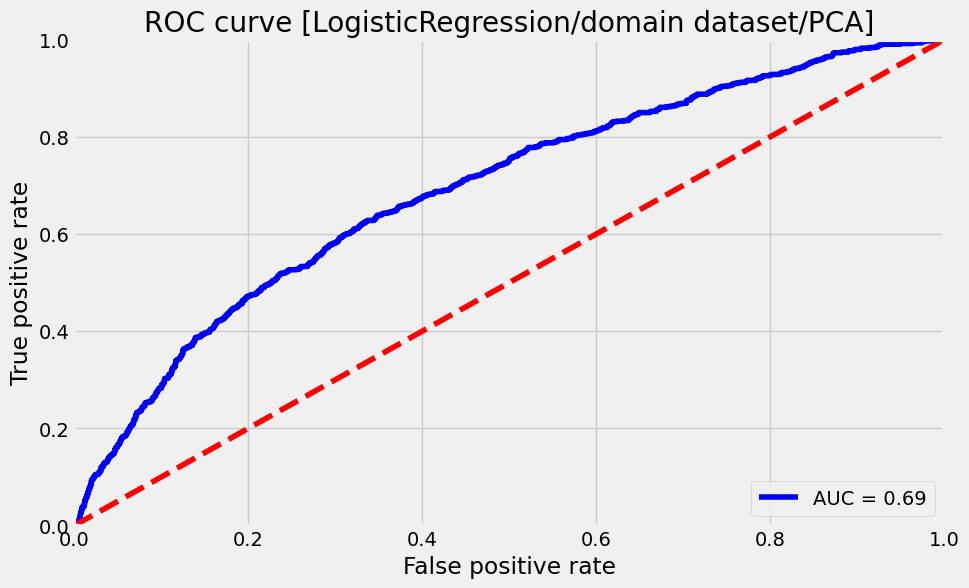

>>> Prediction [LogisticRegression/domain dataset] in progress...

[LogisticRegression/domain dataset] Business_score score: 0.9391
[LogisticRegression/domain dataset] Accuracy score: 0.6866
[LogisticRegression/domain dataset] ROC AUC score: 0.6432
[LogisticRegression/domain dataset] Time: 0.0 sec.

Prediction storage: OK (./calc/LogisticRegressionPredictionDomain.csv).



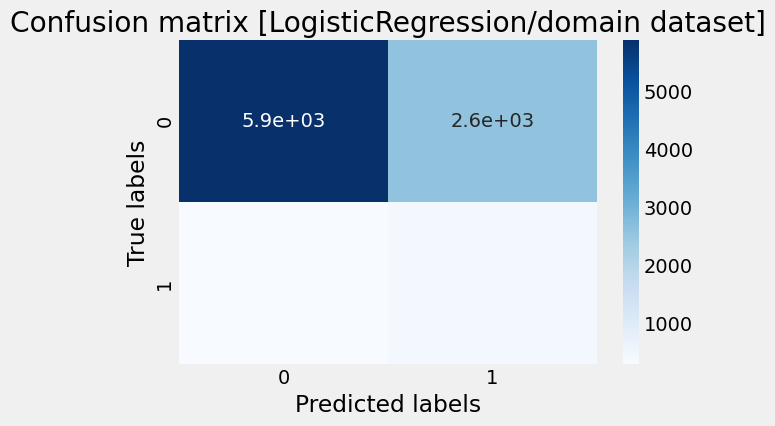

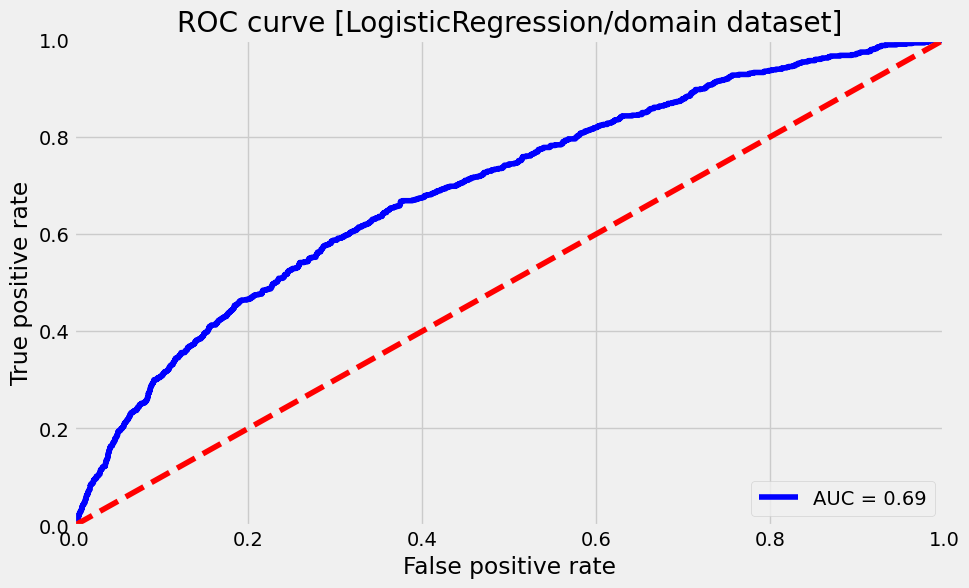

PCA (0.99): OK (515 features less). Time: 0.0 sec.

>>> Prediction [BalancedRandomForestClassifier/standard dataset/PCA] in progress...

[BalancedRandomForestClassifier/standard dataset/PCA] Business_score score: 0.9348
[BalancedRandomForestClassifier/standard dataset/PCA] Accuracy score: 0.644
[BalancedRandomForestClassifier/standard dataset/PCA] ROC AUC score: 0.6194
[BalancedRandomForestClassifier/standard dataset/PCA] Time: 17.0 sec.

Prediction storage: OK (./calc/BalancedRandomForestClassifierPredictionStandardPCA.csv).



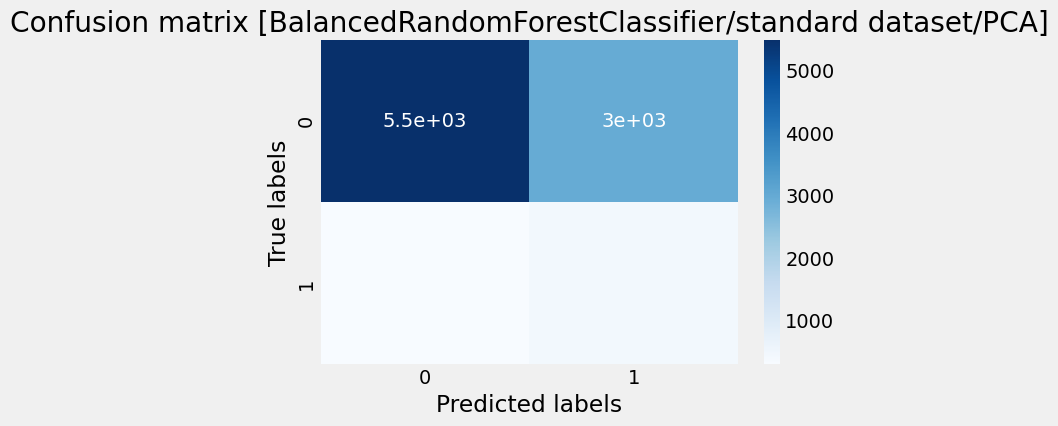

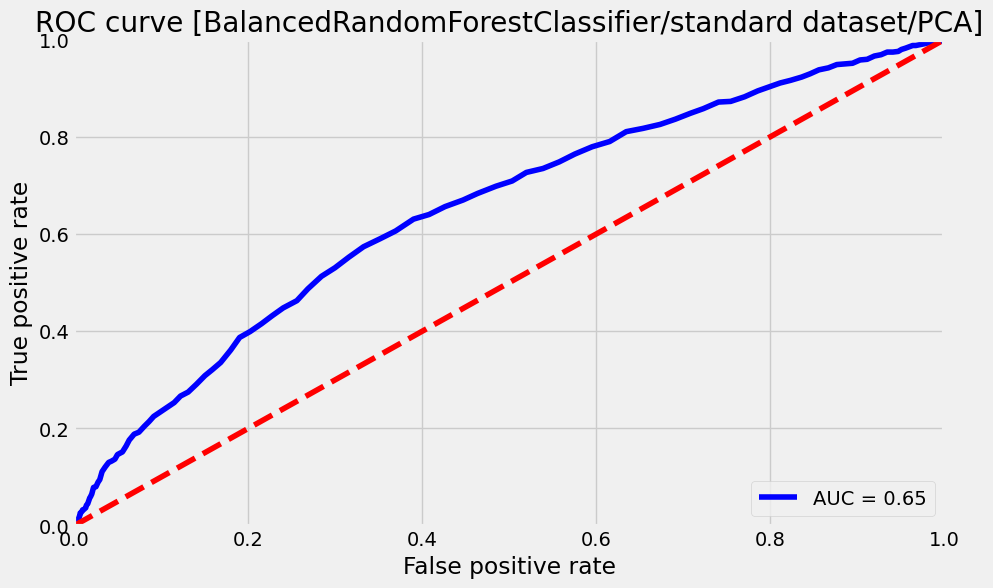

PCA (0.99): OK (554 features less). Time: 0.0 sec.

>>> Prediction [BalancedRandomForestClassifier/polynomial dataset/PCA] in progress...

[BalancedRandomForestClassifier/polynomial dataset/PCA] Business_score score: 0.9353
[BalancedRandomForestClassifier/polynomial dataset/PCA] Accuracy score: 0.643
[BalancedRandomForestClassifier/polynomial dataset/PCA] ROC AUC score: 0.6232
[BalancedRandomForestClassifier/polynomial dataset/PCA] Time: 17.0 sec.

Prediction storage: OK (./calc/BalancedRandomForestClassifierPredictionPolynomialPCA.csv).



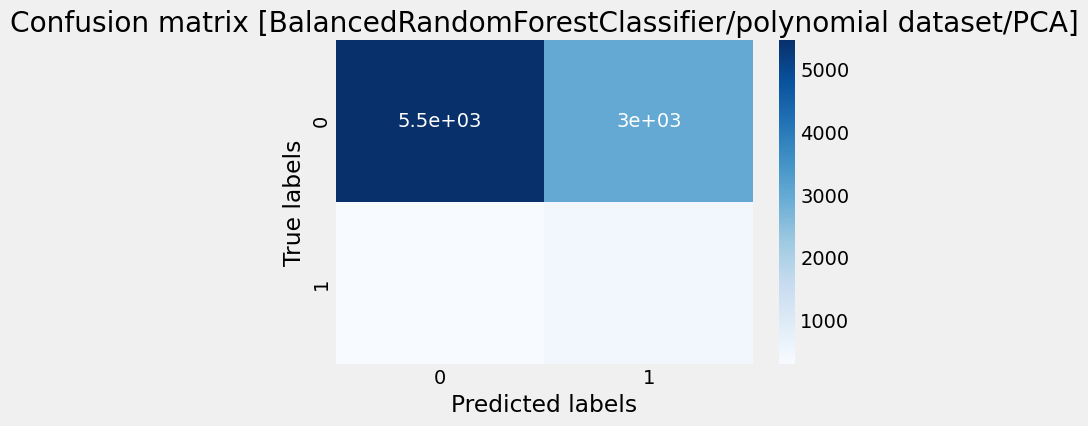

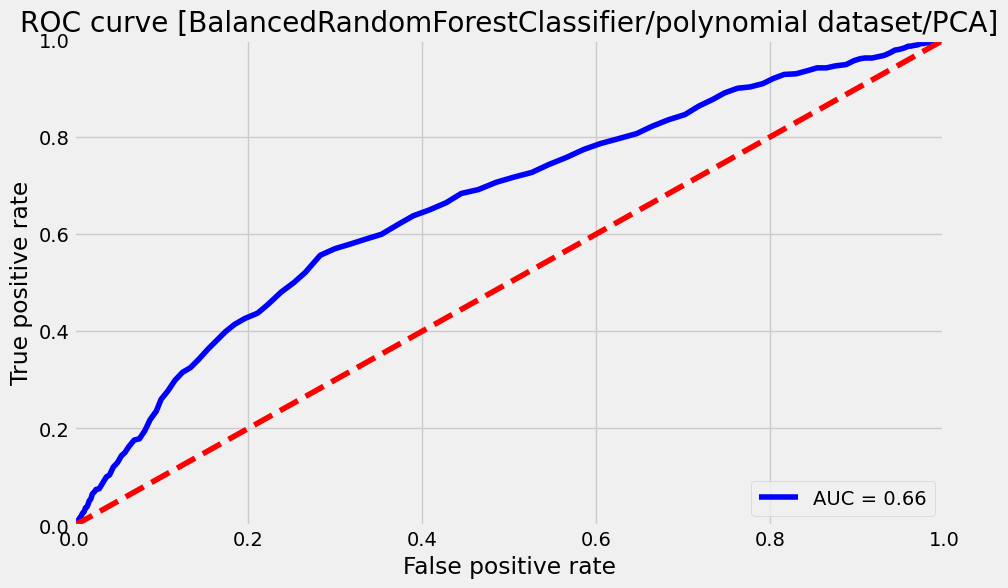

>>> Prediction [BalancedRandomForestClassifier/polynomial dataset] in progress...

[BalancedRandomForestClassifier/polynomial dataset] Business_score score: 0.9371
[BalancedRandomForestClassifier/polynomial dataset] Accuracy score: 0.6485
[BalancedRandomForestClassifier/polynomial dataset] ROC AUC score: 0.6335
[BalancedRandomForestClassifier/polynomial dataset] Time: 10.0 sec.

Prediction storage: OK (./calc/BalancedRandomForestClassifierPredictionPolynomial.csv).



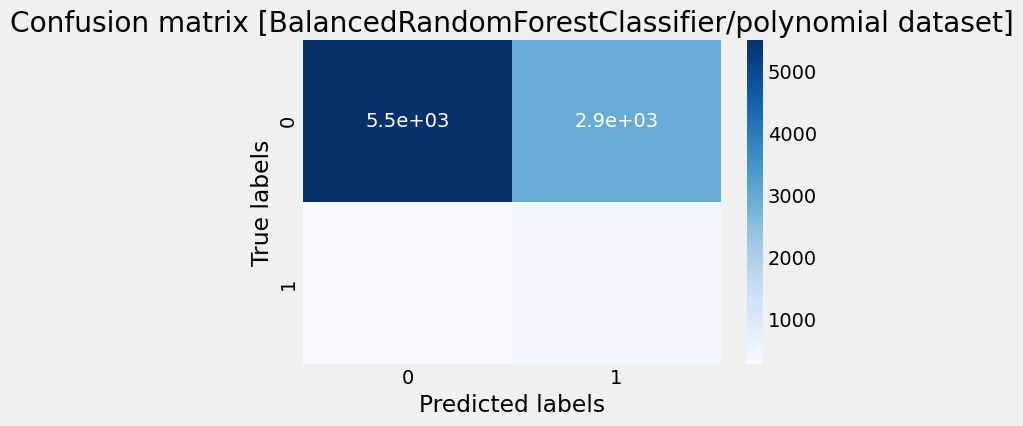

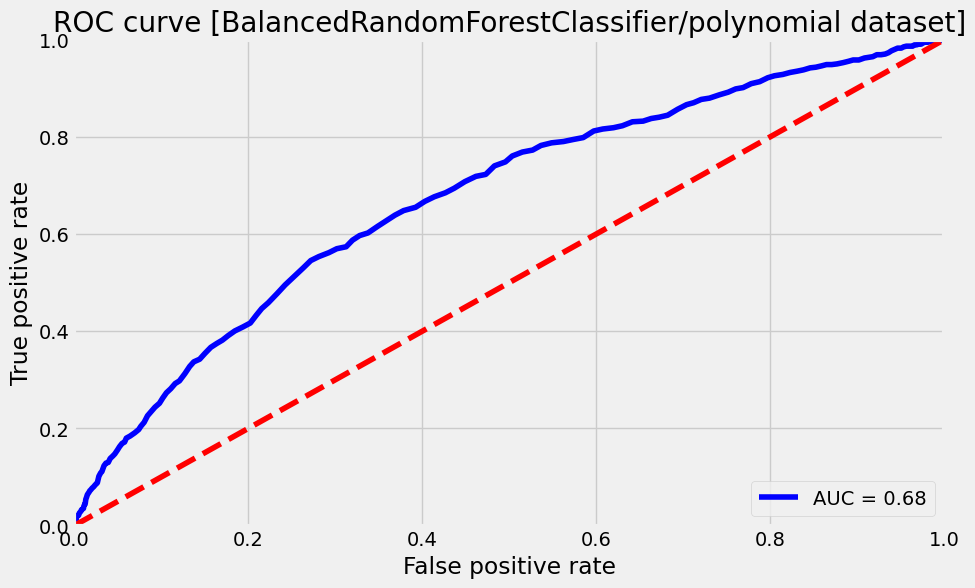

PCA (0.99): OK (519 features less). Time: 0.0 sec.

>>> Prediction [BalancedRandomForestClassifier/domain dataset/PCA] in progress...

[BalancedRandomForestClassifier/domain dataset/PCA] Business_score score: 0.9358
[BalancedRandomForestClassifier/domain dataset/PCA] Accuracy score: 0.6533
[BalancedRandomForestClassifier/domain dataset/PCA] ROC AUC score: 0.625
[BalancedRandomForestClassifier/domain dataset/PCA] Time: 16.0 sec.

Prediction storage: OK (./calc/BalancedRandomForestClassifierPredictionDomainPCA.csv).



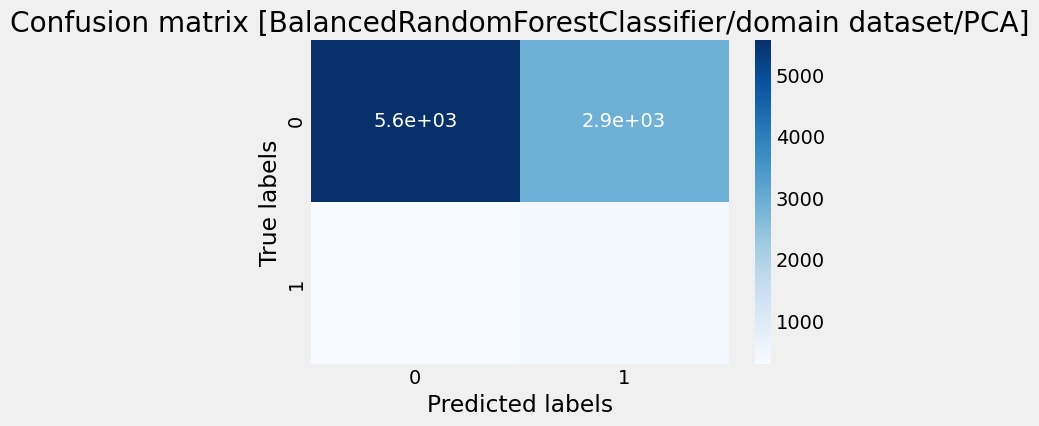

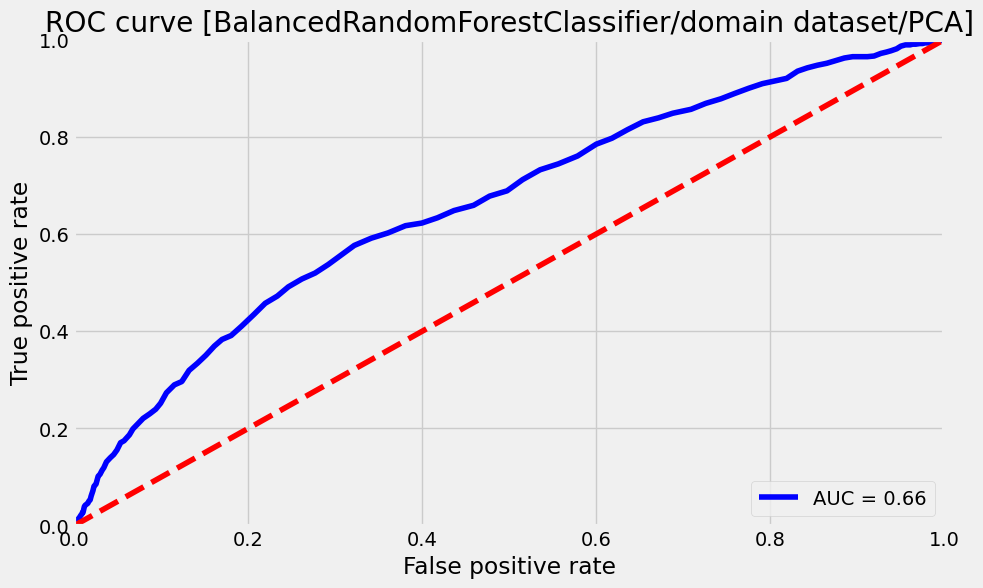

>>> Prediction [BalancedRandomForestClassifier/domain dataset] in progress...

[BalancedRandomForestClassifier/domain dataset] Business_score score: 0.9365
[BalancedRandomForestClassifier/domain dataset] Accuracy score: 0.657
[BalancedRandomForestClassifier/domain dataset] ROC AUC score: 0.6295
[BalancedRandomForestClassifier/domain dataset] Time: 9.0 sec.

Prediction storage: OK (./calc/BalancedRandomForestClassifierPredictionDomain.csv).



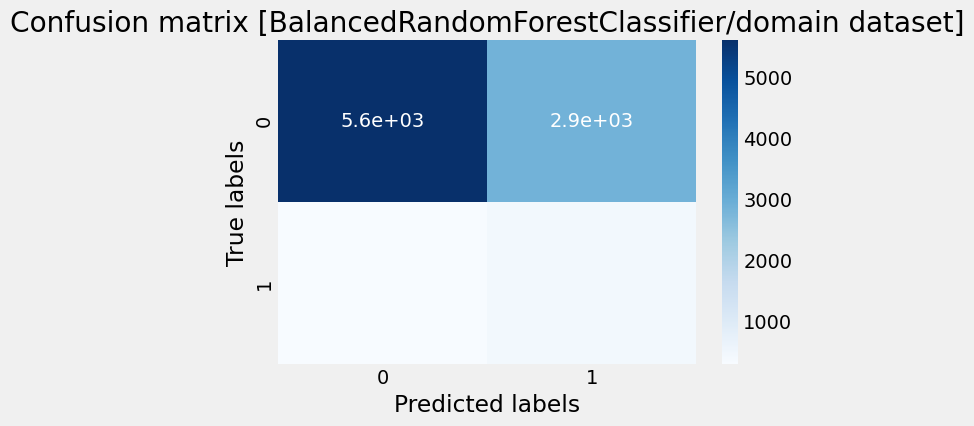

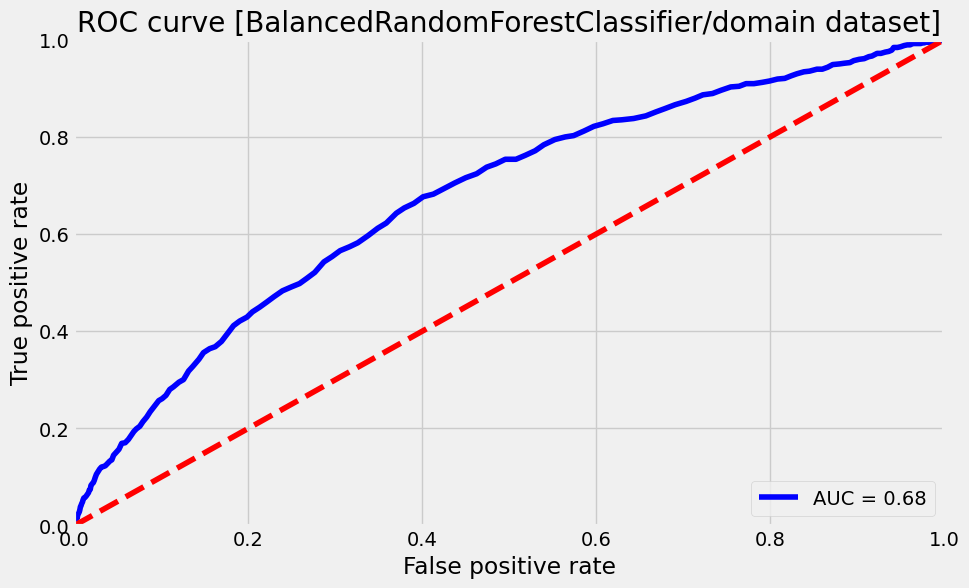

PCA (0.99): OK (515 features less). Time: 0.0 sec.

[LightGBM] [Info] Number of positive: 1706, number of negative: 19751
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016504 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 62475
[LightGBM] [Info] Number of data points in the train set: 21457, number of used features: 245
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
>>> Prediction [LGBMClassifier/standard dataset/PCA] in progress...

[LGBMClassifier/standard dataset/PCA] Business_score score: 0.9352
[LGBMClassifier/standard dataset/PCA] Accuracy score: 0.8095
[LGBMClassifier/standard dataset/PCA] ROC AUC score: 0.6075
[LGBMClassifier/standard dataset/PCA] Time: 1.0 sec.

Prediction storage: OK (./calc/LGBMClassifierPredictionStandardPCA.csv).



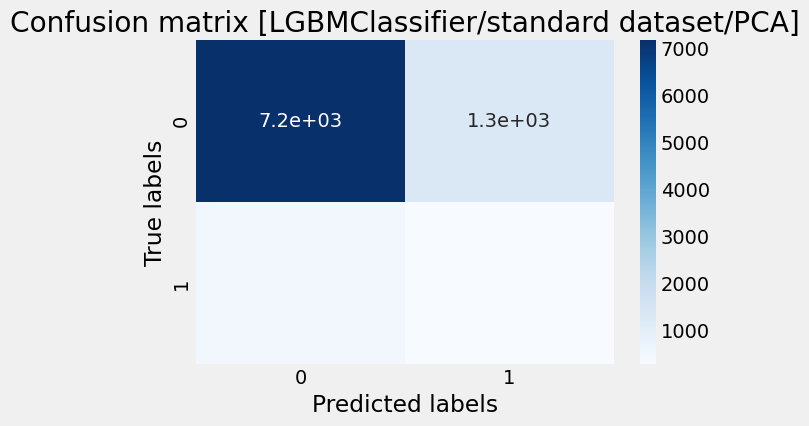

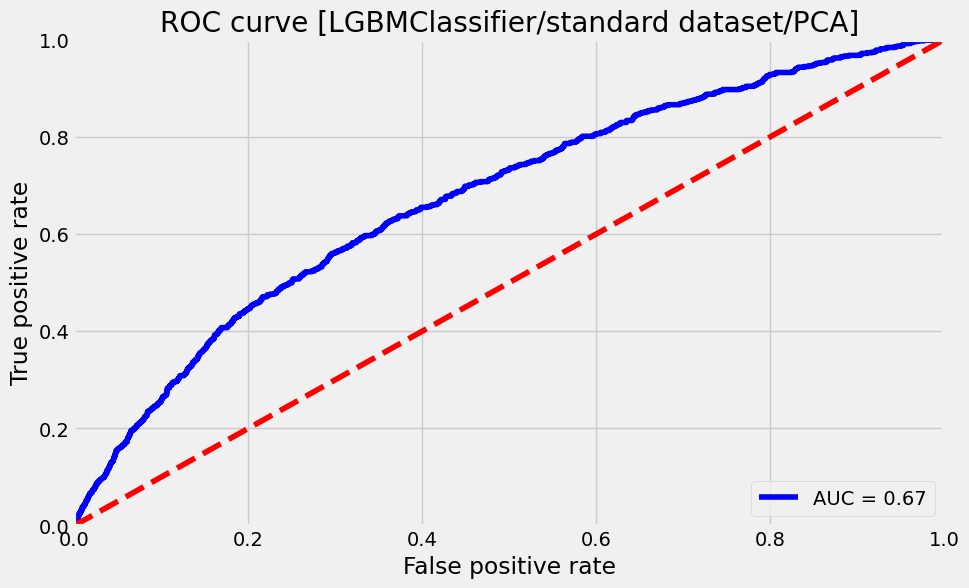

PCA (0.99): OK (554 features less). Time: 0.0 sec.

[LightGBM] [Info] Number of positive: 1706, number of negative: 19751
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017603 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 61455
[LightGBM] [Info] Number of data points in the train set: 21457, number of used features: 241
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
>>> Prediction [LGBMClassifier/polynomial dataset/PCA] in progress...

[LGBMClassifier/polynomial dataset/PCA] Business_score score: 0.935
[LGBMClassifier/polynomial dataset/PCA] Accuracy score: 0.8068
[LGBMClassifier/polynomial dataset/PCA] ROC AUC score: 0.6066
[LGBMClassifier/polynomial dataset/PCA] Time: 1.0 sec.

Prediction storage: OK (./calc/LGBMClassifierPredictionPolynomialPCA.csv).



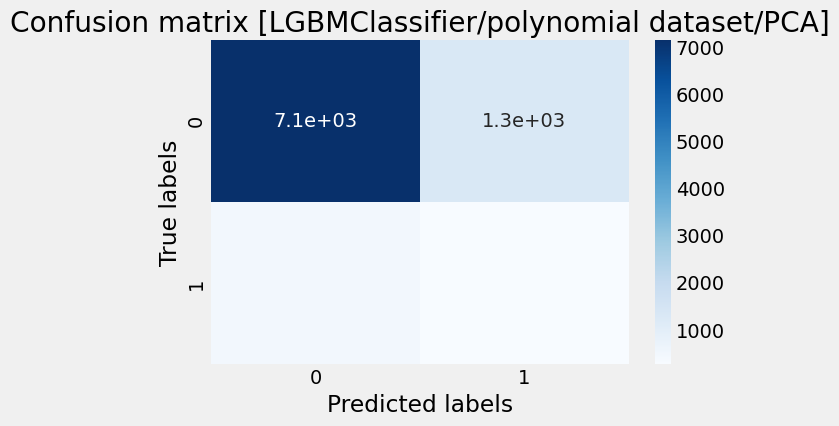

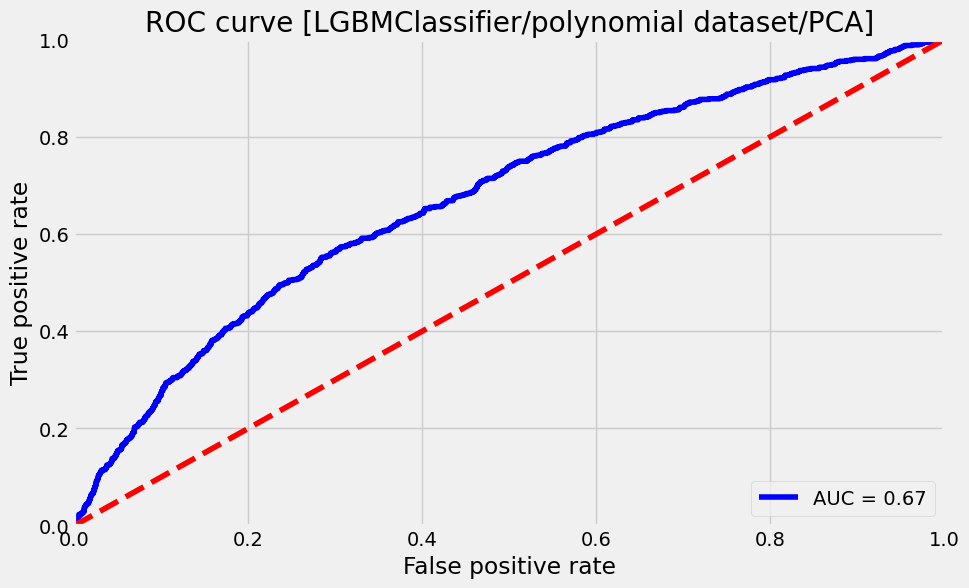

[LightGBM] [Info] Number of positive: 1706, number of negative: 19751
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.059880 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 88712
[LightGBM] [Info] Number of data points in the train set: 21457, number of used features: 697
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
>>> Prediction [LGBMClassifier/polynomial dataset] in progress...

[LGBMClassifier/polynomial dataset] Business_score score: 0.9385
[LGBMClassifier/polynomial dataset] Accuracy score: 0.7871
[LGBMClassifier/polynomial dataset] ROC AUC score: 0.6305
[LGBMClassifier/polynomial dataset] Time: 2.0 sec.

Prediction storage: OK (./calc/LGBMClassifierPredictionPolynomial.csv).



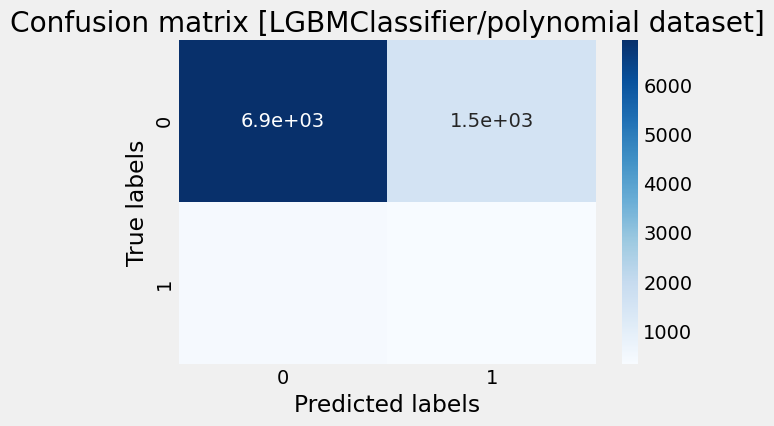

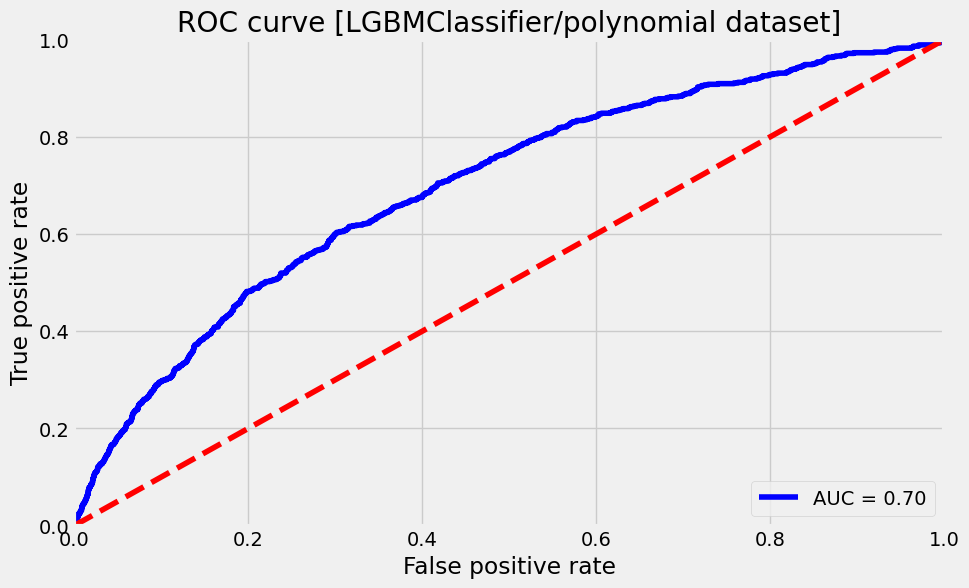

PCA (0.99): OK (519 features less). Time: 0.0 sec.

[LightGBM] [Info] Number of positive: 1706, number of negative: 19751
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017009 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 62475
[LightGBM] [Info] Number of data points in the train set: 21457, number of used features: 245
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
>>> Prediction [LGBMClassifier/domain dataset/PCA] in progress...

[LGBMClassifier/domain dataset/PCA] Business_score score: 0.9345
[LGBMClassifier/domain dataset/PCA] Accuracy score: 0.8092
[LGBMClassifier/domain dataset/PCA] ROC AUC score: 0.6036
[LGBMClassifier/domain dataset/PCA] Time: 1.0 sec.

Prediction storage: OK (./calc/LGBMClassifierPredictionDomainPCA.csv).



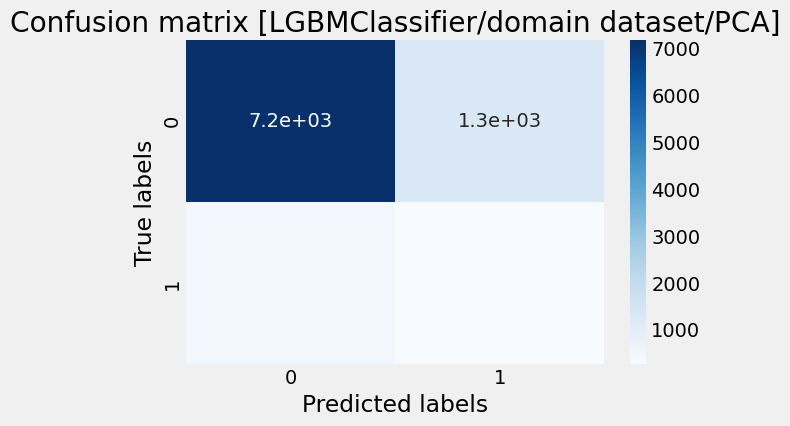

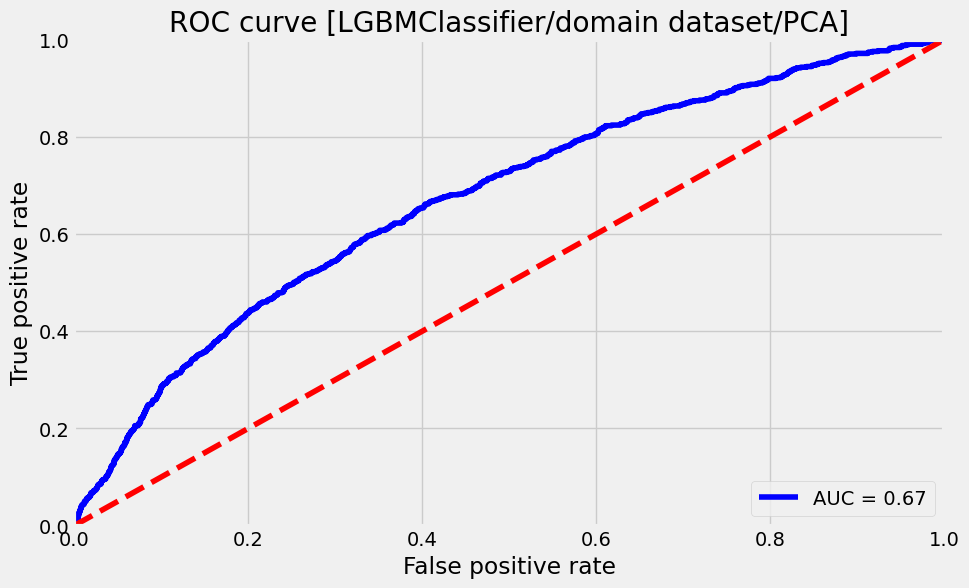

[LightGBM] [Info] Number of positive: 1706, number of negative: 19751
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.047240 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 81065
[LightGBM] [Info] Number of data points in the train set: 21457, number of used features: 667
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
>>> Prediction [LGBMClassifier/domain dataset] in progress...

[LGBMClassifier/domain dataset] Business_score score: 0.9366
[LGBMClassifier/domain dataset] Accuracy score: 0.7856
[LGBMClassifier/domain dataset] ROC AUC score: 0.6185
[LGBMClassifier/domain dataset] Time: 2.0 sec.

Prediction storage: OK (./calc/LGBMClassifierPredictionDomain.csv).



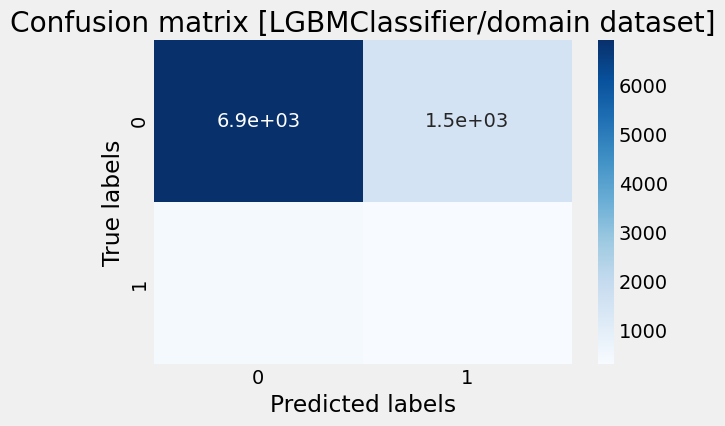

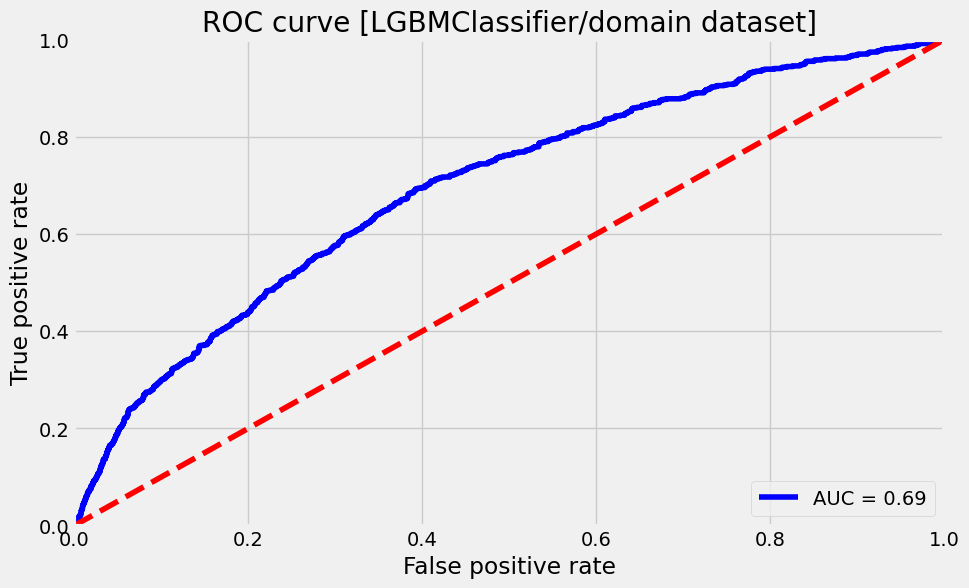

In [97]:
# Further tests (without parameters optimization & Gradient Boosting removed)
model_list = [dummy, lr, brf, gb]
train_test_set_list = [train_test_set_std, train_test_set_poly, train_test_set_domain]
set_type_list = ['standard', 'polynomial', 'domain']
app_pca_list = [True, False]
best_param_list = param_list
for n, model in enumerate(model_list):
    for i, train_test_set in enumerate(train_test_set_list):
        for app_pca in app_pca_list:
            if((i!=0)|(app_pca!=False)): # Standard dataset without PCA have already been tested
                apply_model(model, 
                            train_test_set, 
                            best_param_list[n],
                            dataset=set_type_list[i],
                            validate=False,
                            calc=calc_pred,
                            app_pca=app_pca,
                            plot=True)

### 5.4.1 Comparing all dataset and all models

In [98]:
def get_param_dict(model_list, param_list):
    param_dict = dict()
    for i, m in enumerate(model_list):
        param_dict[m] = param_list[i]
    return param_dict

In [99]:
param_dict = get_param_dict(model_list, param_list)

In [100]:
def get_comp_dict(res_list, param_dict):
    comp_dict = dict()
    for i, elt in enumerate(res_list):
        model_dataset = get_model_name(elt['model']) + elt['dataset_type'].capitalize()
        if(elt['pca']):
            model_dataset += 'PCA'
        comp_dict[model_dataset] = elt
        comp_dict[model_dataset]['model_name'] = get_model_name(comp_dict[model_dataset]['model'])
        params = param_dict[comp_dict[model_dataset]['model']]
        comp_dict[model_dataset]['params'] = params
    return comp_dict

In [101]:
def get_df_comp(res_list, param_dict):
    comp_dict = get_comp_dict(res_list, param_dict)
    cols = ['key', 'model', 'model_name', 'dataset_type', 'pca', 'score_spec', 'accuracy', 'roc_auc', 'elapsed_time', 'params']
    r = 4
    idx = list(np.arange(0,len(res_list)))
    df_comp = pd.DataFrame(columns=cols, index=idx)
    for i, elt in enumerate(comp_dict):
        df_comp.iloc[i][cols[0]] = elt
        for col in cols[1:]:
            #df_comp.iloc[i][col] = get_model_name(comp_dict[elt][col])
            df_comp.iloc[i][col] = comp_dict[elt][col]
    df_comp['score_spec'] = pd.to_numeric(df_comp['score_spec']).round(r)
    df_comp['accuracy'] = pd.to_numeric(df_comp['accuracy']).round(r)
    df_comp['roc_auc'] = pd.to_numeric(df_comp['roc_auc']).round(r)
    df_comp['elapsed_time'] = pd.to_numeric(df_comp['elapsed_time'])
    df_comp = df_comp.sort_values(['score_spec', 'accuracy', 'roc_auc', 'elapsed_time'], ascending=[False, False, False, True])
    return df_comp

In [102]:
df_comp = get_df_comp(res_list, param_dict)
cols_to_show = df_comp.columns[2:-1]
df_comp[cols_to_show]

model_name dataset_type    pca  score_spec  accuracy  \
13              LogisticRegression       domain  False      0.9391    0.6866   
1               LogisticRegression     standard  False      0.9391    0.6866   
12              LogisticRegression       domain   True      0.9390    0.6730   
9               LogisticRegression     standard   True      0.9389    0.6720   
11              LogisticRegression   polynomial  False      0.9387    0.6855   
21                  LGBMClassifier   polynomial  False      0.9385    0.7871   
10              LogisticRegression   polynomial   True      0.9377    0.6690   
2   BalancedRandomForestClassifier     standard  False      0.9373    0.6502   
3                   LGBMClassifier     standard  False      0.9371    0.7849   
16  BalancedRandomForestClassifier   polynomial  False      0.9371    0.6485   
23                  LGBMClassifier       domain  False      0.9366    0.7856   
18  BalancedRandomForestClassifier       domain  False      0.9365    0.6570   
17  BalancedRandomForestClassifier       domain   True      0.9358    0.6533   
15  BalancedRandomForestClassifier   polynomial   True      0.9353    0.6430   
19                  LGBMClassifier     standard   True      0.9352    0.8095   
20                  LGBMClassifier   polynomial   True      0.9350    0.8068   
14  BalancedRandomForestClassifier     standard   True      0.9348    0.6440   
22                  LGBMClassifier       domain   True      0.9345    0.8092   
0                  DummyClassifier     standard  False      0.9196    0.9196   
4                  DummyClassifier     standard   True      0.9196    0.9196   
5                  DummyClassifier   polynomial   True      0.9196    0.9196   
6                  DummyClassifier   polynomial  False      0.9196    0.9196   
7                  DummyClassifier       domain   True      0.9196    0.9196   
8                  DummyClassifier       domain  False      0.9196    0.9196   

    roc_auc  elapsed_time  
13   0.6926           0.0  
1    0.6922           0.0  
12   0.6898           0.0  
9    0.6892           0.0  
11   0.6929           0.0  
21   0.6972           2.0  
10   0.6890           0.0  
2    0.6753           9.0  
3    0.6928           2.0  
16   0.6754          10.0  
23   0.6931           2.0  
18   0.6770           9.0  
17   0.6604          16.0  
15   0.6629          17.0  
19   0.6750           1.0  
20   0.6717           1.0  
14   0.6513          17.0  
22   0.6727           1.0  
0    0.5000           0.0  
4    0.5000           0.0  
5    0.5000           0.0  
6    0.5000           0.0  
7    0.5000           0.0  
8    0.5000           0.0

In [103]:
def plot_compare(df, col, asc=False):
    df = df.sort_values(col, ascending=asc)
    fig = plt.figure(figsize=(20,9))
    plt.bar(x=df['key'], height=df[col])
    plt.xticks(rotation=80)
    max_val = df[col].max()
    title = f"Models and datasets comparison: {col}"
    plt.title(title)
    plt.show()

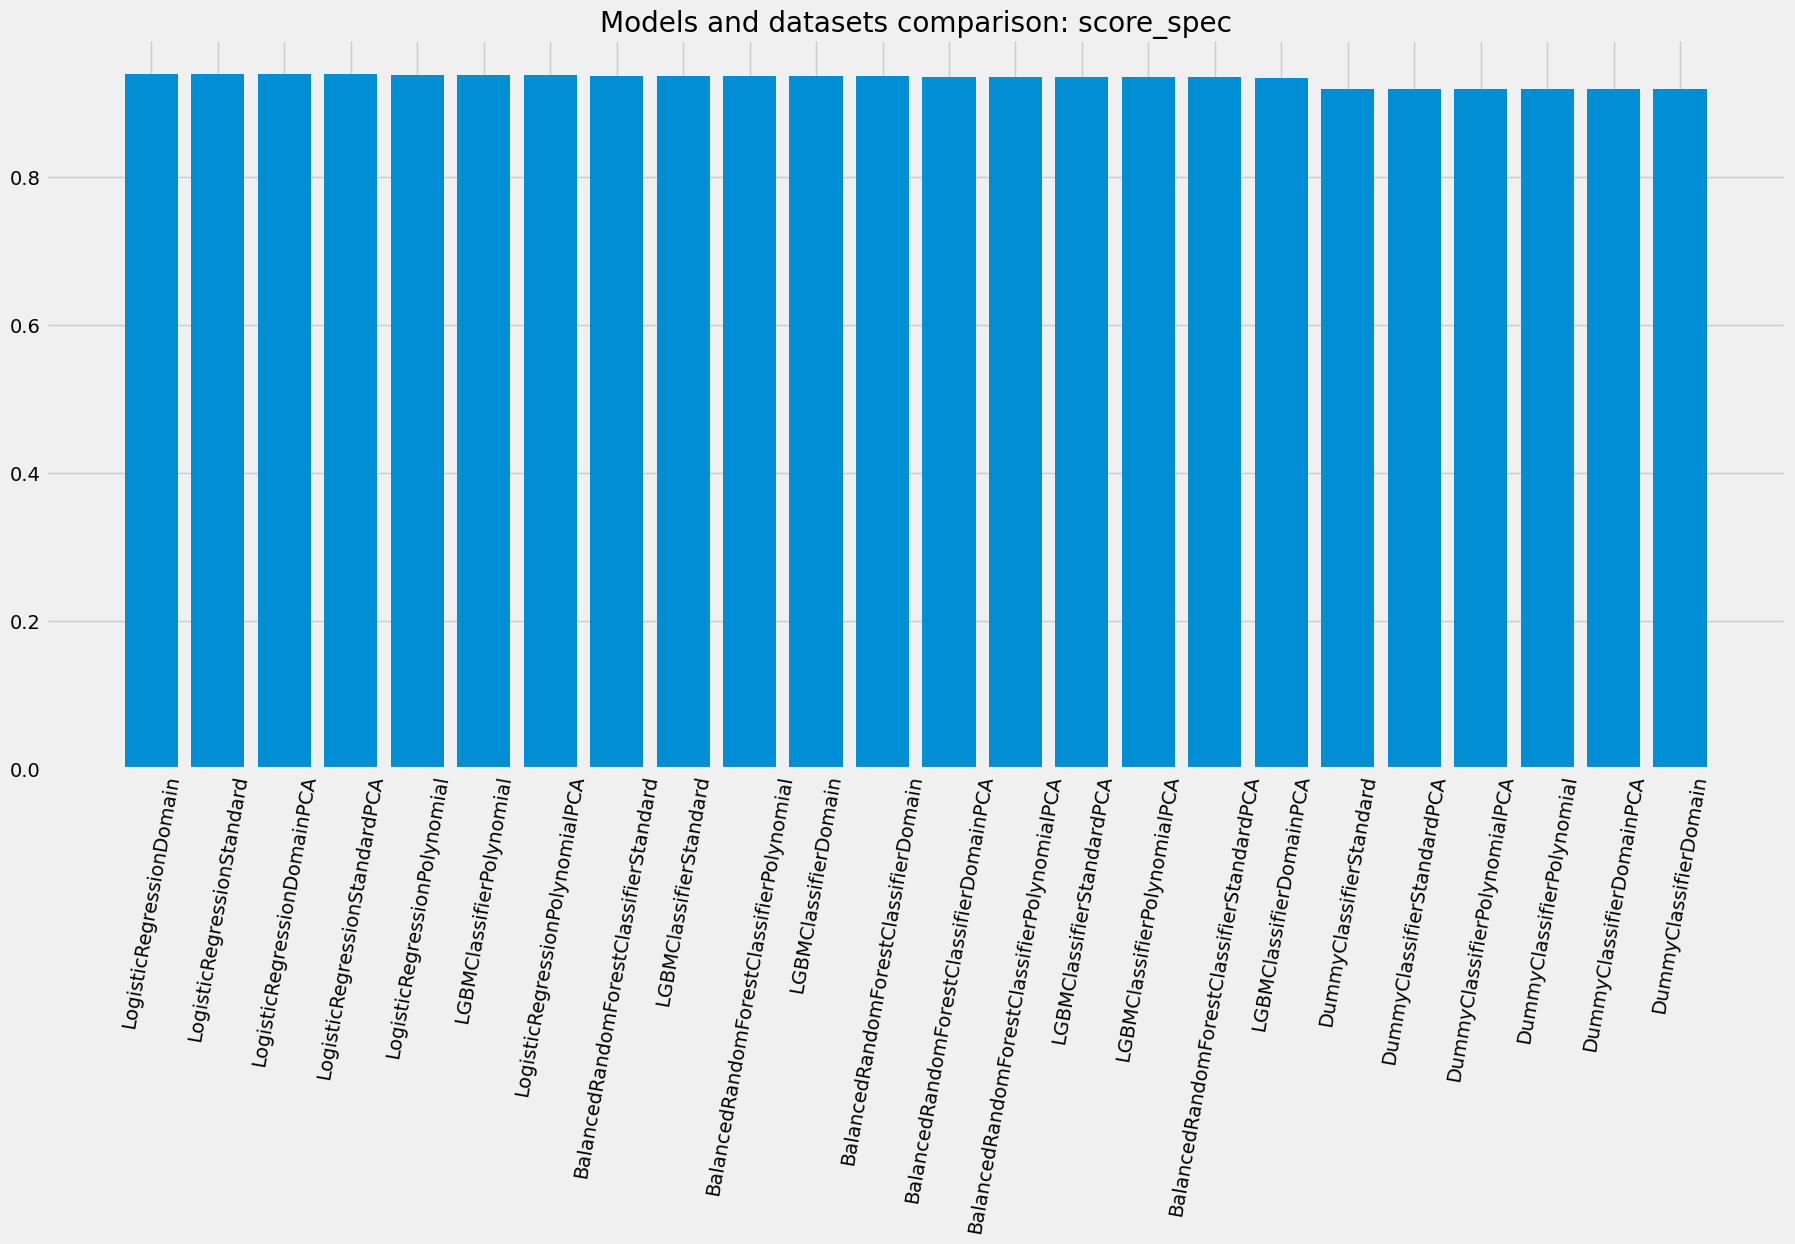

In [104]:
plot_compare(df_comp, 'score_spec')

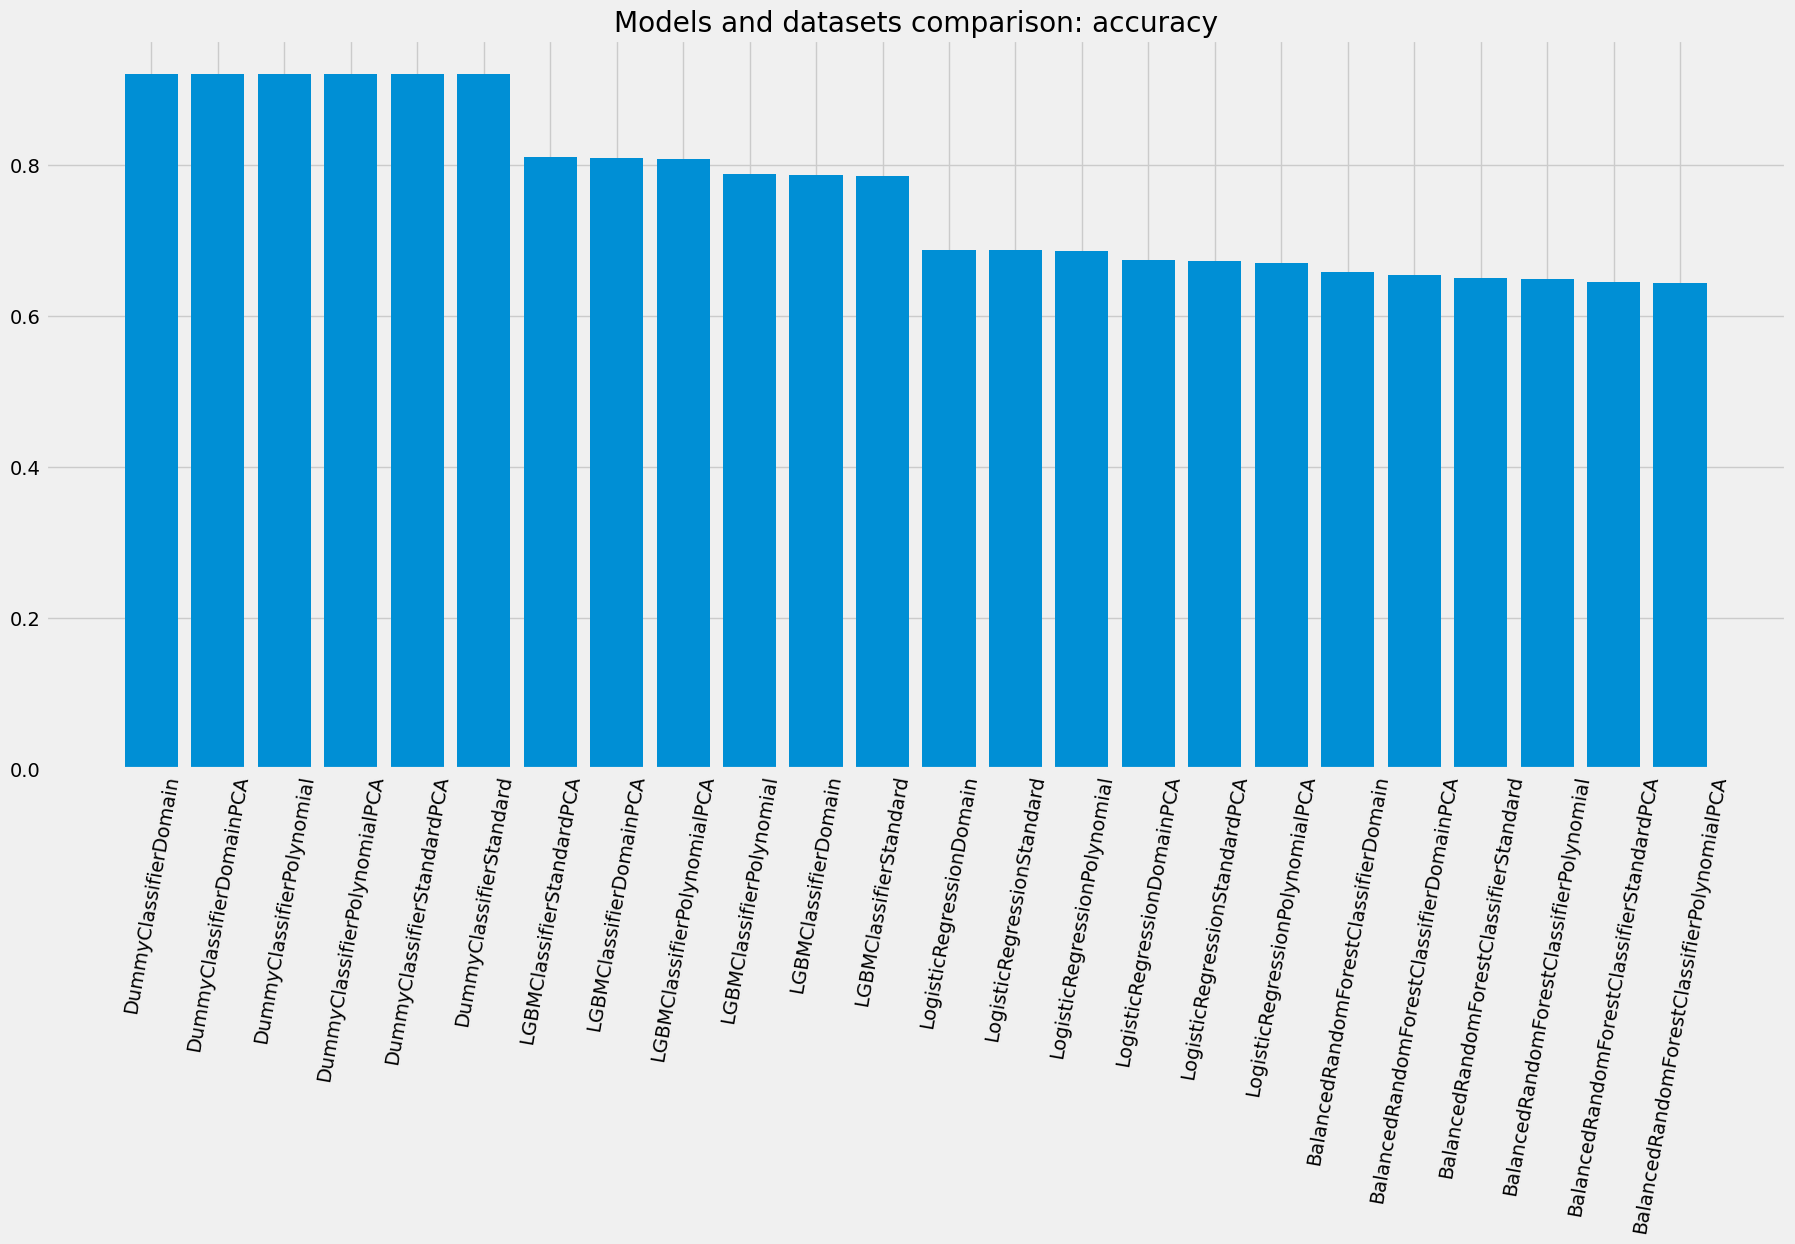

In [105]:
plot_compare(df_comp, 'accuracy')

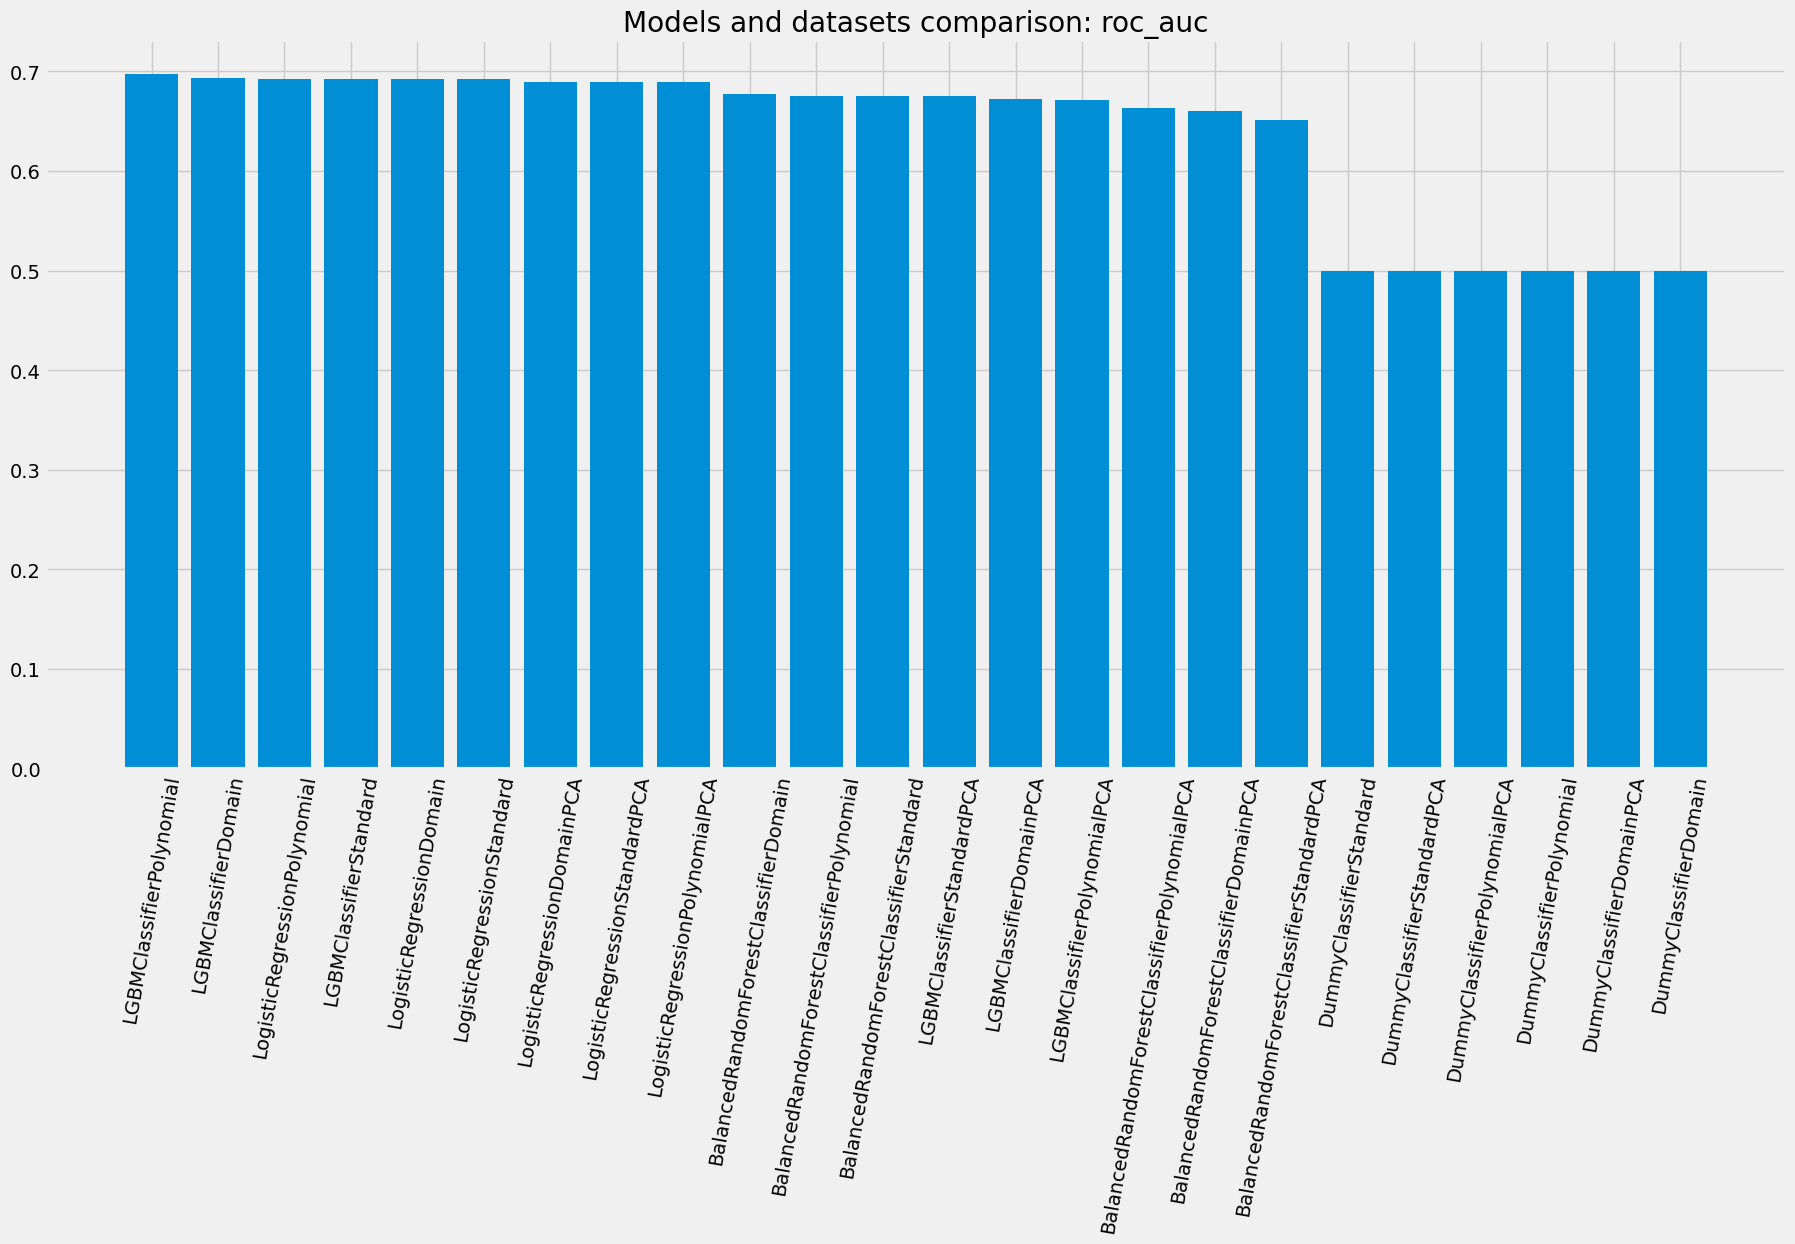

In [106]:
plot_compare(df_comp, 'roc_auc')

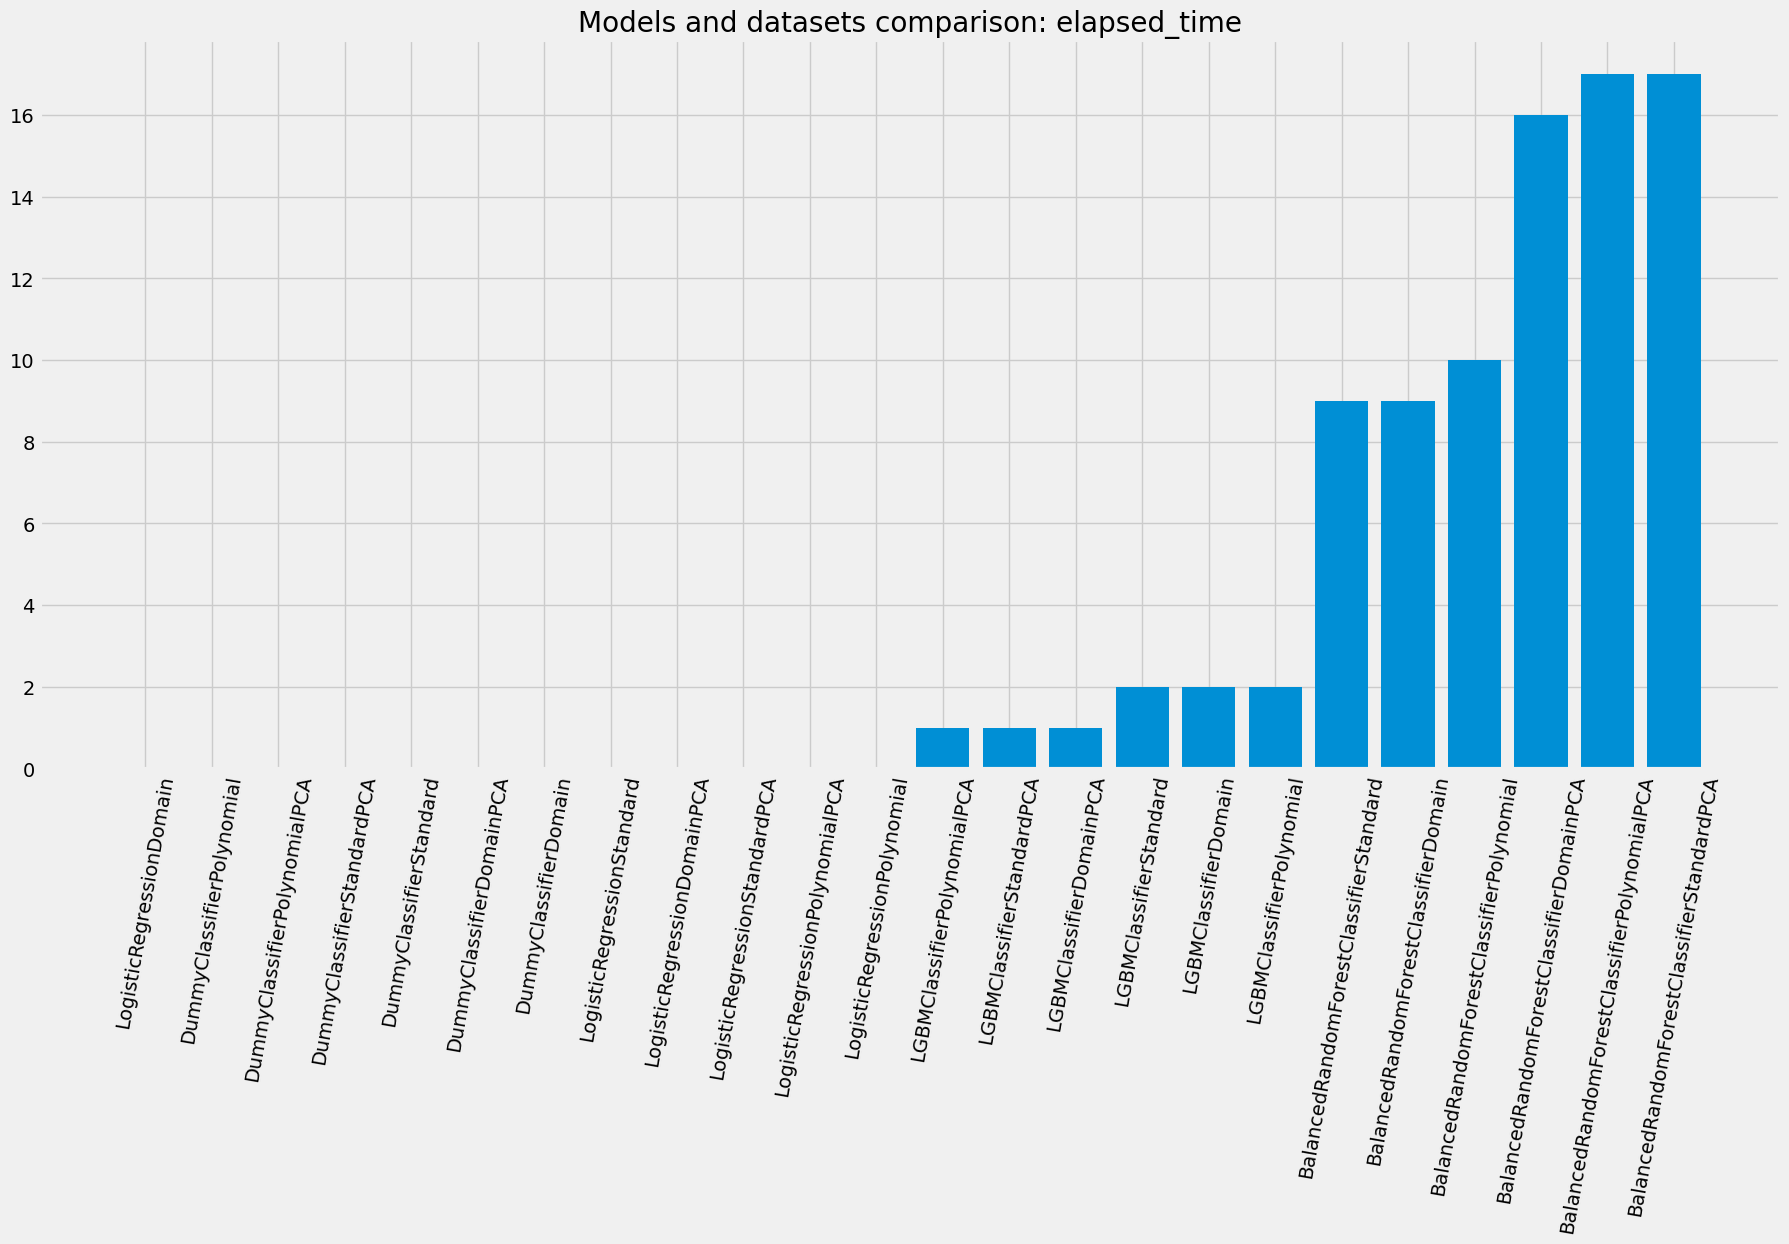

In [107]:
plot_compare(df_comp, 'elapsed_time', True)

In [108]:
# Getting the best score for further work
best_model, \
best_model_name, \
best_dataset_type, \
best_score, \
best_app_pca = df_comp.iloc[0][['model', 
                                'model_name', 
                                'dataset_type',
                                'score_spec',
                                'pca']]
best_train_test_set_idx = set_type_list.index(best_dataset_type)
best_train_test_set = train_test_set_list[best_train_test_set_idx]

pca_y_n = 'out'
if(best_app_pca):
    pca_y_n = ''
res  = f"The best model/dataset combination is {best_model_name} "
res += f"on {best_dataset_type} dataset with{pca_y_n} PCA ({spec_score_name} score: {best_score})."
print(res)

The best model/dataset combination is LogisticRegression on domain dataset without PCA (business_score score: 0.9391).


In [109]:
# Override best model considering the elapsed time (we keep our model considering that the Elapsed time of logistic regression
# is short, the models where train on a reduced df for computation efficiency)
#best_model = df_comp['model'].iloc[3]

# 6. Treshold optimization

In [110]:
# Testing tresholds
def get_best_treshold(model, 
                      train_test_set, 
                      app_pca=False, 
                      interval=0.1, 
                      dataset='standard', 
                      r=1, 
                      print_res=True, 
                      calc=calc_pred,
                      store=True,
                      loc=calc_path,
                      filename='TresholdOptimization',
                      ext='.csv'):
    
    filename = loc + filename + ext
    
    if(print_res):
        start_time = set_start()
        print(f">>> Searching for the best treshold...\n")
    
    if(calc):
        
        treshold_list = np.arange(0, 1+interval, interval)
        
        model_name = get_model_name(model)
        params = param_dict[model]
        model = model.__class__()

        best_score = 0
        best_treshold = None

        score_list = []
    
    else:
        
        df_tr_opt = pd.read_csv(filename)
        df_tresh_opt = pd.read_csv(filename, sep="\t")
        treshold_list = df_tresh_opt['treshold'].tolist()
        score_list = df_tresh_opt['score'].tolist()
    
    n_test = len(treshold_list)
    spec_score_dict = dict()
    
    for i, t in enumerate(treshold_list):

        t = round(t,r)

        if(print_res):
            print(f">>> Test # {i+1}/{n_test} in progress...")
        
        if(calc):
            
            test_zip = test(    model, 
                                params, 
                                train_test_set=train_test_set, 
                                dataset=dataset,
                                print_res=False, 
                                calc=True,
                                store=False, 
                                treshold=t,
                                app_pca=app_pca,
                                plot=False,
                                test_description=f"Best model [{model_name}] treshold optimization [test # {i+1}/{n_test}]")

            test_dict = dict(test_zip)
            spec_score_dict[t] = test_dict['score_spec']

            if(spec_score_dict[t]>best_score):
                best_score = spec_score_dict[t]
                best_treshold = t
            
            current_score = spec_score_dict[t]  
            
        else:
            
            current_score = score_list[i]
            spec_score_dict[t] = current_score
            
        if(print_res):
            print(f"Test # {i+1}/{n_test} executed. Treshold: {t}; score: {current_score}")

    if(calc & store):
        
        score_list = list(spec_score_dict.values())
        store_treshold_opt(treshold_list, score_list, filename) 
    
    else:
        
        best_score = max(score_list)
        best_tresh_idx = score_list.index(best_score)
        best_treshold = treshold_list[best_tresh_idx]
        
    if(print_res):
        
        text  = f"\n{n_test} tests executed in [ela_time] sec. Best treshold: {best_treshold} "
        text += f"({spec_score_name} score: {best_score}).\n"
        print_time(text=text, start_time=start_time)
        
    return spec_score_dict, best_treshold, best_score

In [111]:
spec_score_dict, best_treshold, best_score = get_best_treshold(best_model, 
                                                               best_train_test_set,
                                                               app_pca=best_app_pca)

>>> Searching for the best treshold...

>>> Test # 1/11 in progress...
Test # 1/11 executed. Treshold: 0.0; score: 0.9080352288789822
>>> Test # 2/11 in progress...
Test # 2/11 executed. Treshold: 0.1; score: 0.911612482331195
>>> Test # 3/11 in progress...
Test # 3/11 executed. Treshold: 0.2; score: 0.9194628683266283
>>> Test # 4/11 in progress...
Test # 4/11 executed. Treshold: 0.3; score: 0.9276938131999565
>>> Test # 5/11 in progress...
Test # 5/11 executed. Treshold: 0.4; score: 0.9346091116668479
>>> Test # 6/11 in progress...
Test # 6/11 executed. Treshold: 0.5; score: 0.9391105795368054
>>> Test # 7/11 in progress...
Test # 7/11 executed. Treshold: 0.6; score: 0.9382950962270306
>>> Test # 8/11 in progress...
Test # 8/11 executed. Treshold: 0.7; score: 0.9323909970642601
>>> Test # 9/11 in progress...
Test # 9/11 executed. Treshold: 0.8; score: 0.9251495052734587
>>> Test # 10/11 in progress...
Test # 10/11 executed. Treshold: 0.9; score: 0.9205175600739371
>>> Test # 11/11 in

In [112]:
# Comparing tresholds and scores
def plot_treshold_test(spec_score_dict, spec_score_name=spec_score_name):
    spec_score_name = f"{spec_score_name.capitalize()} score"
    treshold_list = spec_score_dict.keys()
    score_list = spec_score_dict.values()
    fig, ax = plt.subplots(figsize=(6, 5))
    plt.plot(treshold_list, score_list, label=spec_score_name)
    plt.axvline(x=best_treshold, color='k', dashes=(0.5, 1), 
                label="Best threshold: {}".format(best_treshold))
    title = f"{spec_score_name} depending on classifier treshold"
    plt.title(title, fontsize=10)
    plt.xlabel("Threshold", fontsize=10)
    plt.ylabel(spec_score_name, fontsize=10)
    plt.legend()
    plt.show()

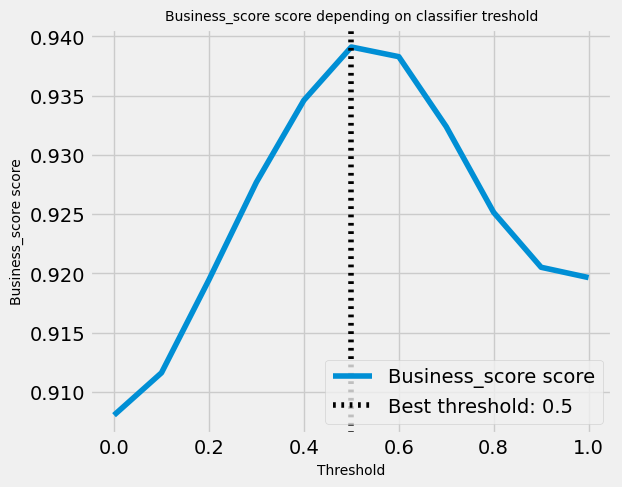

In [113]:
plot_treshold_test(spec_score_dict)

# 7. Pipeline

In [114]:
# Creating the training set
def create_pipeline_dataset(train_test_set, app_pca, print_res=True):
    X_idx = [0,1]
    if(app_pca):
        X_idx = [4,5]
    X_train_pipe = np.concatenate((train_test_set[X_idx[0]], train_test_set[X_idx[1]]))
    y_train_pipe = np.concatenate((train_test_set[2], train_test_set[3]))
    if(print_res):
        print(pd.DataFrame(X_train_pipe).shape, "training set [X] for pipeline")
    return X_train_pipe, y_train_pipe

In [115]:
X_train_pipe, y_train_pipe = create_pipeline_dataset(best_train_test_set, best_app_pca)

(30654, 764) training set [X] for pipeline


In [116]:
def empty_folder(folder):
    for filename in os.listdir(folder):
        file_path = os.path.join(folder, filename)
        try:
            if os.path.isfile(file_path) or os.path.islink(file_path):
                os.unlink(file_path)
            elif os.path.isdir(file_path):
                shutil.rmtree(file_path)
        except Exception as e:
            print('Failed to delete %s. Reason: %s' % (file_path, e))

In [117]:
# Final model instance
final_model = best_model.__class__()
final_params = param_dict[best_model]
final_model.set_params(**final_params)

LogisticRegression(C=0.001, class_weight='balanced')

In [118]:
def create_pipeline(model, X, y, path=model_path, filename='model.pkl', calc=calc_pred, print_res=True):

    if(print_res):
        start_time = set_start()
    
    model_name = get_model_name(model)

    if(calc):

        # Pipeline instanciation
        pipe = Pipeline([('scaler', StandardScaler()), 
                         ('classifier', model)])

        #pipe = Pipeline([('classifier', model)])

        print(f">>> Pipeline ({model_name}) training in progress...")

        # Pipeline training
        pipe.fit(X, y)

        # Pipeline storage
        signature = infer_signature(X, y)
        if os.listdir(path):
            empty_folder(path)
            mlflow.sklearn.save_model(pipe, path, signature=signature)

    else:

        # Loads a stored pipeline
        pipe = pickle.load(open(model_path + '/' + filename, 'rb'))
    
    if(print_res):
        text = f"Pipeline ({model_name}) trained in [ela_time] sec."
        print_time(text, start_time)
    
    return pipe

In [119]:
pipe = create_pipeline(final_model, X_train_pipe, y_train_pipe, calc=calc_pred)

>>> Pipeline (LogisticRegression) training in progress...
Pipeline (LogisticRegression) trained in 1.0 sec.


# Type in a cmd prompt "mlflow ui" to generate the link to the Experiment dashboard

In [121]:
# End of MLFlow tracking
mlflow.end_run()

In [122]:
# Export final data (prod) to file (.csv)
n_rows = 1000
store_data(df_test_domain.iloc[:n_rows, :], 'prod')

Data storage (./data/cleaned/data_prod.csv): ok.


# 8. Features importance

In [123]:
# Explainer instance
explainer = shap.LinearExplainer(pipe['classifier'], X_train_pipe)

# Column names
feat_names = df_test_domain.columns.tolist()[1:]

# Dataframe for explanation
df_feat_imp = pd.DataFrame(X_train_pipe, columns=feat_names)

# Explanationa and shap values
explanation = explainer(df_feat_imp)
shap_values = explainer.shap_values(df_feat_imp)

In [124]:
# Finds the first two consecutive observation in our dataset, which have different target, 
# and for which the predictions are correct 
def find_ind_loc_imp(df, X, predictor, print_res=True):
    y_pred = predictor.predict(X)
    df_comp = df[['SK_ID_CURR', target]]
    df_comp['pred'] = y_pred
    df_comp = df_comp.loc[df_comp['pred'] == df_comp[target], target]
    idx_list = []
    for i in range(len(df_comp)-1):
        if(df_comp.iloc[i]!=df_comp.iloc[i+1]):
            idx_list.append(df_comp.index[i])
            idx_list.append(df_comp.index[i+1])
            break
    rows = df.loc[df.index.isin(idx_list)]
    id_list = rows['SK_ID_CURR'].tolist()
    target_list = rows[target].tolist()
    class_dict = {0: 'no default', 1: 'default'}
    if(print_res):
        print(f"We will check the features local importance on the following observations:")
        for i in range(2):
            print(f"- Id {id_list[i]}; class: {target_list[i]} ({class_dict[target_list[i]]})")
    return idx_list

### Global importance

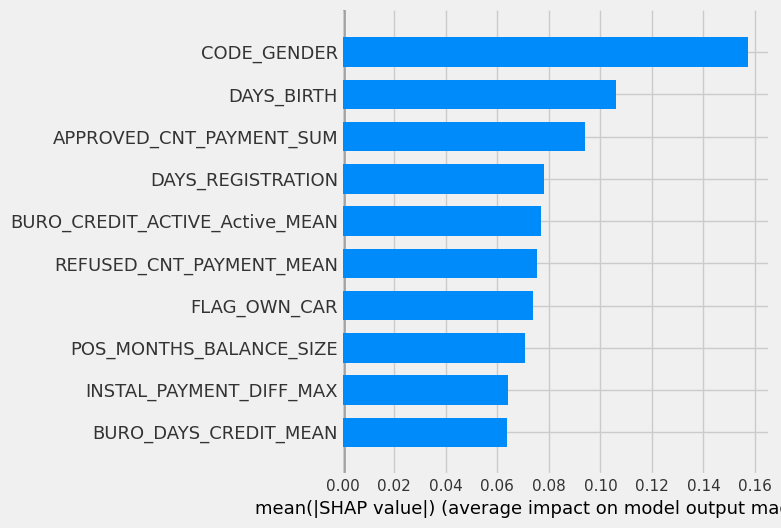

In [125]:
shap.summary_plot(shap_values, feature_names=feat_names, plot_type='bar', max_display=10)

### Local importance

In [126]:
def shap_plot(X, ex, sh_val, plot_type='bar', il=None, fn=feat_names, md=10):
    if(il==None):
        il = np.arange(0,len(X),1)
    for i in il:
        if(plot_type=='bar'):
            shap.bar_plot(sh_val[i], feature_names=fn, max_display=md)
        elif(plot_type=='waterfall'):
            shap.plots.waterfall(ex[i])
        else:
            print(f"The selected plot type ({plot_type}) is incorrect.")
            break

In [128]:
# Rows selected for features local importance analysis
idx_list = find_ind_loc_imp(df_train_domain_sample, X_train_pipe, pipe)

We will check the features local importance on the following observations:
- Id 312519; class: 0 (no default)
- Id 160686; class: 1 (default)


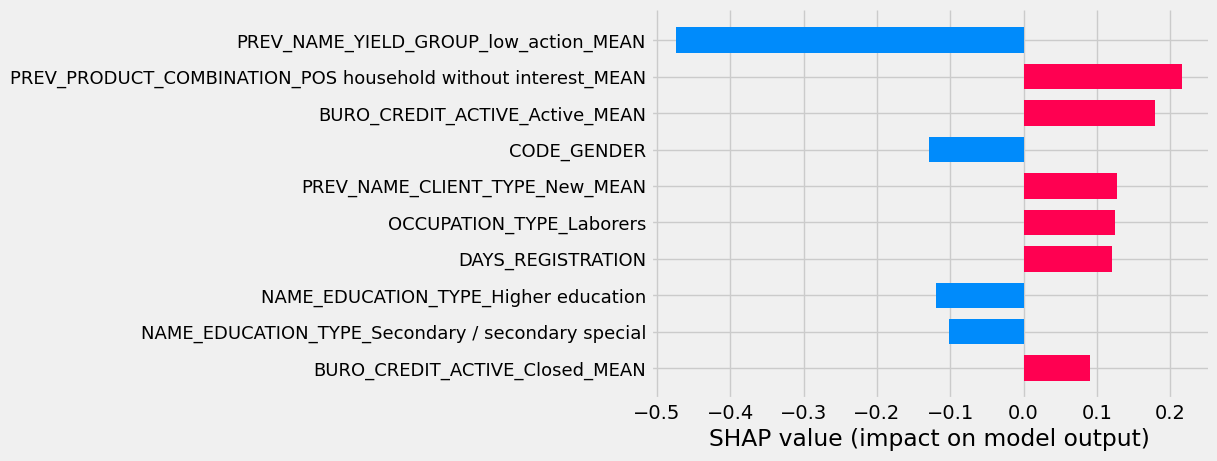

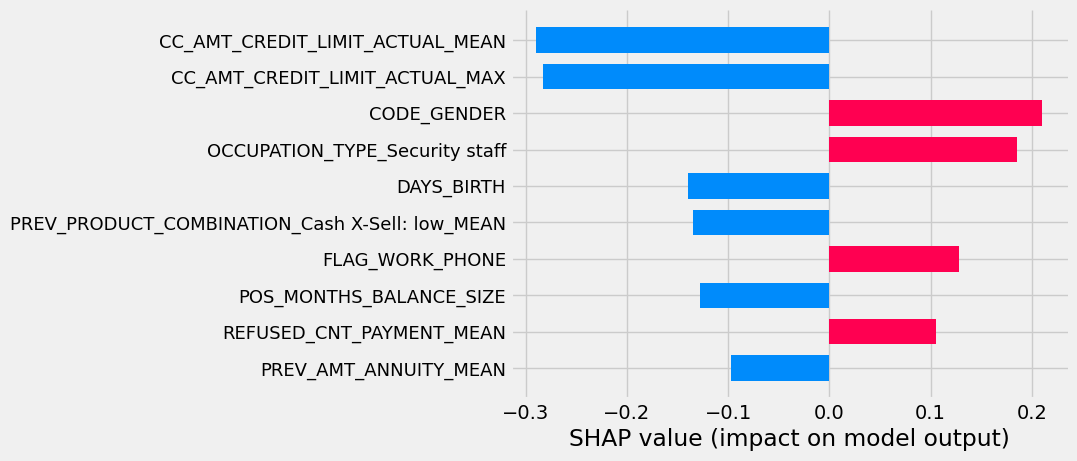

In [130]:
idx_list = [2,3]
shap_plot(X_train_pipe, explanation, shap_values, 'bar', il=idx_list)

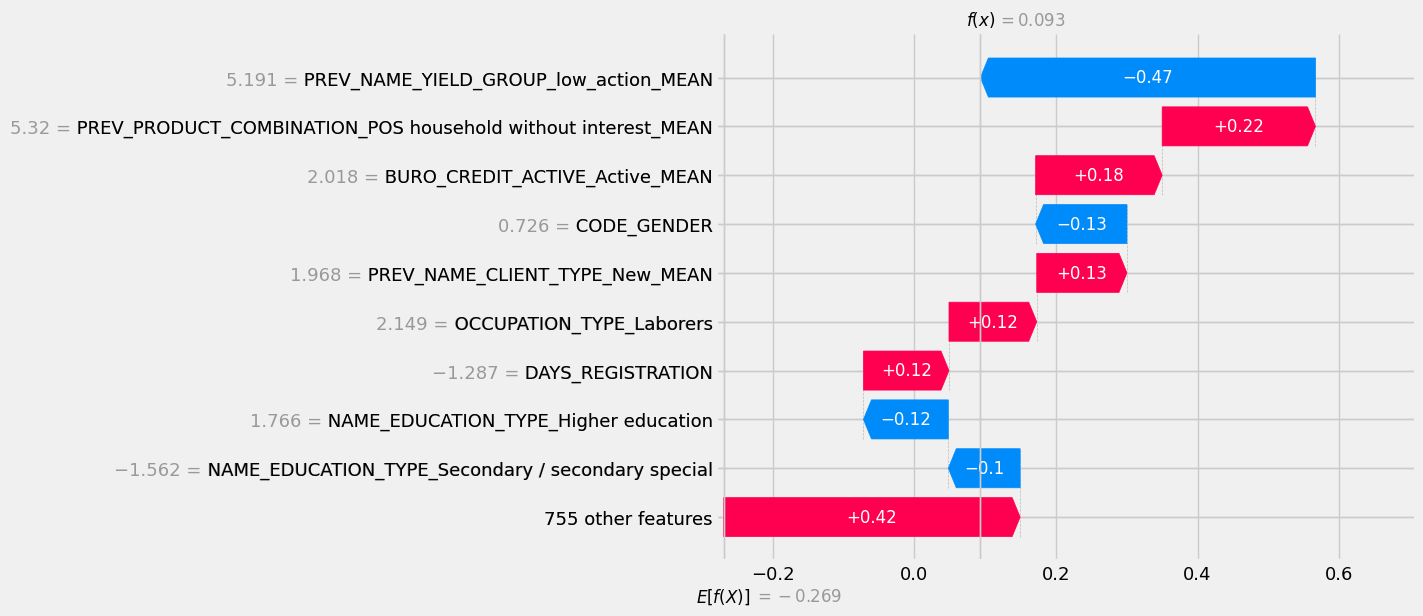

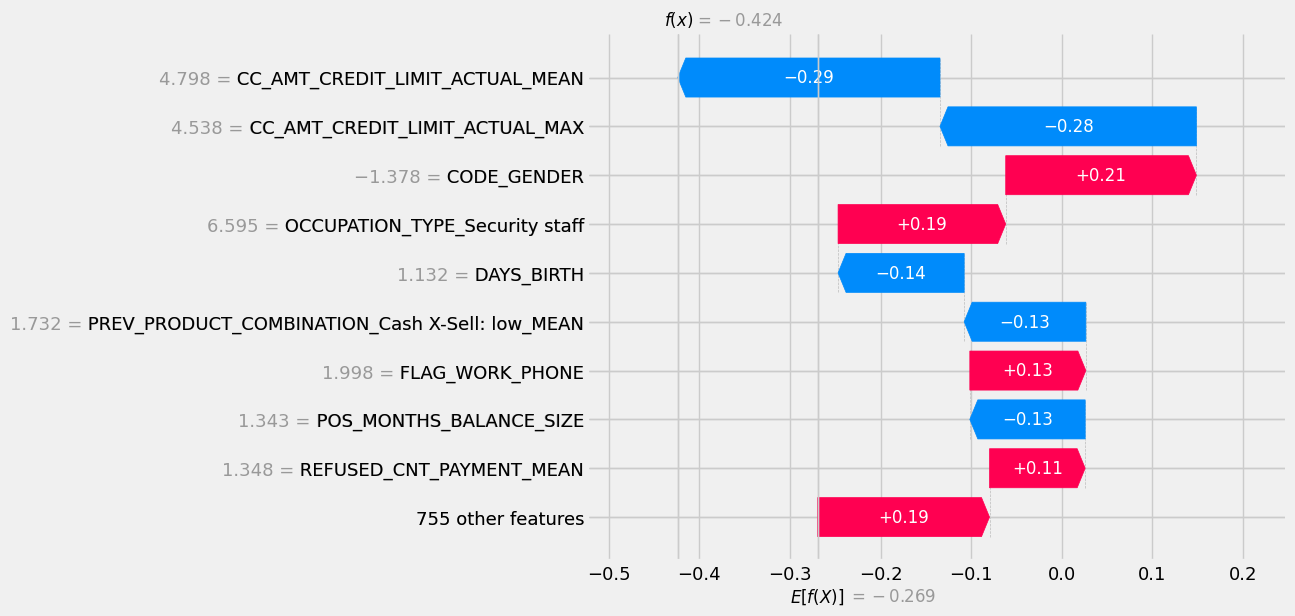

In [131]:
shap_plot(X_train_pipe, explanation, shap_values, 'waterfall', il=idx_list)